## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


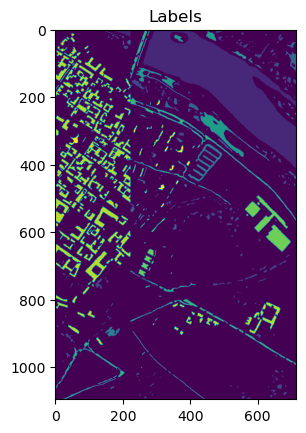

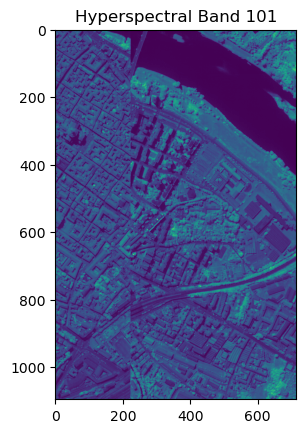

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 10 train


 -- Test set created with: 
	148017 samples
	shape (148017, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(90, 5, 5, 102)
(45, 5, 5, 102)
(148017, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1665, PSNR: 4.4250


	 Training Batch [200/1852], Loss: 0.0919, PSNR: 6.7725


	 Training Batch [400/1852], Loss: 0.0493, PSNR: 11.0706


	 Training Batch [600/1852], Loss: 0.0266, PSNR: 11.8845


	 Training Batch [800/1852], Loss: 0.0159, PSNR: 15.1989


	 Training Batch [1000/1852], Loss: 0.0122, PSNR: 16.0022


	 Training Batch [1200/1852], Loss: 0.0088, PSNR: 17.0194


	 Training Batch [1400/1852], Loss: 0.0081, PSNR: 17.0080


	 Training Batch [1600/1852], Loss: 0.0070, PSNR: 18.6316


	 Training Batch [1800/1852], Loss: 0.0053, PSNR: 20.5967


Epoch [1/50] Training Loss: 0.0331, PSNR: 13.5376
	[Val]   Batch [1/463] Loss: 0.0057, PSNR: 17.6856
	[Val]   Batch [10/463] Loss: 0.0053, PSNR: 18.8522
	[Val]   Batch [20/463] Loss: 0.0053, PSNR: 17.8493
	[Val]   Batch [30/463] Loss: 0.0064, PSNR: 18.4370
	[Val]   Batch [40/463] Loss: 0.0051, PSNR: 17.5178
	[Val]   Batch [50/463] Loss: 0.0054, PSNR: 17.7361


	[Val]   Batch [60/463] Loss: 0.0051, PSNR: 17.7931
	[Val]   Batch [70/463] Loss: 0.0071, PSNR: 18.1785
	[Val]   Batch [80/463] Loss: 0.0063, PSNR: 20.0989
	[Val]   Batch [90/463] Loss: 0.0062, PSNR: 19.1630
	[Val]   Batch [100/463] Loss: 0.0062, PSNR: 18.9158
	[Val]   Batch [110/463] Loss: 0.0072, PSNR: 18.3100
	[Val]   Batch [120/463] Loss: 0.0050, PSNR: 17.7595


	[Val]   Batch [130/463] Loss: 0.0058, PSNR: 19.1742
	[Val]   Batch [140/463] Loss: 0.0068, PSNR: 18.7266
	[Val]   Batch [150/463] Loss: 0.0077, PSNR: 18.7903
	[Val]   Batch [160/463] Loss: 0.0062, PSNR: 19.0272
	[Val]   Batch [170/463] Loss: 0.0079, PSNR: 18.0094
	[Val]   Batch [180/463] Loss: 0.0058, PSNR: 18.7713
	[Val]   Batch [190/463] Loss: 0.0063, PSNR: 19.0841


	[Val]   Batch [200/463] Loss: 0.0063, PSNR: 18.4895
	[Val]   Batch [210/463] Loss: 0.0061, PSNR: 18.0726
	[Val]   Batch [220/463] Loss: 0.0060, PSNR: 19.2870
	[Val]   Batch [230/463] Loss: 0.0071, PSNR: 19.1394
	[Val]   Batch [240/463] Loss: 0.0054, PSNR: 17.9123
	[Val]   Batch [250/463] Loss: 0.0069, PSNR: 17.1105
	[Val]   Batch [260/463] Loss: 0.0060, PSNR: 18.1196


	[Val]   Batch [270/463] Loss: 0.0047, PSNR: 17.2653
	[Val]   Batch [280/463] Loss: 0.0057, PSNR: 19.9847
	[Val]   Batch [290/463] Loss: 0.0063, PSNR: 17.0335
	[Val]   Batch [300/463] Loss: 0.0063, PSNR: 19.2566
	[Val]   Batch [310/463] Loss: 0.0058, PSNR: 19.1553
	[Val]   Batch [320/463] Loss: 0.0059, PSNR: 19.0277
	[Val]   Batch [330/463] Loss: 0.0068, PSNR: 18.4451


	[Val]   Batch [340/463] Loss: 0.0056, PSNR: 19.3621
	[Val]   Batch [350/463] Loss: 0.0073, PSNR: 19.3221
	[Val]   Batch [360/463] Loss: 0.0050, PSNR: 20.2071
	[Val]   Batch [370/463] Loss: 0.0073, PSNR: 18.3552
	[Val]   Batch [380/463] Loss: 0.0072, PSNR: 18.4927
	[Val]   Batch [390/463] Loss: 0.0065, PSNR: 18.3342
	[Val]   Batch [400/463] Loss: 0.0057, PSNR: 17.3789
	[Val]   Batch [410/463] Loss: 0.0056, PSNR: 19.6791


	[Val]   Batch [420/463] Loss: 0.0059, PSNR: 18.4706
	[Val]   Batch [430/463] Loss: 0.0057, PSNR: 17.8970
	[Val]   Batch [440/463] Loss: 0.0056, PSNR: 18.9092
	[Val]   Batch [450/463] Loss: 0.0044, PSNR: 16.2168
	[Val]   Batch [460/463] Loss: 0.0061, PSNR: 17.6172
Epoch [1/50] Validation Loss: 0.0061, PSNR: 18.4558

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0055, PSNR: 19.2837


	 Training Batch [200/1852], Loss: 0.0058, PSNR: 17.8807


	 Training Batch [400/1852], Loss: 0.0054, PSNR: 18.7636


	 Training Batch [600/1852], Loss: 0.0049, PSNR: 19.7910


	 Training Batch [800/1852], Loss: 0.0058, PSNR: 20.2142


	 Training Batch [1000/1852], Loss: 0.0062, PSNR: 20.0377


	 Training Batch [1200/1852], Loss: 0.0033, PSNR: 20.8324


	 Training Batch [1400/1852], Loss: 0.0055, PSNR: 20.2306


	 Training Batch [1600/1852], Loss: 0.0044, PSNR: 21.3195


	 Training Batch [1800/1852], Loss: 0.0042, PSNR: 20.4987


Epoch [2/50] Training Loss: 0.0046, PSNR: 19.8526
	[Val]   Batch [1/463] Loss: 0.0028, PSNR: 20.6875
	[Val]   Batch [10/463] Loss: 0.0026, PSNR: 21.9307
	[Val]   Batch [20/463] Loss: 0.0026, PSNR: 21.0323
	[Val]   Batch [30/463] Loss: 0.0034, PSNR: 21.1569
	[Val]   Batch [40/463] Loss: 0.0025, PSNR: 20.6363
	[Val]   Batch [50/463] Loss: 0.0026, PSNR: 20.8188
	[Val]   Batch [60/463] Loss: 0.0025, PSNR: 20.9038


	[Val]   Batch [70/463] Loss: 0.0039, PSNR: 20.8000
	[Val]   Batch [80/463] Loss: 0.0034, PSNR: 22.7765
	[Val]   Batch [90/463] Loss: 0.0031, PSNR: 22.0728
	[Val]   Batch [100/463] Loss: 0.0034, PSNR: 21.5165
	[Val]   Batch [110/463] Loss: 0.0039, PSNR: 20.9794
	[Val]   Batch [120/463] Loss: 0.0024, PSNR: 20.9078
	[Val]   Batch [130/463] Loss: 0.0029, PSNR: 22.1639


	[Val]   Batch [140/463] Loss: 0.0036, PSNR: 21.4237
	[Val]   Batch [150/463] Loss: 0.0041, PSNR: 21.4925
	[Val]   Batch [160/463] Loss: 0.0033, PSNR: 21.6980
	[Val]   Batch [170/463] Loss: 0.0044, PSNR: 20.5551
	[Val]   Batch [180/463] Loss: 0.0032, PSNR: 21.3448
	[Val]   Batch [190/463] Loss: 0.0032, PSNR: 21.9848
	[Val]   Batch [200/463] Loss: 0.0033, PSNR: 21.3071


	[Val]   Batch [210/463] Loss: 0.0034, PSNR: 20.6356
	[Val]   Batch [220/463] Loss: 0.0032, PSNR: 22.0608
	[Val]   Batch [230/463] Loss: 0.0038, PSNR: 21.8633
	[Val]   Batch [240/463] Loss: 0.0027, PSNR: 20.8646
	[Val]   Batch [250/463] Loss: 0.0037, PSNR: 19.7990
	[Val]   Batch [260/463] Loss: 0.0032, PSNR: 20.9008


	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.6341
	[Val]   Batch [280/463] Loss: 0.0029, PSNR: 22.9655
	[Val]   Batch [290/463] Loss: 0.0032, PSNR: 19.9328
	[Val]   Batch [300/463] Loss: 0.0033, PSNR: 22.1070
	[Val]   Batch [310/463] Loss: 0.0031, PSNR: 21.8992
	[Val]   Batch [320/463] Loss: 0.0031, PSNR: 21.8573
	[Val]   Batch [330/463] Loss: 0.0035, PSNR: 21.3115
	[Val]   Batch [340/463] Loss: 0.0029, PSNR: 22.2649


	[Val]   Batch [350/463] Loss: 0.0042, PSNR: 21.7809
	[Val]   Batch [360/463] Loss: 0.0026, PSNR: 23.0637
	[Val]   Batch [370/463] Loss: 0.0038, PSNR: 21.1398
	[Val]   Batch [380/463] Loss: 0.0037, PSNR: 21.4109
	[Val]   Batch [390/463] Loss: 0.0034, PSNR: 21.2041
	[Val]   Batch [400/463] Loss: 0.0030, PSNR: 20.2008
	[Val]   Batch [410/463] Loss: 0.0028, PSNR: 22.7578
	[Val]   Batch [420/463] Loss: 0.0030, PSNR: 21.3855


	[Val]   Batch [430/463] Loss: 0.0030, PSNR: 20.7178
	[Val]   Batch [440/463] Loss: 0.0029, PSNR: 21.7236
	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.4369
	[Val]   Batch [460/463] Loss: 0.0031, PSNR: 20.6000
Epoch [2/50] Validation Loss: 0.0031, PSNR: 21.3381

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0039, PSNR: 20.6947


	 Training Batch [200/1852], Loss: 0.0031, PSNR: 21.4681


	 Training Batch [400/1852], Loss: 0.0030, PSNR: 22.7817


	 Training Batch [600/1852], Loss: 0.0023, PSNR: 25.3884


	 Training Batch [800/1852], Loss: 0.0029, PSNR: 21.4760


	 Training Batch [1000/1852], Loss: 0.0030, PSNR: 22.4439


	 Training Batch [1200/1852], Loss: 0.0019, PSNR: 23.0457


	 Training Batch [1400/1852], Loss: 0.0021, PSNR: 23.5162


	 Training Batch [1600/1852], Loss: 0.0018, PSNR: 23.8099


	 Training Batch [1800/1852], Loss: 0.0018, PSNR: 23.1044


Epoch [3/50] Training Loss: 0.0025, PSNR: 22.4735
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.4101
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.6543
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.8532
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.3067
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.9063
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.2826


	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.3237
	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.9758
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.9165
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 24.9387
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.4518
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.2290
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.2295


	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.2872
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.4463
	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.0864
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.1668
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.5098
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 23.9692
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.0306
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.4473


	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.1062
	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.6199
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.6268
	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.5649
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.4726
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.5124
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.8983
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.6503


	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.7636
	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.7485
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.2054
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.6124
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.5679
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.9558
	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.7208


	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.7632
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.3553
	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 25.0023
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.6027
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.6313
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.5432
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.3159
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.0477


	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2359
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.3015
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.3366
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.1619

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0020, PSNR: 23.8192


	 Training Batch [200/1852], Loss: 0.0016, PSNR: 24.3444


	 Training Batch [400/1852], Loss: 0.0016, PSNR: 24.9075


	 Training Batch [600/1852], Loss: 0.0014, PSNR: 24.5812


	 Training Batch [800/1852], Loss: 0.0015, PSNR: 22.8878


	 Training Batch [1000/1852], Loss: 0.0015, PSNR: 24.4859


	 Training Batch [1200/1852], Loss: 0.0017, PSNR: 27.7060


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 24.6503


	 Training Batch [1600/1852], Loss: 0.0014, PSNR: 25.1606


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 25.5013


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3237
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.8323
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.1087
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.3347
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.8338
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.2703
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.7125
	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.6862


	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.4914
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.6751
	[Val]   Batch [90/463] Loss: 0.0011, PSNR: 26.4698
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 25.9714
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.8555
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.6359
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8214


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9712
	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.7501
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.4960
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.8986
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.3744
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.4863
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.1039


	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4351
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9702
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.4158
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.0773
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8415
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.8328


	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.3611
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.0795
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.2855
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.1391
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.5475
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.1207
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.1714


	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.4267
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.2005
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.7845
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.9853
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7773
	[Val]   Batch [390/463] Loss: 0.0010, PSNR: 26.2921
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.9269
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.0934


	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.8010
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2889
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.6569
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.5902
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.7698
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.6577

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0014, PSNR: 26.5596


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 24.8391


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 23.2931


	 Training Batch [600/1852], Loss: 0.0016, PSNR: 26.0447


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 24.9352


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 25.5195


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 26.1451


	 Training Batch [1400/1852], Loss: 0.0012, PSNR: 25.4466


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 23.6929


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 25.3403


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.3921
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.7992
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.1843
	[Val]   Batch [20/463] Loss: 0.0007, PSNR: 26.3997
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.7961
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.2126
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 25.7404
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6746


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.4526
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 28.8437
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.5412
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9836
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.9042
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.6710
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.8551


	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.9747
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.7929
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.3972
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.8003
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3624
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4683


	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.2269
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.3706
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.9196
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.5057
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.1081
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7799
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.7241


	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.5125
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.1172
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.3223
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 27.0334
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.5489
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.2133
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.2216


	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.4982
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.1293
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.5585
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 27.0135
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.9073
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.3660
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8879


	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.1118
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.7688
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1961
	[Val]   Batch [440/463] Loss: 0.0009, PSNR: 26.6691
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.6353
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 25.7427
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.6831

LOG: Epoch [6/50]


	 Training Batch [1/1852], Loss: 0.0010, PSNR: 27.3333


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 25.4096


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 26.5649


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 27.3644


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 25.1196


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 27.7594


	 Training Batch [1200/1852], Loss: 0.0010, PSNR: 25.8305


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 26.4664


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 27.2473


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 25.0540


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2202
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.5412
	[Val]   Batch [10/463] Loss: 0.0007, PSNR: 27.9325
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.1337
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.5506
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 25.9248
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.5100
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.3841


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.2024
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.7337
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3378
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8105
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7368
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.4422
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6209


	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.7618
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.5839
	[Val]   Batch [160/463] Loss: 0.0010, PSNR: 27.1046
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.5532
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.1916
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.2143
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.0236


	[Val]   Batch [210/463] Loss: 0.0010, PSNR: 26.1234
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.6393
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3306
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 26.8900
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.5499
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.3953
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.3556
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.9053


	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.0929
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.6623
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.3250
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.0603
	[Val]   Batch [330/463] Loss: 0.0008, PSNR: 28.0102
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.2982
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.8957
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1009


	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.8270
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.7121
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.1686
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6209
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.8603
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.5037
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 25.9075


	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.4651
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.4429
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.4562
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.4581

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.7186


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 25.4050


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 24.4883


	 Training Batch [600/1852], Loss: 0.0012, PSNR: 25.3701


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 25.9200


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 27.8222


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 25.7073


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.5068


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.8372


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.4263


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.8619
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.3640
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.8433
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.0547
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4059
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.7595
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.4238
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.1675


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.0578
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.7629
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.2437
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.7183
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.6635
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 27.2842
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.4427
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.6609


	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.5608
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9704
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.3850
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.1539
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.0638
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.9656
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0016


	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.4652
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.2568
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.7736
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.4349
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2730
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 27.2616
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.7846
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.0108


	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.4595
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1792
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.0344
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.9359
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.1798
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.7445
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.6894


	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.7408
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.7182
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1228
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.4090
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.7048
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4091
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.7459


	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.2422
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.3113
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.3573
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.3537

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 27.5703


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 25.7207


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 28.6318


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.4829


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 26.7482


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 26.3870


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 27.8151


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.5128


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 27.3867


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.4974


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4783
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.1103
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.7205
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.9482
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.1950
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.6005
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.3611
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.9779


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.8047
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.6787
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.0620
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.4876
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.4952
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.1511
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.2809


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.4029
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.4783
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.7612
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.1502
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.9101
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.8705
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.8627


	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 27.8462
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.2190
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 31.0526
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5903
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.1993
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.1123
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.2806
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.6148


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.8464
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.1865
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.0313
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.9394
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.7746
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.0178
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.5098
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2384


	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4755
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.6652
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.9517
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1586
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.4591
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.2725
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.5884


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.9644
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.2070
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.2586
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.1871

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.1905


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.5347


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 27.4850


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.9319


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 26.4856


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 28.2402


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 29.0200


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.9137


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.1068


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.2563


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9582
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.4740
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.1263
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.3201
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6304
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.9505
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.8111
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.3262


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.2867
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.1487
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.4738
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.9675
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.0066
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.4923
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.6527


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.8295
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 31.0026
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.2893
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.7069
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.3713
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.2157
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.2164


	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.4015
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.6162
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.5022
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.0124
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.7164
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.6878
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.6090


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.0456
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3315
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.6046
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.4814
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.3552
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.1911
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.4296
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.0746


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.4617
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.9761
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.1007
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.4026
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.5702
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.7987
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.6823


	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 28.0294
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.3783
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.5812
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.7497
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6247

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 27.1215


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.4723


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.9405


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 29.4871


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.1774


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.3487


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.5744


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.1134


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.9130


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 26.9561


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.3871
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.9243
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.6088
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.7593
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.1218
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.3253
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.3222
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.7682


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.8808
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.6746
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.9707
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.4993
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.4979
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.9253
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.1220


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.3349
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.6343
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.8791
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.2414
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.8696
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.6433
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.6816


	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.0156
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.0551
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.9730
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.5059
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.3196
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.2914
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.0523


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.4944
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.8440
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.0689
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.9927
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.8602
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.6684
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.9284
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.6349


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.7803
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.4422
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.5891
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.8825
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.0186
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.2025
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.1336


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.5623
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.8098
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.0461
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.2784
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.1168

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.9082


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.7135


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.3958


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 27.3916


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 29.8866


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.6762


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.1631


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.2979


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.7488


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 30.2559


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8024
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.4174
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.1656
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.3720
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.6484
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.8605
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.9424
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.3727


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.4465
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.2993
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.5626
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.0056
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.0727
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.3962
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.6988
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.8485


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3020
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.4763
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7544
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.3774
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.1564
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.3387
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.5999
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.4980


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.5799
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.0646
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.9271
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8759
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.7145
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 32.0687


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.4526
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.5881
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5679
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.4055
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.2502
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.5122
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.2187


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.0963
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.0084
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.3101
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.4580
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.4833
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.7231
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.6775
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.0870


	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.2764
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.5553
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.8783
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.6867

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.3957


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.6437


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.9722


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 29.5359


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.0416


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.7630


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.8450


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.9521


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 27.9357


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.7017


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.0829
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8211
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6233
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.8201
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.0681
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3153
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.4430
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7816


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.8059
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.6817
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.9335
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.3959
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.3689
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8122
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0982
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1661


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.6144
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9334
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1531
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.7966
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.4737
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6807
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.0297


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.8678
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.9254
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5390
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2699
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.3505
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2154
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4447


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.8809
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.9297
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9435
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.8366
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.6638
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.9101
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.5478
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3705


	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.3693
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6889
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.7816
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.8765
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.0442
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0695
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.4872
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6505


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0472
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.2679
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.0879

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 31.3202


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.4177


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 31.3701


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.2402


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.4646


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.1525


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 26.6367


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.7951


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.9650


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 27.3789


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3571
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.1163
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8916
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0338
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.4066
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5473
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.7422
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0489


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.2575
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 34.0631
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.2479
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.7806
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7836
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0617
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3961


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.5247
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.0869
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3464
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5172
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.1352
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7887
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.0405


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.4396
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.1066
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.2926
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.8765
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.6898
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7078
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.4484


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.7450
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.2033
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3246
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.2742
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.1912
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.0028
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2436


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.9707
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5298
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.7323
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.1344
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1457
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1398
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3310


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.3963
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.7638
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.8987
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.3127
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6198
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.4128

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.0892


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 27.8056


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 28.6271


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.7282


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.7964


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 28.4340


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.6596


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.0049


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 28.0726


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 30.2693


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6289
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.3936
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.2213
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.3443
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.7135
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8085
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 31.0353
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3813


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5253
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.3332
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.5837
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.1206
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.1142
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.2861
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.7349


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7507
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.3716
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.6123
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.8049
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3952
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9759
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3085


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.6908
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.3608
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.6549
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.2000
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.9802
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.0537
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.7009
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9638


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.5928
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.6139
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.5268
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.4812
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.3366
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.5116
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.2864
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6770


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.0781
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.4430
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.4194
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.4001
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.6316
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6257
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9939


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.2053
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.6076
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.9163
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.7089
Early stopping triggered at epoch 14. No improvement for 3 epochs.


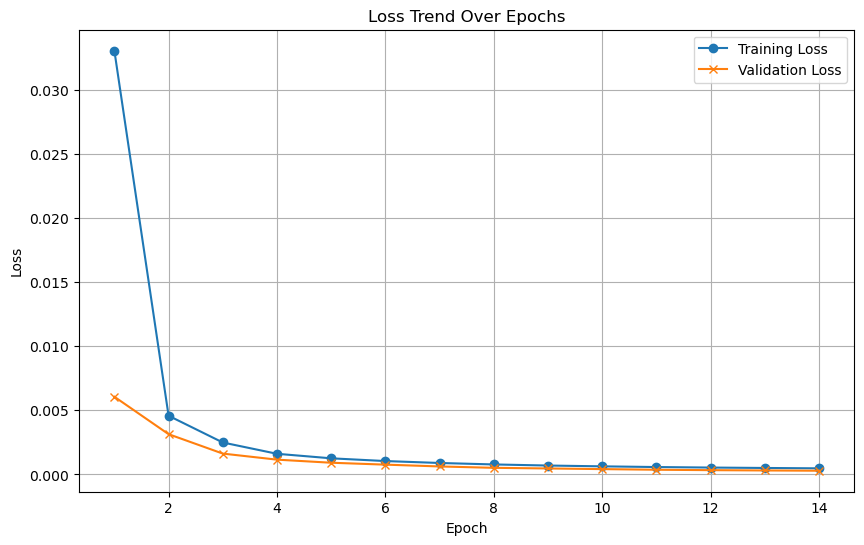

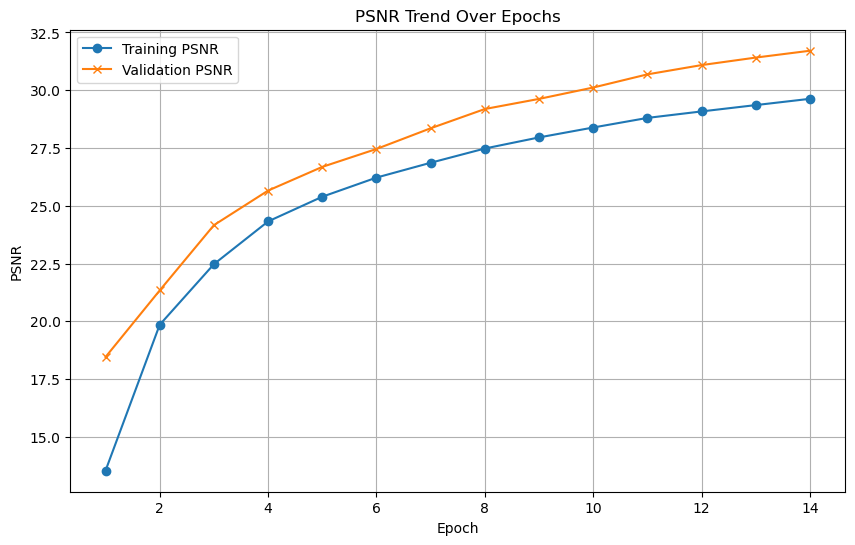

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2097
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2033. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1701
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1153
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0987
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

Epoch [7/1000] completed, Average Training Loss: 2.0274
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.0031
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.0015
    Validation Batch [1/1], Loss: 2.2032
Validation Loss: 2.2032, Validation Accuracy: 11.11%
Validation loss improved from 2.2033 to 2.2032. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9929
    Validation Batch [1/1], Loss: 2.2031
Validation Loss: 2.2031, Validation Accuracy: 11.11%
Validation loss improved from 2.2032 to 2.2031. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training

Epoch [38/1000] completed, Average Training Loss: 1.6451
    Validation Batch [1/1], Loss: 2.0933
Validation Loss: 2.0933, Validation Accuracy: 28.89%
Validation loss improved from 2.1081 to 2.0933. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.6360
    Validation Batch [1/1], Loss: 2.0761
Validation Loss: 2.0761, Validation Accuracy: 31.11%
Validation loss improved from 2.0933 to 2.0761. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.6203
    Validation Batch [1/1], Loss: 2.0572
Validation Loss: 2.0572, Validation Accuracy: 33.33%
Validation loss improved from 2.0761 to 2.0572. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.6302
    Validation Batch [1/1], Loss: 2.0377
Validation Loss: 2.0377, Validation Accuracy: 33.33%
Validation loss improved from 2.0572 to 2.0377. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

Epoch [68/1000] completed, Average Training Loss: 1.3606
    Validation Batch [1/1], Loss: 1.4942
Validation Loss: 1.4942, Validation Accuracy: 60.00%
Validation loss improved from 1.5112 to 1.4942. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3789
    Validation Batch [1/1], Loss: 1.4794
Validation Loss: 1.4794, Validation Accuracy: 64.44%
Validation loss improved from 1.4942 to 1.4794. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.3353
    Validation Batch [1/1], Loss: 1.4664
Validation Loss: 1.4664, Validation Accuracy: 71.11%
Validation loss improved from 1.4794 to 1.4664. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.3378
    Validation Batch [1/1], Loss: 1.4560
Validation Loss: 1.4560, Validation Accuracy: 71.11%
Validation loss improved from 1.4664 to 1.4560. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 1.2015
Validation Loss: 1.2015, Validation Accuracy: 71.11%
Validation loss improved from 1.2069 to 1.2015. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.1224
    Validation Batch [1/1], Loss: 1.2000
Validation Loss: 1.2000, Validation Accuracy: 71.11%
Validation loss improved from 1.2015 to 1.2000. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.1032
    Validation Batch [1/1], Loss: 1.1894
Validation Loss: 1.1894, Validation Accuracy: 71.11%
Validation loss improved from 1.2000 to 1.1894. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.0982
    Validation Batch [1/1], Loss: 1.1771
Validation Loss: 1.1771, Validation Accuracy: 71.11%
Validation loss improved from 1.1894 to 1.1771. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.0948
    

    Validation Batch [1/1], Loss: 0.9760
Validation Loss: 0.9760, Validation Accuracy: 75.56%
Validation loss improved from 0.9787 to 0.9760. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.9192
    Validation Batch [1/1], Loss: 0.9711
Validation Loss: 0.9711, Validation Accuracy: 75.56%
Validation loss improved from 0.9760 to 0.9711. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 0.9190
    Validation Batch [1/1], Loss: 0.9643
Validation Loss: 0.9643, Validation Accuracy: 75.56%
Validation loss improved from 0.9711 to 0.9643. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 0.8921
    Validation Batch [1/1], Loss: 0.9556
Validation Loss: 0.9556, Validation Accuracy: 77.78%
Validation loss improved from 0.9643 to 0.9556. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.8666


Epoch [158/1000] completed, Average Training Loss: 0.7175
    Validation Batch [1/1], Loss: 0.7838
Validation Loss: 0.7838, Validation Accuracy: 91.11%
Validation loss improved from 0.7876 to 0.7838. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.6963
    Validation Batch [1/1], Loss: 0.7791
Validation Loss: 0.7791, Validation Accuracy: 91.11%
Validation loss improved from 0.7838 to 0.7791. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.7151
    Validation Batch [1/1], Loss: 0.7795
Validation Loss: 0.7795, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.6549
    Validation Batch [1/1], Loss: 0.7719
Validation Loss: 0.7719, Validation Accuracy: 82.22%
Validation loss improved from 0.7791 to 0.7719. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000

Epoch [191/1000] completed, Average Training Loss: 0.5144
    Validation Batch [1/1], Loss: 0.6251
Validation Loss: 0.6251, Validation Accuracy: 93.33%
Validation loss improved from 0.6279 to 0.6251. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.5325
    Validation Batch [1/1], Loss: 0.6174
Validation Loss: 0.6174, Validation Accuracy: 93.33%
Validation loss improved from 0.6251 to 0.6174. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.5609
    Validation Batch [1/1], Loss: 0.6149
Validation Loss: 0.6149, Validation Accuracy: 93.33%
Validation loss improved from 0.6174 to 0.6149. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.5216
    Validation Batch [1/1], Loss: 0.6134
Validation Loss: 0.6134, Validation Accuracy: 93.33%
Validation loss improved from 0.6149 to 0.6134. Saving model...

LOG: Epoch [195/1000] - Training


Epoch [222/1000] completed, Average Training Loss: 0.4132
    Validation Batch [1/1], Loss: 0.4908
Validation Loss: 0.4908, Validation Accuracy: 93.33%
Validation loss improved from 0.4968 to 0.4908. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.3718
    Validation Batch [1/1], Loss: 0.4889
Validation Loss: 0.4889, Validation Accuracy: 93.33%
Validation loss improved from 0.4908 to 0.4889. Saving model...

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.4271
    Validation Batch [1/1], Loss: 0.4889
Validation Loss: 0.4889, Validation Accuracy: 93.33%
Validation loss improved from 0.4889 to 0.4889. Saving model...

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.4092
    Validation Batch [1/1], Loss: 0.4947
Validation Loss: 0.4947, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000

Epoch [252/1000] completed, Average Training Loss: 0.3210
    Validation Batch [1/1], Loss: 0.4198
Validation Loss: 0.4198, Validation Accuracy: 93.33%
Validation loss improved from 0.4269 to 0.4198. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.3218
    Validation Batch [1/1], Loss: 0.4067
Validation Loss: 0.4067, Validation Accuracy: 93.33%
Validation loss improved from 0.4198 to 0.4067. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.3059
    Validation Batch [1/1], Loss: 0.3991
Validation Loss: 0.3991, Validation Accuracy: 93.33%
Validation loss improved from 0.4067 to 0.3991. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.3528
    Validation Batch [1/1], Loss: 0.3957
Validation Loss: 0.3957, Validation Accuracy: 93.33%
Validation loss improved from 0.3991 to 0.3957. Saving model...

LOG: Epoch [256/1000] - Training


Epoch [284/1000] completed, Average Training Loss: 0.2723
    Validation Batch [1/1], Loss: 0.3498
Validation Loss: 0.3498, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.2454
    Validation Batch [1/1], Loss: 0.3508
Validation Loss: 0.3508, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.2305
    Validation Batch [1/1], Loss: 0.3444
Validation Loss: 0.3444, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.2318
    Validation Batch [1/1], Loss: 0.3361
Validation Loss: 0.3361, Validation Accuracy: 91.11%
Validation loss improved from 0.3409 to 0.3361. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training 

Epoch [315/1000] completed, Average Training Loss: 0.1913
    Validation Batch [1/1], Loss: 0.2987
Validation Loss: 0.2987, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.1978
    Validation Batch [1/1], Loss: 0.3013
Validation Loss: 0.3013, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.1674
    Validation Batch [1/1], Loss: 0.2969
Validation Loss: 0.2969, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.1780
    Validation Batch [1/1], Loss: 0.2876
Validation Loss: 0.2876, Validation Accuracy: 91.11%
Validation loss improved from 0.2909 to 0.2876. Saving model...

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training 

Epoch [347/1000] completed, Average Training Loss: 0.1295
    Validation Batch [1/1], Loss: 0.2625
Validation Loss: 0.2625, Validation Accuracy: 93.33%
Validation loss improved from 0.2660 to 0.2625. Saving model...

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.1422
    Validation Batch [1/1], Loss: 0.2591
Validation Loss: 0.2591, Validation Accuracy: 91.11%
Validation loss improved from 0.2625 to 0.2591. Saving model...

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.1238
    Validation Batch [1/1], Loss: 0.2586
Validation Loss: 0.2586, Validation Accuracy: 91.11%
Validation loss improved from 0.2591 to 0.2586. Saving model...

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.1373
    Validation Batch [1/1], Loss: 0.2540
Validation Loss: 0.2540, Validation Accuracy: 91.11%
Validation loss improved from 0.2586 to 0.2540. Saving model...

LOG: Epoch [351/1000] - Training


Epoch [379/1000] completed, Average Training Loss: 0.1134
    Validation Batch [1/1], Loss: 0.2356
Validation Loss: 0.2356, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.0981
    Validation Batch [1/1], Loss: 0.2306
Validation Loss: 0.2306, Validation Accuracy: 91.11%
Validation loss improved from 0.2343 to 0.2306. Saving model...

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.1094
    Validation Batch [1/1], Loss: 0.2296
Validation Loss: 0.2296, Validation Accuracy: 91.11%
Validation loss improved from 0.2306 to 0.2296. Saving model...

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.1070
    Validation Batch [1/1], Loss: 0.2299
Validation Loss: 0.2299, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, A

    Validation Batch [1/1], Loss: 0.2118
Validation Loss: 0.2118, Validation Accuracy: 93.33%
Validation loss improved from 0.2131 to 0.2118. Saving model...

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.2097
Validation Loss: 0.2097, Validation Accuracy: 91.11%
Validation loss improved from 0.2118 to 0.2097. Saving model...

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0783
    Validation Batch [1/1], Loss: 0.2191
Validation Loss: 0.2191, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0865
    Validation Batch [1/1], Loss: 0.2289
Validation Loss: 0.2289, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0814
    Validation Batch [1/1], Lo

Epoch [443/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.2163
Validation Loss: 0.2163, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0883
    Validation Batch [1/1], Loss: 0.2169
Validation Loss: 0.2169, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0729
    Validation Batch [1/1], Loss: 0.2834
Validation Loss: 0.2834, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.0798
    Validation Batch [1/1], Loss: 0.3109
Validation Loss: 0.3109, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.076

Epoch [473/1000] completed, Average Training Loss: 0.0570
    Validation Batch [1/1], Loss: 0.1972
Validation Loss: 0.1972, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.0748
    Validation Batch [1/1], Loss: 0.2013
Validation Loss: 0.2013, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.0621
    Validation Batch [1/1], Loss: 0.2075
Validation Loss: 0.2075, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.2108
Validation Loss: 0.2108, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.062

Epoch [507/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.2006
Validation Loss: 0.2006, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0641
    Validation Batch [1/1], Loss: 0.2008
Validation Loss: 0.2008, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.2019
Validation Loss: 0.2019, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0486
    Validation Batch [1/1], Loss: 0.2087
Validation Loss: 0.2087, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.067

Epoch [537/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.2052
Validation Loss: 0.2052, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0482
    Validation Batch [1/1], Loss: 0.2161
Validation Loss: 0.2161, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 0.1965
Validation Loss: 0.1965, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.1854
Validation Loss: 0.1854, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.044

Epoch [571/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.2075
Validation Loss: 0.2075, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0566
    Validation Batch [1/1], Loss: 0.2086
Validation Loss: 0.2086, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.2074
Validation Loss: 0.2074, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.2010
Validation Loss: 0.2010, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.034

Epoch [602/1000] completed, Average Training Loss: 0.0307
    Validation Batch [1/1], Loss: 0.1783
Validation Loss: 0.1783, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.1752
Validation Loss: 0.1752, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.1787
Validation Loss: 0.1787, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0440
    Validation Batch [1/1], Loss: 0.1830
Validation Loss: 0.1830, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.027

Epoch [631/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.1853
Validation Loss: 0.1853, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.1768
Validation Loss: 0.1768, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.1708
Validation Loss: 0.1708, Validation Accuracy: 91.11%
Validation loss improved from 0.1722 to 0.1708. Saving model...

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0354
    Validation Batch [1/1], Loss: 0.1739
Validation Loss: 0.1739, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Trainin

Epoch [663/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.2009
Validation Loss: 0.2009, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.1878
Validation Loss: 0.1878, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.1772
Validation Loss: 0.1772, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.1727
Validation Loss: 0.1727, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.025

Epoch [695/1000] completed, Average Training Loss: 0.0222
    Validation Batch [1/1], Loss: 0.1919
Validation Loss: 0.1919, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.1835
Validation Loss: 0.1835, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0270
    Validation Batch [1/1], Loss: 0.1788
Validation Loss: 0.1788, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.0288
    Validation Batch [1/1], Loss: 0.1783
Validation Loss: 0.1783, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [699/1000] - Training
Epoch [699/1000] completed, Average Training Loss: 0.025

Epoch [725/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.1952
Validation Loss: 0.1952, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [726/1000] - Training
Epoch [726/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.1947
Validation Loss: 0.1947, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0239
    Validation Batch [1/1], Loss: 0.1906
Validation Loss: 0.1906, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [728/1000] - Training
Epoch [728/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.1769
Validation Loss: 0.1769, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.030

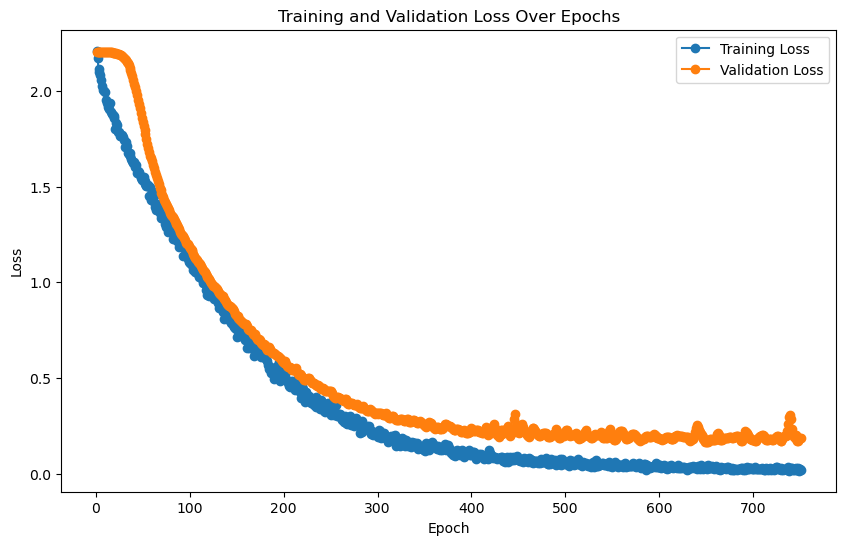

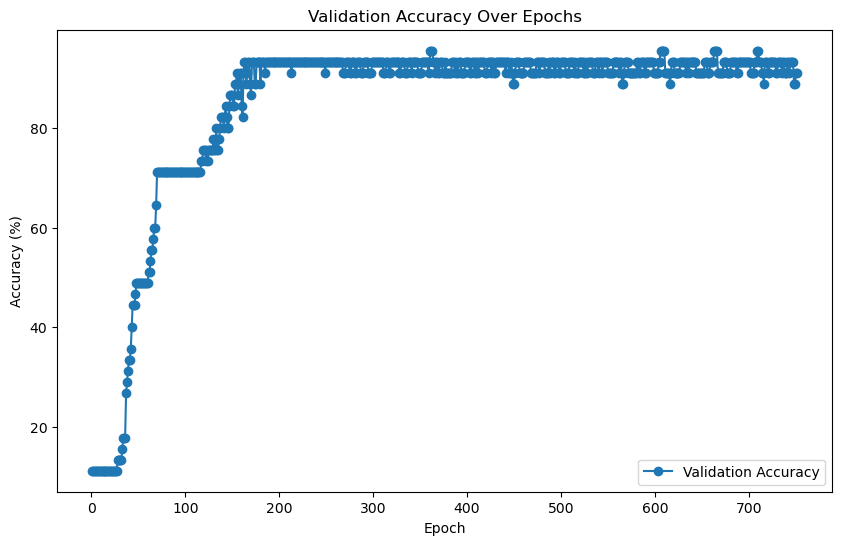


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.1003



Final Test Loss: 0.1002, Test Accuracy: 97.35%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.


  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.


  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.


  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.


  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.


  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.


  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.


  Processed batch 440/579 for test dataset.


  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.


  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148017, 64), Test labels shape: (148017,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.75      0.60      0.67         5
           3       0.80      0.80      0.80         5
           4       0.57      0.80      0.67         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148017, 64)
Test labels shape: (148017,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1886  |  Val Loss: 2.1024
Validation loss improved from inf to 2.1024.
[Epoch 2/1000] Train Loss: 2.0702  |  Val Loss: 2.0072
Validation loss improved from 2.1024 to 2.0072.
[Epoch 3/1000] Train Loss: 1.9658  |  Val Loss: 1.9263
Validation loss improved from 2.0072 to 1.9263.
[Epoch 4/1000] Train Loss: 1.8863  |  Val Loss: 1.8612
Validation loss improved from 1.9263 to 1.8612.
[Epoch 5/1000] Train Loss: 1.8108  |  Val Loss: 1.8032
Validation loss improved from 1.8612 to 1.8032.
[Epoch 6/1000] Train Loss: 1.7454  |  Val Loss: 1.7415
Validation loss improved from 1.8032 to 1.7415.
[Epoch 7/1000] Train Loss: 1.6790  |  Val Loss: 1.6773
Validation loss improved from 1.7415 to 1.6773.
[Epoch 8/1000] Train Loss: 1.6090  |  Val Loss: 1.6155
Validation loss improved from 1.6773 to 1.6155.


[Epoch 9/1000] Train Loss: 1.5426  |  Val Loss: 1.5529
Validation loss improved from 1.6155 to 1.5529.
[Epoch 10/1000] Train Loss: 1.4733  |  Val Loss: 1.4929
Validation loss improved from 1.5529 to 1.4929.
[Epoch 11/1000] Train Loss: 1.4020  |  Val Loss: 1.4345
Validation loss improved from 1.4929 to 1.4345.
[Epoch 12/1000] Train Loss: 1.3353  |  Val Loss: 1.3721
Validation loss improved from 1.4345 to 1.3721.
[Epoch 13/1000] Train Loss: 1.2654  |  Val Loss: 1.3111
Validation loss improved from 1.3721 to 1.3111.
[Epoch 14/1000] Train Loss: 1.1988  |  Val Loss: 1.2543
Validation loss improved from 1.3111 to 1.2543.
[Epoch 15/1000] Train Loss: 1.1358  |  Val Loss: 1.1983
Validation loss improved from 1.2543 to 1.1983.
[Epoch 16/1000] Train Loss: 1.0724  |  Val Loss: 1.1424
Validation loss improved from 1.1983 to 1.1424.
[Epoch 17/1000] Train Loss: 1.0084  |  Val Loss: 1.0880
Validation loss improved from 1.1424 to 1.0880.
[Epoch 18/1000] Train Loss: 0.9473  |  Val Loss: 1.0346
Validatio

[Epoch 49/1000] Train Loss: 0.1557  |  Val Loss: 0.3673
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 50/1000] Train Loss: 0.1477  |  Val Loss: 0.3567
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 51/1000] Train Loss: 0.1423  |  Val Loss: 0.3457
Validation loss improved from 0.3499 to 0.3457.
[Epoch 52/1000] Train Loss: 0.1348  |  Val Loss: 0.3443
Validation loss improved from 0.3457 to 0.3443.
[Epoch 53/1000] Train Loss: 0.1277  |  Val Loss: 0.3484
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 0.1237  |  Val Loss: 0.3505
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 0.1173  |  Val Loss: 0.3509
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 56/1000] Train Loss: 0.1129  |  Val Loss: 0.3522
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 57/1000] Train Loss: 0.1081  |  Val Loss: 0.3496
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 58/1000] Train 

[Epoch 93/1000] Train Loss: 0.0339  |  Val Loss: 0.3909
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 94/1000] Train Loss: 0.0336  |  Val Loss: 0.3980
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 95/1000] Train Loss: 0.0329  |  Val Loss: 0.4001
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 96/1000] Train Loss: 0.0322  |  Val Loss: 0.3984
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 97/1000] Train Loss: 0.0306  |  Val Loss: 0.3996
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 98/1000] Train Loss: 0.0297  |  Val Loss: 0.4011
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 99/1000] Train Loss: 0.0286  |  Val Loss: 0.4010
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 100/1000] Train Loss: 0.0283  |  Val Loss: 0.4008
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 101/1000] Train Loss: 0.0278  |  Val Loss: 0.4016
!! Validation loss did NOT improve !! Patience: 49/100

[Epoch 138/1000] Train Loss: 0.0123  |  Val Loss: 0.4412
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 139/1000] Train Loss: 0.0118  |  Val Loss: 0.4414
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 140/1000] Train Loss: 0.0116  |  Val Loss: 0.4427
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 141/1000] Train Loss: 0.0118  |  Val Loss: 0.4417
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 142/1000] Train Loss: 0.0114  |  Val Loss: 0.4393
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 143/1000] Train Loss: 0.0109  |  Val Loss: 0.4390
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 144/1000] Train Loss: 0.0108  |  Val Loss: 0.4429
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 145/1000] Train Loss: 0.0109  |  Val Loss: 0.4484
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 146/1000] Train Loss: 0.0107  |  Val Loss: 0.4518
!! Validation loss did NOT improve !! Patience:

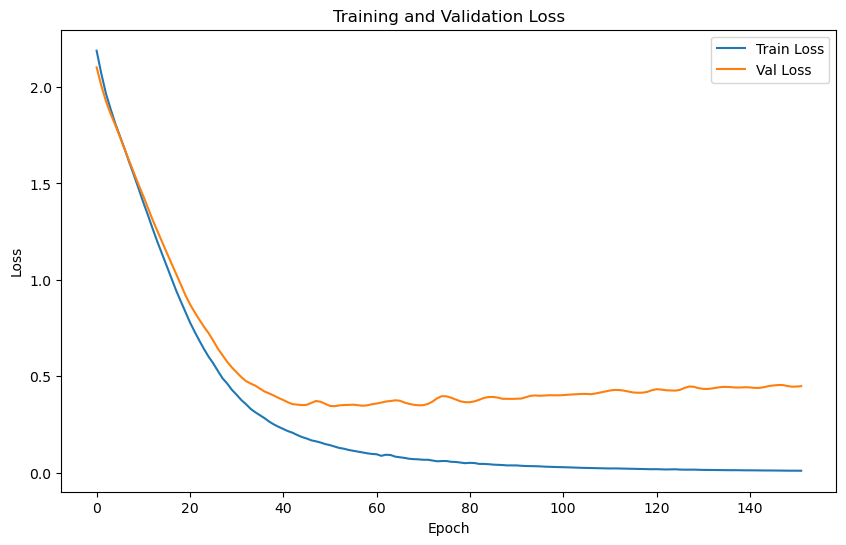

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2395 | Test Accuracy: 93.98%


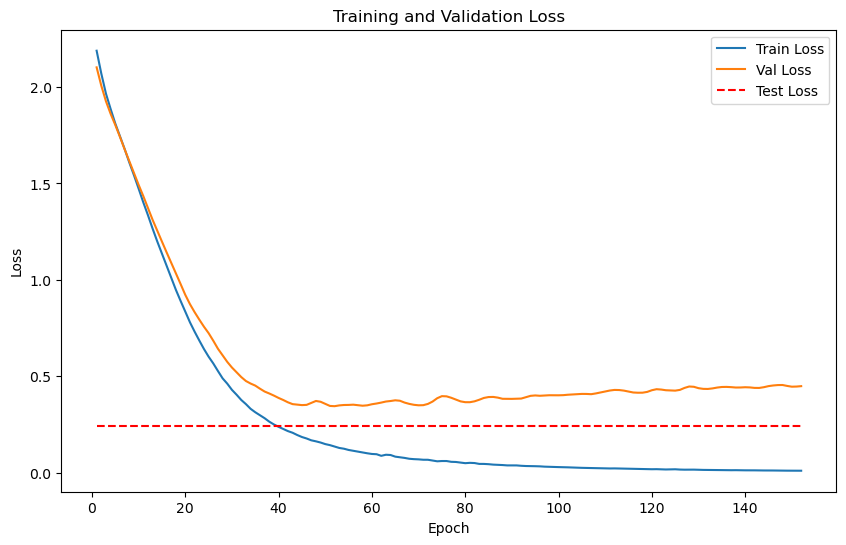

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.4853
Epoch [1/2000], Avg Train Loss: 8.4853


Epoch [1/2000], Avg Val Loss: 3.4619
Validation loss improved from inf to 3.4619. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3169
Epoch [2/2000], Avg Train Loss: 8.3169
Epoch [2/2000], Avg Val Loss: 3.4247
Validation loss improved from 3.4619 to 3.4247. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.2322
Epoch [3/2000], Avg Train Loss: 8.2322
Epoch [3/2000], Avg Val Loss: 3.3894
Validation loss improved from 3.4247 to 3.3894. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.2300
Epoch [4/2000], Avg Train Loss: 8.2300
Epoch [4/2000], Avg Val Loss: 3.3559
Validation loss improved from 3.3894 to 3.3559. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.4148
Epoch [5/2000], Avg Train Loss: 8.4148
Epoch [5/2000], Avg Val Loss: 3.3235
Validation loss improved from 3.3559 to 3.3235. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.1042
Ep

    Batch [1/1], Train Loss: 7.6166
Epoch [15/2000], Avg Train Loss: 7.6166
Epoch [15/2000], Avg Val Loss: 3.0508
Validation loss improved from 3.0740 to 3.0508. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.6155
Epoch [16/2000], Avg Train Loss: 7.6155
Epoch [16/2000], Avg Val Loss: 3.0284
Validation loss improved from 3.0508 to 3.0284. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.2819
Epoch [17/2000], Avg Train Loss: 7.2819
Epoch [17/2000], Avg Val Loss: 3.0069
Validation loss improved from 3.0284 to 3.0069. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.3023
Epoch [18/2000], Avg Train Loss: 7.3023
Epoch [18/2000], Avg Val Loss: 2.9864
Validation loss improved from 3.0069 to 2.9864. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.1472
Epoch [19/2000], Avg Train Loss: 7.1472
Epoch [19/2000], Avg Val Loss: 2.9669
Validation loss improved from 2.9864 to 2.

Epoch [45/2000], Avg Train Loss: 5.7732


Epoch [45/2000], Avg Val Loss: 2.6686
Validation loss improved from 2.6746 to 2.6686. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.6788
Epoch [46/2000], Avg Train Loss: 5.6788
Epoch [46/2000], Avg Val Loss: 2.6629
Validation loss improved from 2.6686 to 2.6629. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.5437
Epoch [47/2000], Avg Train Loss: 5.5437
Epoch [47/2000], Avg Val Loss: 2.6575
Validation loss improved from 2.6629 to 2.6575. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.6886
Epoch [48/2000], Avg Train Loss: 5.6886
Epoch [48/2000], Avg Val Loss: 2.6524
Validation loss improved from 2.6575 to 2.6524. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.4989
Epoch [49/2000], Avg Train Loss: 5.4989
Epoch [49/2000], Avg Val Loss: 2.6475
Validation loss improved from 2.6524 to 2.6475. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.1302
Epoch [61/2000], Avg Train Loss: 5.1302
Epoch [61/2000], Avg Val Loss: 2.6041
Validation loss improved from 2.6068 to 2.6041. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.1517
Epoch [62/2000], Avg Train Loss: 5.1517
Epoch [62/2000], Avg Val Loss: 2.6016
Validation loss improved from 2.6041 to 2.6016. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.0453
Epoch [63/2000], Avg Train Loss: 5.0453
Epoch [63/2000], Avg Val Loss: 2.5992
Validation loss improved from 2.6016 to 2.5992. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.0855
Epoch [64/2000], Avg Train Loss: 5.0855
Epoch [64/2000], Avg Val Loss: 2.5969
Validation loss improved from 2.5992 to 2.5969. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.2078
Epoch [65/2000], Avg Train Loss: 5.2078
Epoch [65/2000], Avg Val Loss: 2.5948
Validation loss improved from 2.5969 to 2.

Epoch [85/2000], Avg Val Loss: 2.5699
Validation loss improved from 2.5705 to 2.5699. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 4.4882
Epoch [86/2000], Avg Train Loss: 4.4882
Epoch [86/2000], Avg Val Loss: 2.5693
Validation loss improved from 2.5699 to 2.5693. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 4.5999
Epoch [87/2000], Avg Train Loss: 4.5999
Epoch [87/2000], Avg Val Loss: 2.5687
Validation loss improved from 2.5693 to 2.5687. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.5149
Epoch [88/2000], Avg Train Loss: 4.5149
Epoch [88/2000], Avg Val Loss: 2.5681
Validation loss improved from 2.5687 to 2.5681. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.5103
Epoch [89/2000], Avg Train Loss: 4.5103
Epoch [89/2000], Avg Val Loss: 2.5676
Validation loss improved from 2.5681 to 2.5676. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.2081
Epoch [108/2000], Avg Train Loss: 4.2081
Epoch [108/2000], Avg Val Loss: 2.5603
Validation loss improved from 2.5607 to 2.5603. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.2299
Epoch [109/2000], Avg Train Loss: 4.2299
Epoch [109/2000], Avg Val Loss: 2.5600
Validation loss improved from 2.5603 to 2.5600. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.2391
Epoch [110/2000], Avg Train Loss: 4.2391
Epoch [110/2000], Avg Val Loss: 2.5596
Validation loss improved from 2.5600 to 2.5596. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.2952
Epoch [111/2000], Avg Train Loss: 4.2952
Epoch [111/2000], Avg Val Loss: 2.5593
Validation loss improved from 2.5596 to 2.5593. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.2328
Epoch [112/2000], Avg Train Loss: 4.2328
Epoch [112/2000], Avg Val Loss: 2.5590
Validation loss improved fro

Epoch [129/2000], Avg Val Loss: 2.5538
Validation loss improved from 2.5541 to 2.5538. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.0548
Epoch [130/2000], Avg Train Loss: 4.0548
Epoch [130/2000], Avg Val Loss: 2.5534
Validation loss improved from 2.5538 to 2.5534. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.0795
Epoch [131/2000], Avg Train Loss: 4.0795
Epoch [131/2000], Avg Val Loss: 2.5531
Validation loss improved from 2.5534 to 2.5531. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.0330
Epoch [132/2000], Avg Train Loss: 4.0330
Epoch [132/2000], Avg Val Loss: 2.5527
Validation loss improved from 2.5531 to 2.5527. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.1322
Epoch [133/2000], Avg Train Loss: 4.1322
Epoch [133/2000], Avg Val Loss: 2.5523
Validation loss improved from 2.5527 to 2.5523. Saving model...

LOG: Epoch [134/2000] - Training
    Bat

Epoch [150/2000], Avg Val Loss: 2.5446
Validation loss improved from 2.5451 to 2.5446. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.0046
Epoch [151/2000], Avg Train Loss: 4.0046
Epoch [151/2000], Avg Val Loss: 2.5441
Validation loss improved from 2.5446 to 2.5441. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 3.9677
Epoch [152/2000], Avg Train Loss: 3.9677
Epoch [152/2000], Avg Val Loss: 2.5436
Validation loss improved from 2.5441 to 2.5436. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 3.9959
Epoch [153/2000], Avg Train Loss: 3.9959
Epoch [153/2000], Avg Val Loss: 2.5431
Validation loss improved from 2.5436 to 2.5431. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 3.9448
Epoch [154/2000], Avg Train Loss: 3.9448
Epoch [154/2000], Avg Val Loss: 2.5426
Validation loss improved from 2.5431 to 2.5426. Saving model...

LOG: Epoch [155/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8740
Epoch [176/2000], Avg Train Loss: 3.8740
Epoch [176/2000], Avg Val Loss: 2.5313
Validation loss improved from 2.5318 to 2.5313. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 3.7844
Epoch [177/2000], Avg Train Loss: 3.7844
Epoch [177/2000], Avg Val Loss: 2.5307
Validation loss improved from 2.5313 to 2.5307. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 3.7829
Epoch [178/2000], Avg Train Loss: 3.7829
Epoch [178/2000], Avg Val Loss: 2.5301
Validation loss improved from 2.5307 to 2.5301. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 3.8535
Epoch [179/2000], Avg Train Loss: 3.8535
Epoch [179/2000], Avg Val Loss: 2.5295
Validation loss improved from 2.5301 to 2.5295. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 3.9870
Epoch [180/2000], Avg Train Loss: 3.9870
Epoch [180/2000], Avg Val Loss: 2.5290
Validation loss improved fro

Epoch [198/2000], Avg Val Loss: 2.5180
Validation loss improved from 2.5186 to 2.5180. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 3.7264
Epoch [199/2000], Avg Train Loss: 3.7264
Epoch [199/2000], Avg Val Loss: 2.5174
Validation loss improved from 2.5180 to 2.5174. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 3.8143
Epoch [200/2000], Avg Train Loss: 3.8143
Epoch [200/2000], Avg Val Loss: 2.5167
Validation loss improved from 2.5174 to 2.5167. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 3.7475
Epoch [201/2000], Avg Train Loss: 3.7475
Epoch [201/2000], Avg Val Loss: 2.5161
Validation loss improved from 2.5167 to 2.5161. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 3.7694
Epoch [202/2000], Avg Train Loss: 3.7694
Epoch [202/2000], Avg Val Loss: 2.5154
Validation loss improved from 2.5161 to 2.5154. Saving model...

LOG: Epoch [203/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7447
Epoch [225/2000], Avg Train Loss: 3.7447
Epoch [225/2000], Avg Val Loss: 2.4996
Validation loss improved from 2.5003 to 2.4996. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 3.6777
Epoch [226/2000], Avg Train Loss: 3.6777
Epoch [226/2000], Avg Val Loss: 2.4989
Validation loss improved from 2.4996 to 2.4989. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 3.6582
Epoch [227/2000], Avg Train Loss: 3.6582
Epoch [227/2000], Avg Val Loss: 2.4982
Validation loss improved from 2.4989 to 2.4982. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 3.6954
Epoch [228/2000], Avg Train Loss: 3.6954
Epoch [228/2000], Avg Val Loss: 2.4975
Validation loss improved from 2.4982 to 2.4975. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 3.7570
Epoch [229/2000], Avg Train Loss: 3.7570
Epoch [229/2000], Avg Val Loss: 2.4968
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5600
Epoch [246/2000], Avg Train Loss: 3.5600
Epoch [246/2000], Avg Val Loss: 2.4845
Validation loss improved from 2.4853 to 2.4845. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 3.7143
Epoch [247/2000], Avg Train Loss: 3.7143
Epoch [247/2000], Avg Val Loss: 2.4837
Validation loss improved from 2.4845 to 2.4837. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 3.6750
Epoch [248/2000], Avg Train Loss: 3.6750
Epoch [248/2000], Avg Val Loss: 2.4830
Validation loss improved from 2.4837 to 2.4830. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 3.6925
Epoch [249/2000], Avg Train Loss: 3.6925
Epoch [249/2000], Avg Val Loss: 2.4822
Validation loss improved from 2.4830 to 2.4822. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 3.7259
Epoch [250/2000], Avg Train Loss: 3.7259
Epoch [250/2000], Avg Val Loss: 2.4815
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5701
Epoch [275/2000], Avg Train Loss: 3.5701
Epoch [275/2000], Avg Val Loss: 2.4634
Validation loss improved from 2.4641 to 2.4634. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 3.6217
Epoch [276/2000], Avg Train Loss: 3.6217
Epoch [276/2000], Avg Val Loss: 2.4627
Validation loss improved from 2.4634 to 2.4627. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 3.6506
Epoch [277/2000], Avg Train Loss: 3.6506
Epoch [277/2000], Avg Val Loss: 2.4621
Validation loss improved from 2.4627 to 2.4621. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.6010
Epoch [278/2000], Avg Train Loss: 3.6010
Epoch [278/2000], Avg Val Loss: 2.4614
Validation loss improved from 2.4621 to 2.4614. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.5738
Epoch [279/2000], Avg Train Loss: 3.5738
Epoch [279/2000], Avg Val Loss: 2.4607
Validation loss improved fro

Epoch [297/2000], Avg Val Loss: 2.4483
Validation loss improved from 2.4490 to 2.4483. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.4650
Epoch [298/2000], Avg Train Loss: 3.4650
Epoch [298/2000], Avg Val Loss: 2.4476
Validation loss improved from 2.4483 to 2.4476. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.5954
Epoch [299/2000], Avg Train Loss: 3.5954
Epoch [299/2000], Avg Val Loss: 2.4469
Validation loss improved from 2.4476 to 2.4469. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.4866
Epoch [300/2000], Avg Train Loss: 3.4866
Epoch [300/2000], Avg Val Loss: 2.4462
Validation loss improved from 2.4469 to 2.4462. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.5556
Epoch [301/2000], Avg Train Loss: 3.5556
Epoch [301/2000], Avg Val Loss: 2.4455
Validation loss improved from 2.4462 to 2.4455. Saving model...

LOG: Epoch [302/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5007
Epoch [326/2000], Avg Train Loss: 3.5007
Epoch [326/2000], Avg Val Loss: 2.4289
Validation loss improved from 2.4296 to 2.4289. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.5042
Epoch [327/2000], Avg Train Loss: 3.5042
Epoch [327/2000], Avg Val Loss: 2.4283
Validation loss improved from 2.4289 to 2.4283. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.4709
Epoch [328/2000], Avg Train Loss: 3.4709
Epoch [328/2000], Avg Val Loss: 2.4276
Validation loss improved from 2.4283 to 2.4276. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.4829
Epoch [329/2000], Avg Train Loss: 3.4829
Epoch [329/2000], Avg Val Loss: 2.4269
Validation loss improved from 2.4276 to 2.4269. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.4674
Epoch [330/2000], Avg Train Loss: 3.4674
Epoch [330/2000], Avg Val Loss: 2.4261
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4826
Epoch [347/2000], Avg Train Loss: 3.4826
Epoch [347/2000], Avg Val Loss: 2.4144
Validation loss improved from 2.4151 to 2.4144. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.4499
Epoch [348/2000], Avg Train Loss: 3.4499
Epoch [348/2000], Avg Val Loss: 2.4137
Validation loss improved from 2.4144 to 2.4137. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.4708
Epoch [349/2000], Avg Train Loss: 3.4708
Epoch [349/2000], Avg Val Loss: 2.4130
Validation loss improved from 2.4137 to 2.4130. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.4603
Epoch [350/2000], Avg Train Loss: 3.4603
Epoch [350/2000], Avg Val Loss: 2.4124
Validation loss improved from 2.4130 to 2.4124. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 3.4509
Epoch [351/2000], Avg Train Loss: 3.4509
Epoch [351/2000], Avg Val Loss: 2.4117
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3793
Epoch [372/2000], Avg Train Loss: 3.3793
Epoch [372/2000], Avg Val Loss: 2.3984
Validation loss improved from 2.3990 to 2.3984. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.3607
Epoch [373/2000], Avg Train Loss: 3.3607
Epoch [373/2000], Avg Val Loss: 2.3978
Validation loss improved from 2.3984 to 2.3978. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.3796
Epoch [374/2000], Avg Train Loss: 3.3796
Epoch [374/2000], Avg Val Loss: 2.3971
Validation loss improved from 2.3978 to 2.3971. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.3939
Epoch [375/2000], Avg Train Loss: 3.3939
Epoch [375/2000], Avg Val Loss: 2.3965
Validation loss improved from 2.3971 to 2.3965. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 3.4471
Epoch [376/2000], Avg Train Loss: 3.4471
Epoch [376/2000], Avg Val Loss: 2.3959
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4408
Epoch [395/2000], Avg Train Loss: 3.4408
Epoch [395/2000], Avg Val Loss: 2.3846
Validation loss improved from 2.3852 to 2.3846. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.4402
Epoch [396/2000], Avg Train Loss: 3.4402
Epoch [396/2000], Avg Val Loss: 2.3840
Validation loss improved from 2.3846 to 2.3840. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.3684
Epoch [397/2000], Avg Train Loss: 3.3684
Epoch [397/2000], Avg Val Loss: 2.3835
Validation loss improved from 2.3840 to 2.3835. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 3.4111
Epoch [398/2000], Avg Train Loss: 3.4111
Epoch [398/2000], Avg Val Loss: 2.3829
Validation loss improved from 2.3835 to 2.3829. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 3.3926
Epoch [399/2000], Avg Train Loss: 3.3926
Epoch [399/2000], Avg Val Loss: 2.3823
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3086
Epoch [420/2000], Avg Train Loss: 3.3086
Epoch [420/2000], Avg Val Loss: 2.3707
Validation loss improved from 2.3712 to 2.3707. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 3.4082
Epoch [421/2000], Avg Train Loss: 3.4082
Epoch [421/2000], Avg Val Loss: 2.3702
Validation loss improved from 2.3707 to 2.3702. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 3.3534
Epoch [422/2000], Avg Train Loss: 3.3534
Epoch [422/2000], Avg Val Loss: 2.3696
Validation loss improved from 2.3702 to 2.3696. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.3360
Epoch [423/2000], Avg Train Loss: 3.3360
Epoch [423/2000], Avg Val Loss: 2.3691
Validation loss improved from 2.3696 to 2.3691. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 3.3050
Epoch [424/2000], Avg Train Loss: 3.3050
Epoch [424/2000], Avg Val Loss: 2.3685
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2682
Epoch [437/2000], Avg Train Loss: 3.2682
Epoch [437/2000], Avg Val Loss: 2.3614
Validation loss improved from 2.3620 to 2.3614. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.3678
Epoch [438/2000], Avg Train Loss: 3.3678
Epoch [438/2000], Avg Val Loss: 2.3609
Validation loss improved from 2.3614 to 2.3609. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.3441
Epoch [439/2000], Avg Train Loss: 3.3441
Epoch [439/2000], Avg Val Loss: 2.3604
Validation loss improved from 2.3609 to 2.3604. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.2902
Epoch [440/2000], Avg Train Loss: 3.2902
Epoch [440/2000], Avg Val Loss: 2.3598
Validation loss improved from 2.3604 to 2.3598. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.3413
Epoch [441/2000], Avg Train Loss: 3.3413
Epoch [441/2000], Avg Val Loss: 2.3593
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2784
Epoch [468/2000], Avg Train Loss: 3.2784
Epoch [468/2000], Avg Val Loss: 2.3453
Validation loss improved from 2.3458 to 2.3453. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 3.2942
Epoch [469/2000], Avg Train Loss: 3.2942
Epoch [469/2000], Avg Val Loss: 2.3448
Validation loss improved from 2.3453 to 2.3448. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 3.3366
Epoch [470/2000], Avg Train Loss: 3.3366
Epoch [470/2000], Avg Val Loss: 2.3444
Validation loss improved from 2.3448 to 2.3444. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 3.3037
Epoch [471/2000], Avg Train Loss: 3.3037
Epoch [471/2000], Avg Val Loss: 2.3439
Validation loss improved from 2.3444 to 2.3439. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 3.3064
Epoch [472/2000], Avg Train Loss: 3.3064
Epoch [472/2000], Avg Val Loss: 2.3435
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2563
Epoch [485/2000], Avg Train Loss: 3.2563
Epoch [485/2000], Avg Val Loss: 2.3377
Validation loss improved from 2.3382 to 2.3377. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.3165
Epoch [486/2000], Avg Train Loss: 3.3165
Epoch [486/2000], Avg Val Loss: 2.3373
Validation loss improved from 2.3377 to 2.3373. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 3.2549
Epoch [487/2000], Avg Train Loss: 3.2549
Epoch [487/2000], Avg Val Loss: 2.3369
Validation loss improved from 2.3373 to 2.3369. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 3.2976
Epoch [488/2000], Avg Train Loss: 3.2976
Epoch [488/2000], Avg Val Loss: 2.3364
Validation loss improved from 2.3369 to 2.3364. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 3.3228
Epoch [489/2000], Avg Train Loss: 3.3228
Epoch [489/2000], Avg Val Loss: 2.3360
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2039
Epoch [516/2000], Avg Train Loss: 3.2039
Epoch [516/2000], Avg Val Loss: 2.3242
Validation loss improved from 2.3246 to 2.3242. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 3.2702
Epoch [517/2000], Avg Train Loss: 3.2702
Epoch [517/2000], Avg Val Loss: 2.3238
Validation loss improved from 2.3242 to 2.3238. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.2212
Epoch [518/2000], Avg Train Loss: 3.2212
Epoch [518/2000], Avg Val Loss: 2.3234
Validation loss improved from 2.3238 to 2.3234. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.2692
Epoch [519/2000], Avg Train Loss: 3.2692
Epoch [519/2000], Avg Val Loss: 2.3230
Validation loss improved from 2.3234 to 2.3230. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 3.2766
Epoch [520/2000], Avg Train Loss: 3.2766
Epoch [520/2000], Avg Val Loss: 2.3226
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2254
Epoch [533/2000], Avg Train Loss: 3.2254
Epoch [533/2000], Avg Val Loss: 2.3170
Validation loss improved from 2.3175 to 2.3170. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 3.2580
Epoch [534/2000], Avg Train Loss: 3.2580
Epoch [534/2000], Avg Val Loss: 2.3166
Validation loss improved from 2.3170 to 2.3166. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 3.2303
Epoch [535/2000], Avg Train Loss: 3.2303
Epoch [535/2000], Avg Val Loss: 2.3162
Validation loss improved from 2.3166 to 2.3162. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 3.2139
Epoch [536/2000], Avg Train Loss: 3.2139
Epoch [536/2000], Avg Val Loss: 2.3158
Validation loss improved from 2.3162 to 2.3158. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 3.2488
Epoch [537/2000], Avg Train Loss: 3.2488
Epoch [537/2000], Avg Val Loss: 2.3154
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1582
Epoch [563/2000], Avg Train Loss: 3.1582
Epoch [563/2000], Avg Val Loss: 2.3039
Validation loss improved from 2.3043 to 2.3039. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.2343
Epoch [564/2000], Avg Train Loss: 3.2343
Epoch [564/2000], Avg Val Loss: 2.3035
Validation loss improved from 2.3039 to 2.3035. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 3.2155
Epoch [565/2000], Avg Train Loss: 3.2155
Epoch [565/2000], Avg Val Loss: 2.3031
Validation loss improved from 2.3035 to 2.3031. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 3.2299
Epoch [566/2000], Avg Train Loss: 3.2299
Epoch [566/2000], Avg Val Loss: 2.3027
Validation loss improved from 2.3031 to 2.3027. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 3.1796
Epoch [567/2000], Avg Train Loss: 3.1796
Epoch [567/2000], Avg Val Loss: 2.3023
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1913
Epoch [581/2000], Avg Train Loss: 3.1913
Epoch [581/2000], Avg Val Loss: 2.2963
Validation loss improved from 2.2967 to 2.2963. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 3.2196
Epoch [582/2000], Avg Train Loss: 3.2196
Epoch [582/2000], Avg Val Loss: 2.2959
Validation loss improved from 2.2963 to 2.2959. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 3.2010
Epoch [583/2000], Avg Train Loss: 3.2010
Epoch [583/2000], Avg Val Loss: 2.2954
Validation loss improved from 2.2959 to 2.2954. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 3.1620
Epoch [584/2000], Avg Train Loss: 3.1620
Epoch [584/2000], Avg Val Loss: 2.2950
Validation loss improved from 2.2954 to 2.2950. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 3.1970
Epoch [585/2000], Avg Train Loss: 3.1970
Epoch [585/2000], Avg Val Loss: 2.2946
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1069
Epoch [610/2000], Avg Train Loss: 3.1069
Epoch [610/2000], Avg Val Loss: 2.2846
Validation loss improved from 2.2850 to 2.2846. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.1707
Epoch [611/2000], Avg Train Loss: 3.1707
Epoch [611/2000], Avg Val Loss: 2.2842
Validation loss improved from 2.2846 to 2.2842. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.1074
Epoch [612/2000], Avg Train Loss: 3.1074
Epoch [612/2000], Avg Val Loss: 2.2839
Validation loss improved from 2.2842 to 2.2839. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.1639
Epoch [613/2000], Avg Train Loss: 3.1639
Epoch [613/2000], Avg Val Loss: 2.2835
Validation loss improved from 2.2839 to 2.2835. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.1334
Epoch [614/2000], Avg Train Loss: 3.1334
Epoch [614/2000], Avg Val Loss: 2.2831
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1659
Epoch [628/2000], Avg Train Loss: 3.1659
Epoch [628/2000], Avg Val Loss: 2.2781
Validation loss improved from 2.2785 to 2.2781. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 3.1333
Epoch [629/2000], Avg Train Loss: 3.1333
Epoch [629/2000], Avg Val Loss: 2.2778
Validation loss improved from 2.2781 to 2.2778. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 3.1344
Epoch [630/2000], Avg Train Loss: 3.1344
Epoch [630/2000], Avg Val Loss: 2.2774
Validation loss improved from 2.2778 to 2.2774. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 3.1228
Epoch [631/2000], Avg Train Loss: 3.1228
Epoch [631/2000], Avg Val Loss: 2.2770
Validation loss improved from 2.2774 to 2.2770. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.1805
Epoch [632/2000], Avg Train Loss: 3.1805
Epoch [632/2000], Avg Val Loss: 2.2767
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1036
Epoch [654/2000], Avg Train Loss: 3.1036
Epoch [654/2000], Avg Val Loss: 2.2691
Validation loss improved from 2.2694 to 2.2691. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.1658
Epoch [655/2000], Avg Train Loss: 3.1658
Epoch [655/2000], Avg Val Loss: 2.2688
Validation loss improved from 2.2691 to 2.2688. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.1683
Epoch [656/2000], Avg Train Loss: 3.1683
Epoch [656/2000], Avg Val Loss: 2.2684
Validation loss improved from 2.2688 to 2.2684. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.1058
Epoch [657/2000], Avg Train Loss: 3.1058
Epoch [657/2000], Avg Val Loss: 2.2681
Validation loss improved from 2.2684 to 2.2681. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 3.1347
Epoch [658/2000], Avg Train Loss: 3.1347
Epoch [658/2000], Avg Val Loss: 2.2677
Validation loss improved fro

Epoch [673/2000], Avg Val Loss: 2.2629
Validation loss improved from 2.2632 to 2.2629. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.1444
Epoch [674/2000], Avg Train Loss: 3.1444
Epoch [674/2000], Avg Val Loss: 2.2626
Validation loss improved from 2.2629 to 2.2626. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.1208
Epoch [675/2000], Avg Train Loss: 3.1208
Epoch [675/2000], Avg Val Loss: 2.2622
Validation loss improved from 2.2626 to 2.2622. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.1867
Epoch [676/2000], Avg Train Loss: 3.1867
Epoch [676/2000], Avg Val Loss: 2.2619
Validation loss improved from 2.2622 to 2.2619. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.1105
Epoch [677/2000], Avg Train Loss: 3.1105
Epoch [677/2000], Avg Val Loss: 2.2615
Validation loss improved from 2.2619 to 2.2615. Saving model...

LOG: Epoch [678/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0992
Epoch [698/2000], Avg Train Loss: 3.0992
Epoch [698/2000], Avg Val Loss: 2.2552
Validation loss improved from 2.2555 to 2.2552. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.0763
Epoch [699/2000], Avg Train Loss: 3.0763
Epoch [699/2000], Avg Val Loss: 2.2550
Validation loss improved from 2.2552 to 2.2550. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.0428
Epoch [700/2000], Avg Train Loss: 3.0428
Epoch [700/2000], Avg Val Loss: 2.2547
Validation loss improved from 2.2550 to 2.2547. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.0925
Epoch [701/2000], Avg Train Loss: 3.0925
Epoch [701/2000], Avg Val Loss: 2.2544
Validation loss improved from 2.2547 to 2.2544. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.0947
Epoch [702/2000], Avg Train Loss: 3.0947
Epoch [702/2000], Avg Val Loss: 2.2541
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0588
Epoch [722/2000], Avg Train Loss: 3.0588
Epoch [722/2000], Avg Val Loss: 2.2481
Validation loss improved from 2.2484 to 2.2481. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 3.1064
Epoch [723/2000], Avg Train Loss: 3.1064
Epoch [723/2000], Avg Val Loss: 2.2478
Validation loss improved from 2.2481 to 2.2478. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.0889
Epoch [724/2000], Avg Train Loss: 3.0889
Epoch [724/2000], Avg Val Loss: 2.2475
Validation loss improved from 2.2478 to 2.2475. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.0468
Epoch [725/2000], Avg Train Loss: 3.0468
Epoch [725/2000], Avg Val Loss: 2.2472
Validation loss improved from 2.2475 to 2.2472. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.0820
Epoch [726/2000], Avg Train Loss: 3.0820
Epoch [726/2000], Avg Val Loss: 2.2469
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0752
Epoch [744/2000], Avg Train Loss: 3.0752
Epoch [744/2000], Avg Val Loss: 2.2416
Validation loss improved from 2.2419 to 2.2416. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.0354
Epoch [745/2000], Avg Train Loss: 3.0354
Epoch [745/2000], Avg Val Loss: 2.2414
Validation loss improved from 2.2416 to 2.2414. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.0726
Epoch [746/2000], Avg Train Loss: 3.0726
Epoch [746/2000], Avg Val Loss: 2.2411
Validation loss improved from 2.2414 to 2.2411. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.0671
Epoch [747/2000], Avg Train Loss: 3.0671
Epoch [747/2000], Avg Val Loss: 2.2409
Validation loss improved from 2.2411 to 2.2409. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 3.0484
Epoch [748/2000], Avg Train Loss: 3.0484
Epoch [748/2000], Avg Val Loss: 2.2406
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0497
Epoch [765/2000], Avg Train Loss: 3.0497
Epoch [765/2000], Avg Val Loss: 2.2369
Validation loss improved from 2.2371 to 2.2369. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 3.0321
Epoch [766/2000], Avg Train Loss: 3.0321
Epoch [766/2000], Avg Val Loss: 2.2367
Validation loss improved from 2.2369 to 2.2367. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 3.1001
Epoch [767/2000], Avg Train Loss: 3.1001
Epoch [767/2000], Avg Val Loss: 2.2364
Validation loss improved from 2.2367 to 2.2364. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 3.0452
Epoch [768/2000], Avg Train Loss: 3.0452
Epoch [768/2000], Avg Val Loss: 2.2362
Validation loss improved from 2.2364 to 2.2362. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.0888
Epoch [769/2000], Avg Train Loss: 3.0888
Epoch [769/2000], Avg Val Loss: 2.2360
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9981
Epoch [789/2000], Avg Train Loss: 2.9981
Epoch [789/2000], Avg Val Loss: 2.2317
Validation loss improved from 2.2319 to 2.2317. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.0098
Epoch [790/2000], Avg Train Loss: 3.0098
Epoch [790/2000], Avg Val Loss: 2.2315
Validation loss improved from 2.2317 to 2.2315. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.0247
Epoch [791/2000], Avg Train Loss: 3.0247
Epoch [791/2000], Avg Val Loss: 2.2312
Validation loss improved from 2.2315 to 2.2312. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.0532
Epoch [792/2000], Avg Train Loss: 3.0532
Epoch [792/2000], Avg Val Loss: 2.2310
Validation loss improved from 2.2312 to 2.2310. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 3.0578
Epoch [793/2000], Avg Train Loss: 3.0578
Epoch [793/2000], Avg Val Loss: 2.2308
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0240
Epoch [814/2000], Avg Train Loss: 3.0240
Epoch [814/2000], Avg Val Loss: 2.2270
Validation loss improved from 2.2271 to 2.2270. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.0378
Epoch [815/2000], Avg Train Loss: 3.0378
Epoch [815/2000], Avg Val Loss: 2.2268
Validation loss improved from 2.2270 to 2.2268. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.0426
Epoch [816/2000], Avg Train Loss: 3.0426
Epoch [816/2000], Avg Val Loss: 2.2266
Validation loss improved from 2.2268 to 2.2266. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.0885
Epoch [817/2000], Avg Train Loss: 3.0885
Epoch [817/2000], Avg Val Loss: 2.2264
Validation loss improved from 2.2266 to 2.2264. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 3.0706
Epoch [818/2000], Avg Train Loss: 3.0706
Epoch [818/2000], Avg Val Loss: 2.2261
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0069
Epoch [836/2000], Avg Train Loss: 3.0069
Epoch [836/2000], Avg Val Loss: 2.2218
Validation loss improved from 2.2221 to 2.2218. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 3.0953
Epoch [837/2000], Avg Train Loss: 3.0953
Epoch [837/2000], Avg Val Loss: 2.2216
Validation loss improved from 2.2218 to 2.2216. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 2.9927
Epoch [838/2000], Avg Train Loss: 2.9927
Epoch [838/2000], Avg Val Loss: 2.2213
Validation loss improved from 2.2216 to 2.2213. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.0200
Epoch [839/2000], Avg Train Loss: 3.0200
Epoch [839/2000], Avg Val Loss: 2.2211
Validation loss improved from 2.2213 to 2.2211. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.0945
Epoch [840/2000], Avg Train Loss: 3.0945
Epoch [840/2000], Avg Val Loss: 2.2210
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0100
Epoch [859/2000], Avg Train Loss: 3.0100
Epoch [859/2000], Avg Val Loss: 2.2166
Validation loss improved from 2.2169 to 2.2166. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 2.9757
Epoch [860/2000], Avg Train Loss: 2.9757
Epoch [860/2000], Avg Val Loss: 2.2163
Validation loss improved from 2.2166 to 2.2163. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 2.9936
Epoch [861/2000], Avg Train Loss: 2.9936
Epoch [861/2000], Avg Val Loss: 2.2160
Validation loss improved from 2.2163 to 2.2160. Saving model...

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 2.9839
Epoch [862/2000], Avg Train Loss: 2.9839
Epoch [862/2000], Avg Val Loss: 2.2157
Validation loss improved from 2.2160 to 2.2157. Saving model...

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 3.0076
Epoch [863/2000], Avg Train Loss: 3.0076
Epoch [863/2000], Avg Val Loss: 2.2155
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9666
Epoch [881/2000], Avg Train Loss: 2.9666
Epoch [881/2000], Avg Val Loss: 2.2109
Validation loss improved from 2.2112 to 2.2109. Saving model...

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 2.9743
Epoch [882/2000], Avg Train Loss: 2.9743
Epoch [882/2000], Avg Val Loss: 2.2107
Validation loss improved from 2.2109 to 2.2107. Saving model...

LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 2.9460
Epoch [883/2000], Avg Train Loss: 2.9460
Epoch [883/2000], Avg Val Loss: 2.2104
Validation loss improved from 2.2107 to 2.2104. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 2.9932
Epoch [884/2000], Avg Train Loss: 2.9932
Epoch [884/2000], Avg Val Loss: 2.2102
Validation loss improved from 2.2104 to 2.2102. Saving model...

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 2.9440
Epoch [885/2000], Avg Train Loss: 2.9440
Epoch [885/2000], Avg Val Loss: 2.2100
Validation loss improved fro

Epoch [901/2000], Avg Val Loss: 2.2056
Validation loss improved from 2.2059 to 2.2056. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.0153
Epoch [902/2000], Avg Train Loss: 3.0153
Epoch [902/2000], Avg Val Loss: 2.2054
Validation loss improved from 2.2056 to 2.2054. Saving model...

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 2.9487
Epoch [903/2000], Avg Train Loss: 2.9487
Epoch [903/2000], Avg Val Loss: 2.2052
Validation loss improved from 2.2054 to 2.2052. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 2.9379
Epoch [904/2000], Avg Train Loss: 2.9379
Epoch [904/2000], Avg Val Loss: 2.2049
Validation loss improved from 2.2052 to 2.2049. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 3.0078
Epoch [905/2000], Avg Train Loss: 3.0078
Epoch [905/2000], Avg Val Loss: 2.2047
Validation loss improved from 2.2049 to 2.2047. Saving model...

LOG: Epoch [906/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9653
Epoch [926/2000], Avg Train Loss: 2.9653
Epoch [926/2000], Avg Val Loss: 2.2009
Validation loss improved from 2.2011 to 2.2009. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 2.9666
Epoch [927/2000], Avg Train Loss: 2.9666
Epoch [927/2000], Avg Val Loss: 2.2007
Validation loss improved from 2.2009 to 2.2007. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 2.9472
Epoch [928/2000], Avg Train Loss: 2.9472
Epoch [928/2000], Avg Val Loss: 2.2005
Validation loss improved from 2.2007 to 2.2005. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 2.9379
Epoch [929/2000], Avg Train Loss: 2.9379
Epoch [929/2000], Avg Val Loss: 2.2004
Validation loss improved from 2.2005 to 2.2004. Saving model...

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 2.9735
Epoch [930/2000], Avg Train Loss: 2.9735
Epoch [930/2000], Avg Val Loss: 2.2002
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9373
Epoch [952/2000], Avg Train Loss: 2.9373
Epoch [952/2000], Avg Val Loss: 2.1967
Validation loss improved from 2.1968 to 2.1967. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 2.9409
Epoch [953/2000], Avg Train Loss: 2.9409
Epoch [953/2000], Avg Val Loss: 2.1967
Validation loss improved from 2.1967 to 2.1967. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 2.9470
Epoch [954/2000], Avg Train Loss: 2.9470
Epoch [954/2000], Avg Val Loss: 2.1966
Validation loss improved from 2.1967 to 2.1966. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 2.9100
Epoch [955/2000], Avg Train Loss: 2.9100
Epoch [955/2000], Avg Val Loss: 2.1965
Validation loss improved from 2.1966 to 2.1965. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 2.9095
Epoch [956/2000], Avg Train Loss: 2.9095
Epoch [956/2000], Avg Val Loss: 2.1964
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9352
Epoch [972/2000], Avg Train Loss: 2.9352
Epoch [972/2000], Avg Val Loss: 2.1949
Validation loss improved from 2.1950 to 2.1949. Saving model...

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 2.9826
Epoch [973/2000], Avg Train Loss: 2.9826
Epoch [973/2000], Avg Val Loss: 2.1947
Validation loss improved from 2.1949 to 2.1947. Saving model...

LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 2.9176
Epoch [974/2000], Avg Train Loss: 2.9176
Epoch [974/2000], Avg Val Loss: 2.1945
Validation loss improved from 2.1947 to 2.1945. Saving model...

LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 2.9427
Epoch [975/2000], Avg Train Loss: 2.9427
Epoch [975/2000], Avg Val Loss: 2.1942
Validation loss improved from 2.1945 to 2.1942. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 2.8966
Epoch [976/2000], Avg Train Loss: 2.8966
Epoch [976/2000], Avg Val Loss: 2.1940
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9443
Epoch [996/2000], Avg Train Loss: 2.9443
Epoch [996/2000], Avg Val Loss: 2.1897
Validation loss improved from 2.1898 to 2.1897. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 2.9389
Epoch [997/2000], Avg Train Loss: 2.9389
Epoch [997/2000], Avg Val Loss: 2.1895
Validation loss improved from 2.1897 to 2.1895. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 2.9492
Epoch [998/2000], Avg Train Loss: 2.9492
Epoch [998/2000], Avg Val Loss: 2.1893
Validation loss improved from 2.1895 to 2.1893. Saving model...

LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 2.9624
Epoch [999/2000], Avg Train Loss: 2.9624
Epoch [999/2000], Avg Val Loss: 2.1892
Validation loss improved from 2.1893 to 2.1892. Saving model...

LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 2.8807
Epoch [1000/2000], Avg Train Loss: 2.8807
Epoch [1000/2000], Avg Val Loss: 2.1890
Validation loss improved 

    Batch [1/1], Train Loss: 2.8955
Epoch [1016/2000], Avg Train Loss: 2.8955
Epoch [1016/2000], Avg Val Loss: 2.1875
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 2.9263
Epoch [1017/2000], Avg Train Loss: 2.9263
Epoch [1017/2000], Avg Val Loss: 2.1875
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 2.9200
Epoch [1018/2000], Avg Train Loss: 2.9200
Epoch [1018/2000], Avg Val Loss: 2.1876
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 2.9233
Epoch [1019/2000], Avg Train Loss: 2.9233
Epoch [1019/2000], Avg Val Loss: 2.1876
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 2.9059
Epoch [1020/2000], Avg Train Loss: 2.9059
Epoch [1020/2000], Avg Val Loss: 2.1876
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1021/2000] -

    Batch [1/1], Train Loss: 2.9418
Epoch [1046/2000], Avg Train Loss: 2.9418
Epoch [1046/2000], Avg Val Loss: 2.1846
Validation loss improved from 2.1847 to 2.1846. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 2.9260
Epoch [1047/2000], Avg Train Loss: 2.9260
Epoch [1047/2000], Avg Val Loss: 2.1844
Validation loss improved from 2.1846 to 2.1844. Saving model...

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 2.8982
Epoch [1048/2000], Avg Train Loss: 2.8982
Epoch [1048/2000], Avg Val Loss: 2.1843
Validation loss improved from 2.1844 to 2.1843. Saving model...

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 2.8730
Epoch [1049/2000], Avg Train Loss: 2.8730
Epoch [1049/2000], Avg Val Loss: 2.1842
Validation loss improved from 2.1843 to 2.1842. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 2.8610
Epoch [1050/2000], Avg Train Loss: 2.8610
Epoch [1050/2000], Avg Val Loss: 2.1841
Validation los

    Batch [1/1], Train Loss: 2.9908
Epoch [1060/2000], Avg Train Loss: 2.9908
Epoch [1060/2000], Avg Val Loss: 2.1820
Validation loss improved from 2.1822 to 2.1820. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 2.8812
Epoch [1061/2000], Avg Train Loss: 2.8812
Epoch [1061/2000], Avg Val Loss: 2.1817
Validation loss improved from 2.1820 to 2.1817. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 2.9071
Epoch [1062/2000], Avg Train Loss: 2.9071
Epoch [1062/2000], Avg Val Loss: 2.1815
Validation loss improved from 2.1817 to 2.1815. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 2.9168
Epoch [1063/2000], Avg Train Loss: 2.9168
Epoch [1063/2000], Avg Val Loss: 2.1813
Validation loss improved from 2.1815 to 2.1813. Saving model...

LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 2.8731
Epoch [1064/2000], Avg Train Loss: 2.8731
Epoch [1064/2000], Avg Val Loss: 2.1811
Validation los

Epoch [1090/2000], Avg Val Loss: 2.1783
Validation loss improved from 2.1785 to 2.1783. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 2.8771
Epoch [1091/2000], Avg Train Loss: 2.8771
Epoch [1091/2000], Avg Val Loss: 2.1782
Validation loss improved from 2.1783 to 2.1782. Saving model...

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 2.8977
Epoch [1092/2000], Avg Train Loss: 2.8977
Epoch [1092/2000], Avg Val Loss: 2.1780
Validation loss improved from 2.1782 to 2.1780. Saving model...

LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 2.9093
Epoch [1093/2000], Avg Train Loss: 2.9093
Epoch [1093/2000], Avg Val Loss: 2.1778
Validation loss improved from 2.1780 to 2.1778. Saving model...

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 2.8646
Epoch [1094/2000], Avg Train Loss: 2.8646
Epoch [1094/2000], Avg Val Loss: 2.1777
Validation loss improved from 2.1778 to 2.1777. Saving model...

LOG: Epoch [1095/2000] - Tr

    Batch [1/1], Train Loss: 2.8311
Epoch [1102/2000], Avg Train Loss: 2.8311
Epoch [1102/2000], Avg Val Loss: 2.1776
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 2.8990
Epoch [1103/2000], Avg Train Loss: 2.8990
Epoch [1103/2000], Avg Val Loss: 2.1776
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 2.9228
Epoch [1104/2000], Avg Train Loss: 2.9228
Epoch [1104/2000], Avg Val Loss: 2.1776
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 2.8647
Epoch [1105/2000], Avg Train Loss: 2.8647
Epoch [1105/2000], Avg Val Loss: 2.1776
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 2.8834
Epoch [1106/2000], Avg Train Loss: 2.8834
Epoch [1106/2000], Avg Val Loss: 2.1775
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1107/2000] -

Epoch [1134/2000], Avg Val Loss: 2.1750
Validation loss improved from 2.1750 to 2.1750. Saving model...

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 2.8323
Epoch [1135/2000], Avg Train Loss: 2.8323
Epoch [1135/2000], Avg Val Loss: 2.1750
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 2.8269
Epoch [1136/2000], Avg Train Loss: 2.8269
Epoch [1136/2000], Avg Val Loss: 2.1750
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 2.8862
Epoch [1137/2000], Avg Train Loss: 2.8862
Epoch [1137/2000], Avg Val Loss: 2.1751
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 2.8550
Epoch [1138/2000], Avg Train Loss: 2.8550
Epoch [1138/2000], Avg Val Loss: 2.1751
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 2.8858
Epoch [1139/2000]

Epoch [1148/2000], Avg Val Loss: 2.1745
Validation loss improved from 2.1747 to 2.1745. Saving model...

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 2.8922
Epoch [1149/2000], Avg Train Loss: 2.8922
Epoch [1149/2000], Avg Val Loss: 2.1744
Validation loss improved from 2.1745 to 2.1744. Saving model...

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 2.8631
Epoch [1150/2000], Avg Train Loss: 2.8631
Epoch [1150/2000], Avg Val Loss: 2.1743
Validation loss improved from 2.1744 to 2.1743. Saving model...

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 2.8553
Epoch [1151/2000], Avg Train Loss: 2.8553
Epoch [1151/2000], Avg Val Loss: 2.1742
Validation loss improved from 2.1743 to 2.1742. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 2.8756
Epoch [1152/2000], Avg Train Loss: 2.8756
Epoch [1152/2000], Avg Val Loss: 2.1742
Validation loss improved from 2.1742 to 2.1742. Saving model...

LOG: Epoch [1153/2000] - Tr

Epoch [1187/2000], Avg Val Loss: 2.1691
Validation loss improved from 2.1693 to 2.1691. Saving model...

LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 2.8278
Epoch [1188/2000], Avg Train Loss: 2.8278
Epoch [1188/2000], Avg Val Loss: 2.1690
Validation loss improved from 2.1691 to 2.1690. Saving model...

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 2.8676
Epoch [1189/2000], Avg Train Loss: 2.8676
Epoch [1189/2000], Avg Val Loss: 2.1688
Validation loss improved from 2.1690 to 2.1688. Saving model...

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 2.7919
Epoch [1190/2000], Avg Train Loss: 2.7919
Epoch [1190/2000], Avg Val Loss: 2.1686
Validation loss improved from 2.1688 to 2.1686. Saving model...

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 2.8284
Epoch [1191/2000], Avg Train Loss: 2.8284
Epoch [1191/2000], Avg Val Loss: 2.1684
Validation loss improved from 2.1686 to 2.1684. Saving model...

LOG: Epoch [1192/2000] - Tr

Epoch [1198/2000], Avg Val Loss: 2.1672
Validation loss improved from 2.1674 to 2.1672. Saving model...

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 2.8268
Epoch [1199/2000], Avg Train Loss: 2.8268
Epoch [1199/2000], Avg Val Loss: 2.1671
Validation loss improved from 2.1672 to 2.1671. Saving model...

LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 2.8606
Epoch [1200/2000], Avg Train Loss: 2.8606
Epoch [1200/2000], Avg Val Loss: 2.1670
Validation loss improved from 2.1671 to 2.1670. Saving model...

LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 2.8170
Epoch [1201/2000], Avg Train Loss: 2.8170
Epoch [1201/2000], Avg Val Loss: 2.1670
Validation loss improved from 2.1670 to 2.1670. Saving model...

LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 2.7727
Epoch [1202/2000], Avg Train Loss: 2.7727
Epoch [1202/2000], Avg Val Loss: 2.1670
Validation loss improved from 2.1670 to 2.1670. Saving model...

LOG: Epoch [1203/2000] - Tr

Epoch [1235/2000], Avg Val Loss: 2.1659
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 2.8137
Epoch [1236/2000], Avg Train Loss: 2.8137
Epoch [1236/2000], Avg Val Loss: 2.1659
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 2.8135
Epoch [1237/2000], Avg Train Loss: 2.8135
Epoch [1237/2000], Avg Val Loss: 2.1660
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 2.7977
Epoch [1238/2000], Avg Train Loss: 2.7977
Epoch [1238/2000], Avg Val Loss: 2.1660
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 2.7941
Epoch [1239/2000], Avg Train Loss: 2.7941
Epoch [1239/2000], Avg Val Loss: 2.1661
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 2.8217
Epoch [1240/2000], Avg Train Los

    Batch [1/1], Train Loss: 2.8648
Epoch [1250/2000], Avg Train Loss: 2.8648
Epoch [1250/2000], Avg Val Loss: 2.1672
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 2.7656
Epoch [1251/2000], Avg Train Loss: 2.7656
Epoch [1251/2000], Avg Val Loss: 2.1673
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 2.7949
Epoch [1252/2000], Avg Train Loss: 2.7949
Epoch [1252/2000], Avg Val Loss: 2.1674
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 2.7619
Epoch [1253/2000], Avg Train Loss: 2.7619
Epoch [1253/2000], Avg Val Loss: 2.1675
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 2.7939
Epoch [1254/2000], Avg Train Loss: 2.7939
Epoch [1254/2000], Avg Val Loss: 2.1676
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1255/20

Epoch [1279/2000], Avg Val Loss: 2.1703
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 2.7766
Epoch [1280/2000], Avg Train Loss: 2.7766
Epoch [1280/2000], Avg Val Loss: 2.1705
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 2.7864
Epoch [1281/2000], Avg Train Loss: 2.7864
Epoch [1281/2000], Avg Val Loss: 2.1706
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 2.8398
Epoch [1282/2000], Avg Train Loss: 2.8398
Epoch [1282/2000], Avg Val Loss: 2.1708
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 2.8086
Epoch [1283/2000], Avg Train Loss: 2.8086
Epoch [1283/2000], Avg Val Loss: 2.1711
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 2.7982
Epoch [1284/2000], Avg Trai

    Batch [1/1], Train Loss: 2.7865
Epoch [1297/2000], Avg Train Loss: 2.7865
Epoch [1297/2000], Avg Val Loss: 2.1723
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 2.7607
Epoch [1298/2000], Avg Train Loss: 2.7607
Epoch [1298/2000], Avg Val Loss: 2.1724
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 2.8168
Epoch [1299/2000], Avg Train Loss: 2.8168
Epoch [1299/2000], Avg Val Loss: 2.1724
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 2.7678
Epoch [1300/2000], Avg Train Loss: 2.7678
Epoch [1300/2000], Avg Val Loss: 2.1722
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 2.8126
Epoch [1301/2000], Avg Train Loss: 2.8126
Epoch [1301/2000], Avg Val Loss: 2.1721
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1302/20

Epoch [1324/2000], Avg Val Loss: 2.1698
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 2.7653
Epoch [1325/2000], Avg Train Loss: 2.7653
Epoch [1325/2000], Avg Val Loss: 2.1698
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 2.7659
Epoch [1326/2000], Avg Train Loss: 2.7659
Epoch [1326/2000], Avg Val Loss: 2.1698
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 2.7561
Epoch [1327/2000], Avg Train Loss: 2.7561
Epoch [1327/2000], Avg Val Loss: 2.1698
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 2.7788
Epoch [1328/2000], Avg Train Loss: 2.7788
Epoch [1328/2000], Avg Val Loss: 2.1698
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 2.7293
Epoch [1329/2000], Avg Trai

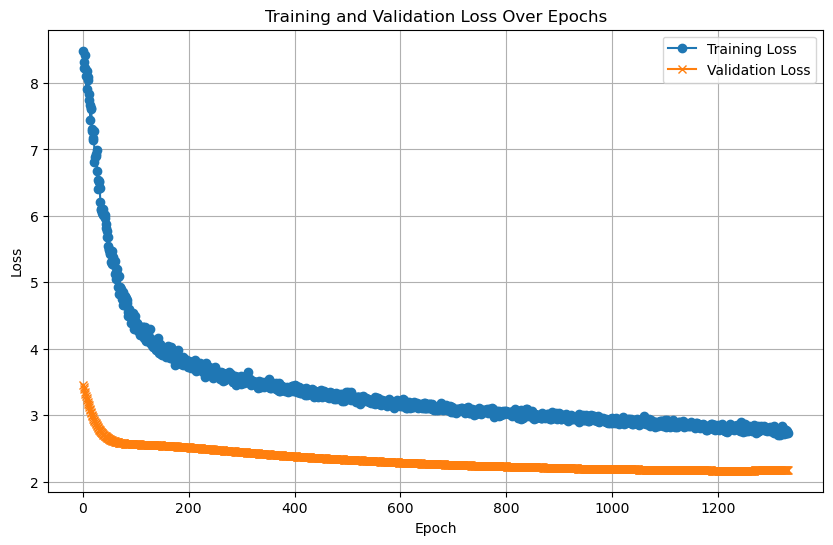

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 5.7307
Test Batch [20/579], Loss: 5.7117
Test Batch [30/579], Loss: 5.6959


Test Batch [40/579], Loss: 5.5985
Test Batch [50/579], Loss: 5.6269
Test Batch [60/579], Loss: 5.6629
Test Batch [70/579], Loss: 5.7774
Test Batch [80/579], Loss: 5.4369
Test Batch [90/579], Loss: 5.6784
Test Batch [100/579], Loss: 5.6306
Test Batch [110/579], Loss: 5.6872
Test Batch [120/579], Loss: 5.6927
Test Batch [130/579], Loss: 5.7115
Test Batch [140/579], Loss: 5.7525
Test Batch [150/579], Loss: 5.7305
Test Batch [160/579], Loss: 5.6669


Test Batch [170/579], Loss: 5.7435


Test Batch [180/579], Loss: 5.6883
Test Batch [190/579], Loss: 5.6436
Test Batch [200/579], Loss: 5.6463
Test Batch [210/579], Loss: 5.6499
Test Batch [220/579], Loss: 5.6571
Test Batch [230/579], Loss: 5.6522
Test Batch [240/579], Loss: 5.6085
Test Batch [250/579], Loss: 5.6100
Test Batch [260/579], Loss: 5.6325
Test Batch [270/579], Loss: 5.6507
Test Batch [280/579], Loss: 5.6710
Test Batch [290/579], Loss: 5.6795
Test Batch [300/579], Loss: 5.5840
Test Batch [310/579], Loss: 5.5481


Test Batch [320/579], Loss: 5.5842
Test Batch [330/579], Loss: 5.4125
Test Batch [340/579], Loss: 5.3172
Test Batch [350/579], Loss: 5.3796
Test Batch [360/579], Loss: 5.5916
Test Batch [370/579], Loss: 5.6900
Test Batch [380/579], Loss: 5.6995
Test Batch [390/579], Loss: 5.5858
Test Batch [400/579], Loss: 5.4736
Test Batch [410/579], Loss: 5.5182
Test Batch [420/579], Loss: 5.3893
Test Batch [430/579], Loss: 5.5949
Test Batch [440/579], Loss: 5.5534


Test Batch [450/579], Loss: 5.6422
Test Batch [460/579], Loss: 5.7073
Test Batch [470/579], Loss: 5.6341
Test Batch [480/579], Loss: 5.7132
Test Batch [490/579], Loss: 5.2007
Test Batch [500/579], Loss: 5.5731
Test Batch [510/579], Loss: 5.4316
Test Batch [520/579], Loss: 4.7040
Test Batch [530/579], Loss: 4.7560
Test Batch [540/579], Loss: 5.6654
Test Batch [550/579], Loss: 5.6922
Test Batch [560/579], Loss: 5.7536
Test Batch [570/579], Loss: 5.7577

Test Loss: 5.5919


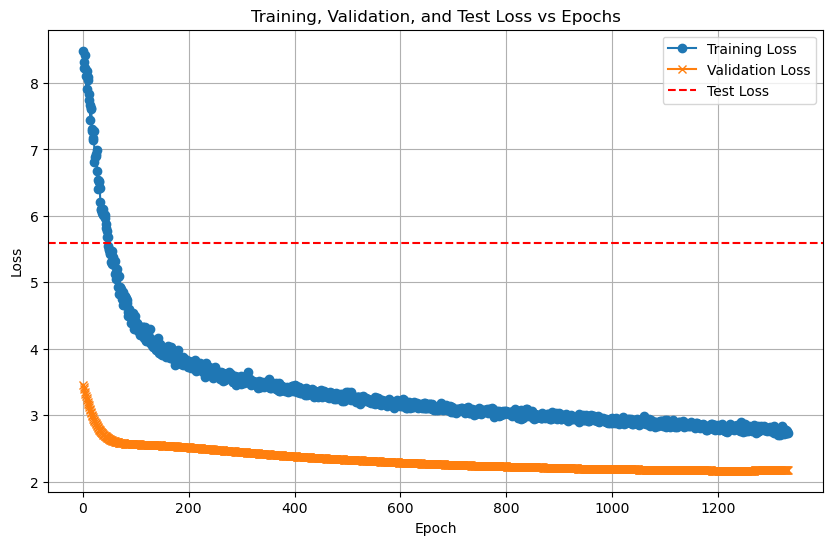

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.


  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.


  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.


  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.75      0.60      0.67         5
           3       1.00      0.80      0.89         5
           4       0.56      1.00      0.71         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.92      0.89      0.89        45
weighted avg       0.92      0.89      0.89        45


LOG: Evaluating on the test set...
Test Accuracy: 93.98%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65956
           1       0.91      0.77      0.84      7583
           2       0.57      0.71      0.63      3075
           3       0.65      0.92      0.76      2670
           4       0.67      0.88      0.76      6569
           5       0.83      0.93      0.88      9233
           6       0.93      0.86      0.89      7272
           7       1.00      0.93      0.96     42811
           8       0.97      1.00      0.99      2848

    accuracy                           0.94    148017
   macro avg       0.84      0.89      0.86    148017
weighted avg       0.95      0.94      0.94    148017

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4047  |  Val Loss: 2.3919
Validation loss improved from inf to 2.3919.
[Epoch 2/1000] Train Loss: 2.3632  |  Val Loss: 2.3587
Validation loss improved from 2.3919 to 2.3587.
[Epoch 3/1000] Train Loss: 2.3231  |  Val Loss: 2.3264
Validation loss improved from 2.3587 to 2.3264.
[Epoch 4/1000] Train Loss: 2.2874  |  Val Loss: 2.2951
Validation loss improved from 2.3264 to 2.2951.
[Epoch 5/1000] Train Loss: 2.2523  |  Val Loss: 2.2653
Validation loss improved from 2.2951 to 2.2653.
[Epoch 6/1000] Train Loss: 2.2191  |  Val Loss: 2.2369
Validation loss improved from 2.2653 to 2.2369.
[Epoch 7/1000] Train Loss: 2.1884  |  Val Loss: 2.2098
Validation loss improved from 2.2369 to 2.2098.
[Epoch 8/1000] Train Loss: 2.1590  |  Val Loss: 2.1837
Validation loss improved from 2.2098 to 2.1837.
[Epoch 9/1000] Train Loss: 2.1312  |  Val Loss: 2.1580
Validation loss improved from 2.1837 to 2.1580.
[Epoch 10/1000] Train Loss: 2.1048  |  Val Loss: 2.1334
Validation loss impr

[Epoch 33/1000] Train Loss: 1.6989  |  Val Loss: 1.7744
Validation loss improved from 1.7859 to 1.7744.
[Epoch 34/1000] Train Loss: 1.6864  |  Val Loss: 1.7632
Validation loss improved from 1.7744 to 1.7632.
[Epoch 35/1000] Train Loss: 1.6742  |  Val Loss: 1.7523
Validation loss improved from 1.7632 to 1.7523.
[Epoch 36/1000] Train Loss: 1.6617  |  Val Loss: 1.7414
Validation loss improved from 1.7523 to 1.7414.
[Epoch 37/1000] Train Loss: 1.6496  |  Val Loss: 1.7304
Validation loss improved from 1.7414 to 1.7304.
[Epoch 38/1000] Train Loss: 1.6377  |  Val Loss: 1.7194
Validation loss improved from 1.7304 to 1.7194.
[Epoch 39/1000] Train Loss: 1.6254  |  Val Loss: 1.7086
Validation loss improved from 1.7194 to 1.7086.
[Epoch 40/1000] Train Loss: 1.6137  |  Val Loss: 1.6978
Validation loss improved from 1.7086 to 1.6978.
[Epoch 41/1000] Train Loss: 1.6014  |  Val Loss: 1.6872
Validation loss improved from 1.6978 to 1.6872.
[Epoch 42/1000] Train Loss: 1.5899  |  Val Loss: 1.6767
Validati

[Epoch 48/1000] Train Loss: 1.5211  |  Val Loss: 1.6163
Validation loss improved from 1.6263 to 1.6163.
[Epoch 49/1000] Train Loss: 1.5102  |  Val Loss: 1.6063
Validation loss improved from 1.6163 to 1.6063.
[Epoch 50/1000] Train Loss: 1.4988  |  Val Loss: 1.5964
Validation loss improved from 1.6063 to 1.5964.
[Epoch 51/1000] Train Loss: 1.4873  |  Val Loss: 1.5865
Validation loss improved from 1.5964 to 1.5865.
[Epoch 52/1000] Train Loss: 1.4763  |  Val Loss: 1.5764
Validation loss improved from 1.5865 to 1.5764.
[Epoch 53/1000] Train Loss: 1.4652  |  Val Loss: 1.5664
Validation loss improved from 1.5764 to 1.5664.
[Epoch 54/1000] Train Loss: 1.4535  |  Val Loss: 1.5564
Validation loss improved from 1.5664 to 1.5564.
[Epoch 55/1000] Train Loss: 1.4424  |  Val Loss: 1.5461
Validation loss improved from 1.5564 to 1.5461.
[Epoch 56/1000] Train Loss: 1.4309  |  Val Loss: 1.5356
Validation loss improved from 1.5461 to 1.5356.
[Epoch 57/1000] Train Loss: 1.4192  |  Val Loss: 1.5253
Validati

[Epoch 80/1000] Train Loss: 1.1828  |  Val Loss: 1.3195
Validation loss improved from 1.3270 to 1.3195.
[Epoch 81/1000] Train Loss: 1.1744  |  Val Loss: 1.3122
Validation loss improved from 1.3195 to 1.3122.
[Epoch 82/1000] Train Loss: 1.1659  |  Val Loss: 1.3049
Validation loss improved from 1.3122 to 1.3049.
[Epoch 83/1000] Train Loss: 1.1578  |  Val Loss: 1.2979
Validation loss improved from 1.3049 to 1.2979.
[Epoch 84/1000] Train Loss: 1.1496  |  Val Loss: 1.2912
Validation loss improved from 1.2979 to 1.2912.
[Epoch 85/1000] Train Loss: 1.1417  |  Val Loss: 1.2846
Validation loss improved from 1.2912 to 1.2846.
[Epoch 86/1000] Train Loss: 1.1337  |  Val Loss: 1.2777
Validation loss improved from 1.2846 to 1.2777.
[Epoch 87/1000] Train Loss: 1.1258  |  Val Loss: 1.2710
Validation loss improved from 1.2777 to 1.2710.
[Epoch 88/1000] Train Loss: 1.1182  |  Val Loss: 1.2643
Validation loss improved from 1.2710 to 1.2643.
[Epoch 89/1000] Train Loss: 1.1105  |  Val Loss: 1.2574
Validati

[Epoch 91/1000] Train Loss: 1.0953  |  Val Loss: 1.2438
Validation loss improved from 1.2506 to 1.2438.
[Epoch 92/1000] Train Loss: 1.0879  |  Val Loss: 1.2372
Validation loss improved from 1.2438 to 1.2372.
[Epoch 93/1000] Train Loss: 1.0805  |  Val Loss: 1.2305
Validation loss improved from 1.2372 to 1.2305.
[Epoch 94/1000] Train Loss: 1.0738  |  Val Loss: 1.2239
Validation loss improved from 1.2305 to 1.2239.
[Epoch 95/1000] Train Loss: 1.0664  |  Val Loss: 1.2176
Validation loss improved from 1.2239 to 1.2176.
[Epoch 96/1000] Train Loss: 1.0593  |  Val Loss: 1.2113
Validation loss improved from 1.2176 to 1.2113.
[Epoch 97/1000] Train Loss: 1.0521  |  Val Loss: 1.2050
Validation loss improved from 1.2113 to 1.2050.
[Epoch 98/1000] Train Loss: 1.0450  |  Val Loss: 1.1985
Validation loss improved from 1.2050 to 1.1985.
[Epoch 99/1000] Train Loss: 1.0383  |  Val Loss: 1.1920
Validation loss improved from 1.1985 to 1.1920.
[Epoch 100/1000] Train Loss: 1.0313  |  Val Loss: 1.1856
Validat

[Epoch 124/1000] Train Loss: 0.8759  |  Val Loss: 1.0499
Validation loss improved from 1.0555 to 1.0499.
[Epoch 125/1000] Train Loss: 0.8694  |  Val Loss: 1.0441
Validation loss improved from 1.0499 to 1.0441.
[Epoch 126/1000] Train Loss: 0.8628  |  Val Loss: 1.0388
Validation loss improved from 1.0441 to 1.0388.
[Epoch 127/1000] Train Loss: 0.8564  |  Val Loss: 1.0334
Validation loss improved from 1.0388 to 1.0334.
[Epoch 128/1000] Train Loss: 0.8498  |  Val Loss: 1.0279
Validation loss improved from 1.0334 to 1.0279.
[Epoch 129/1000] Train Loss: 0.8435  |  Val Loss: 1.0218
Validation loss improved from 1.0279 to 1.0218.
[Epoch 130/1000] Train Loss: 0.8368  |  Val Loss: 1.0157
Validation loss improved from 1.0218 to 1.0157.
[Epoch 131/1000] Train Loss: 0.8303  |  Val Loss: 1.0094
Validation loss improved from 1.0157 to 1.0094.


[Epoch 132/1000] Train Loss: 0.8238  |  Val Loss: 1.0032
Validation loss improved from 1.0094 to 1.0032.
[Epoch 133/1000] Train Loss: 0.8170  |  Val Loss: 0.9971
Validation loss improved from 1.0032 to 0.9971.
[Epoch 134/1000] Train Loss: 0.8108  |  Val Loss: 0.9911
Validation loss improved from 0.9971 to 0.9911.
[Epoch 135/1000] Train Loss: 0.8039  |  Val Loss: 0.9855
Validation loss improved from 0.9911 to 0.9855.
[Epoch 136/1000] Train Loss: 0.7976  |  Val Loss: 0.9799
Validation loss improved from 0.9855 to 0.9799.
[Epoch 137/1000] Train Loss: 0.7911  |  Val Loss: 0.9744
Validation loss improved from 0.9799 to 0.9744.
[Epoch 138/1000] Train Loss: 0.7844  |  Val Loss: 0.9689
Validation loss improved from 0.9744 to 0.9689.
[Epoch 139/1000] Train Loss: 0.7780  |  Val Loss: 0.9631
Validation loss improved from 0.9689 to 0.9631.
[Epoch 140/1000] Train Loss: 0.7718  |  Val Loss: 0.9566
Validation loss improved from 0.9631 to 0.9566.
[Epoch 141/1000] Train Loss: 0.7655  |  Val Loss: 0.950

[Epoch 169/1000] Train Loss: 0.5922  |  Val Loss: 0.7911
Validation loss improved from 0.7975 to 0.7911.
[Epoch 170/1000] Train Loss: 0.5864  |  Val Loss: 0.7851
Validation loss improved from 0.7911 to 0.7851.
[Epoch 171/1000] Train Loss: 0.5812  |  Val Loss: 0.7795
Validation loss improved from 0.7851 to 0.7795.
[Epoch 172/1000] Train Loss: 0.5749  |  Val Loss: 0.7747
Validation loss improved from 0.7795 to 0.7747.
[Epoch 173/1000] Train Loss: 0.5695  |  Val Loss: 0.7697
Validation loss improved from 0.7747 to 0.7697.
[Epoch 174/1000] Train Loss: 0.5637  |  Val Loss: 0.7644
Validation loss improved from 0.7697 to 0.7644.
[Epoch 175/1000] Train Loss: 0.5579  |  Val Loss: 0.7591
Validation loss improved from 0.7644 to 0.7591.
[Epoch 176/1000] Train Loss: 0.5524  |  Val Loss: 0.7541
Validation loss improved from 0.7591 to 0.7541.
[Epoch 177/1000] Train Loss: 0.5468  |  Val Loss: 0.7486
Validation loss improved from 0.7541 to 0.7486.
[Epoch 178/1000] Train Loss: 0.5412  |  Val Loss: 0.743

[Epoch 216/1000] Train Loss: 0.3648  |  Val Loss: 0.5798
Validation loss improved from 0.5829 to 0.5798.
[Epoch 217/1000] Train Loss: 0.3606  |  Val Loss: 0.5764
Validation loss improved from 0.5798 to 0.5764.
[Epoch 218/1000] Train Loss: 0.3570  |  Val Loss: 0.5726
Validation loss improved from 0.5764 to 0.5726.
[Epoch 219/1000] Train Loss: 0.3532  |  Val Loss: 0.5688
Validation loss improved from 0.5726 to 0.5688.
[Epoch 220/1000] Train Loss: 0.3494  |  Val Loss: 0.5652
Validation loss improved from 0.5688 to 0.5652.
[Epoch 221/1000] Train Loss: 0.3457  |  Val Loss: 0.5622
Validation loss improved from 0.5652 to 0.5622.
[Epoch 222/1000] Train Loss: 0.3420  |  Val Loss: 0.5593
Validation loss improved from 0.5622 to 0.5593.
[Epoch 223/1000] Train Loss: 0.3383  |  Val Loss: 0.5562
Validation loss improved from 0.5593 to 0.5562.
[Epoch 224/1000] Train Loss: 0.3346  |  Val Loss: 0.5528
Validation loss improved from 0.5562 to 0.5528.
[Epoch 225/1000] Train Loss: 0.3311  |  Val Loss: 0.549

[Epoch 264/1000] Train Loss: 0.2239  |  Val Loss: 0.4538
Validation loss improved from 0.4560 to 0.4538.
[Epoch 265/1000] Train Loss: 0.2219  |  Val Loss: 0.4518
Validation loss improved from 0.4538 to 0.4518.
[Epoch 266/1000] Train Loss: 0.2198  |  Val Loss: 0.4501
Validation loss improved from 0.4518 to 0.4501.
[Epoch 267/1000] Train Loss: 0.2178  |  Val Loss: 0.4482
Validation loss improved from 0.4501 to 0.4482.
[Epoch 268/1000] Train Loss: 0.2158  |  Val Loss: 0.4460
Validation loss improved from 0.4482 to 0.4460.
[Epoch 269/1000] Train Loss: 0.2141  |  Val Loss: 0.4438
Validation loss improved from 0.4460 to 0.4438.
[Epoch 270/1000] Train Loss: 0.2120  |  Val Loss: 0.4420
Validation loss improved from 0.4438 to 0.4420.
[Epoch 271/1000] Train Loss: 0.2102  |  Val Loss: 0.4402
Validation loss improved from 0.4420 to 0.4402.
[Epoch 272/1000] Train Loss: 0.2082  |  Val Loss: 0.4385
Validation loss improved from 0.4402 to 0.4385.
[Epoch 273/1000] Train Loss: 0.2064  |  Val Loss: 0.436

[Epoch 309/1000] Train Loss: 0.1481  |  Val Loss: 0.3866
Validation loss improved from 0.3875 to 0.3866.
[Epoch 310/1000] Train Loss: 0.1469  |  Val Loss: 0.3855
Validation loss improved from 0.3866 to 0.3855.
[Epoch 311/1000] Train Loss: 0.1455  |  Val Loss: 0.3845
Validation loss improved from 0.3855 to 0.3845.
[Epoch 312/1000] Train Loss: 0.1442  |  Val Loss: 0.3833
Validation loss improved from 0.3845 to 0.3833.
[Epoch 313/1000] Train Loss: 0.1429  |  Val Loss: 0.3818
Validation loss improved from 0.3833 to 0.3818.
[Epoch 314/1000] Train Loss: 0.1416  |  Val Loss: 0.3805
Validation loss improved from 0.3818 to 0.3805.
[Epoch 315/1000] Train Loss: 0.1404  |  Val Loss: 0.3790
Validation loss improved from 0.3805 to 0.3790.
[Epoch 316/1000] Train Loss: 0.1391  |  Val Loss: 0.3775
Validation loss improved from 0.3790 to 0.3775.
[Epoch 317/1000] Train Loss: 0.1379  |  Val Loss: 0.3763
Validation loss improved from 0.3775 to 0.3763.
[Epoch 318/1000] Train Loss: 0.1367  |  Val Loss: 0.375

[Epoch 354/1000] Train Loss: 0.1011  |  Val Loss: 0.3413
Validation loss improved from 0.3420 to 0.3413.
[Epoch 355/1000] Train Loss: 0.1003  |  Val Loss: 0.3402
Validation loss improved from 0.3413 to 0.3402.
[Epoch 356/1000] Train Loss: 0.0995  |  Val Loss: 0.3393
Validation loss improved from 0.3402 to 0.3393.
[Epoch 357/1000] Train Loss: 0.0986  |  Val Loss: 0.3386
Validation loss improved from 0.3393 to 0.3386.
[Epoch 358/1000] Train Loss: 0.0979  |  Val Loss: 0.3379
Validation loss improved from 0.3386 to 0.3379.
[Epoch 359/1000] Train Loss: 0.0971  |  Val Loss: 0.3367
Validation loss improved from 0.3379 to 0.3367.
[Epoch 360/1000] Train Loss: 0.0963  |  Val Loss: 0.3358
Validation loss improved from 0.3367 to 0.3358.
[Epoch 361/1000] Train Loss: 0.0955  |  Val Loss: 0.3351
Validation loss improved from 0.3358 to 0.3351.
[Epoch 362/1000] Train Loss: 0.0948  |  Val Loss: 0.3345
Validation loss improved from 0.3351 to 0.3345.
[Epoch 363/1000] Train Loss: 0.0941  |  Val Loss: 0.333

[Epoch 393/1000] Train Loss: 0.0743  |  Val Loss: 0.3239
Validation loss improved from 0.3240 to 0.3239.
[Epoch 394/1000] Train Loss: 0.0738  |  Val Loss: 0.3234
Validation loss improved from 0.3239 to 0.3234.
[Epoch 395/1000] Train Loss: 0.0732  |  Val Loss: 0.3227
Validation loss improved from 0.3234 to 0.3227.
[Epoch 396/1000] Train Loss: 0.0727  |  Val Loss: 0.3217
Validation loss improved from 0.3227 to 0.3217.
[Epoch 397/1000] Train Loss: 0.0721  |  Val Loss: 0.3209
Validation loss improved from 0.3217 to 0.3209.
[Epoch 398/1000] Train Loss: 0.0716  |  Val Loss: 0.3204
Validation loss improved from 0.3209 to 0.3204.
[Epoch 399/1000] Train Loss: 0.0711  |  Val Loss: 0.3203
Validation loss improved from 0.3204 to 0.3203.
[Epoch 400/1000] Train Loss: 0.0706  |  Val Loss: 0.3196
Validation loss improved from 0.3203 to 0.3196.
[Epoch 401/1000] Train Loss: 0.0701  |  Val Loss: 0.3190
Validation loss improved from 0.3196 to 0.3190.
[Epoch 402/1000] Train Loss: 0.0695  |  Val Loss: 0.318

[Epoch 442/1000] Train Loss: 0.0526  |  Val Loss: 0.3027
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 443/1000] Train Loss: 0.0522  |  Val Loss: 0.3026
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 444/1000] Train Loss: 0.0518  |  Val Loss: 0.3026
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 445/1000] Train Loss: 0.0515  |  Val Loss: 0.3029
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 446/1000] Train Loss: 0.0511  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 447/1000] Train Loss: 0.0508  |  Val Loss: 0.3034
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 448/1000] Train Loss: 0.0504  |  Val Loss: 0.3038
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 449/1000] Train Loss: 0.0501  |  Val Loss: 0.3046
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 450/1000] Train Loss: 0.0497  |  Val Loss: 0.3053
!! Validation loss did NOT improve !! Patience:

[Epoch 491/1000] Train Loss: 0.0380  |  Val Loss: 0.2943
Validation loss improved from 0.2953 to 0.2943.
[Epoch 492/1000] Train Loss: 0.0378  |  Val Loss: 0.2938
Validation loss improved from 0.2943 to 0.2938.
[Epoch 493/1000] Train Loss: 0.0375  |  Val Loss: 0.2934
Validation loss improved from 0.2938 to 0.2934.
[Epoch 494/1000] Train Loss: 0.0373  |  Val Loss: 0.2931
Validation loss improved from 0.2934 to 0.2931.
[Epoch 495/1000] Train Loss: 0.0371  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 496/1000] Train Loss: 0.0368  |  Val Loss: 0.2935
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 497/1000] Train Loss: 0.0366  |  Val Loss: 0.2931
Validation loss improved from 0.2931 to 0.2931.
[Epoch 498/1000] Train Loss: 0.0364  |  Val Loss: 0.2926
Validation loss improved from 0.2931 to 0.2926.
[Epoch 499/1000] Train Loss: 0.0362  |  Val Loss: 0.2925
Validation loss improved from 0.2926 to 0.2925.
[Epoch 500/1000] Train Loss: 0.0359  |  Val

[Epoch 535/1000] Train Loss: 0.0292  |  Val Loss: 0.3005
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 536/1000] Train Loss: 0.0291  |  Val Loss: 0.3009
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 537/1000] Train Loss: 0.0289  |  Val Loss: 0.3010
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 538/1000] Train Loss: 0.0287  |  Val Loss: 0.3012
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 539/1000] Train Loss: 0.0286  |  Val Loss: 0.3007
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 540/1000] Train Loss: 0.0284  |  Val Loss: 0.2997
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 541/1000] Train Loss: 0.0282  |  Val Loss: 0.2990
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 542/1000] Train Loss: 0.0281  |  Val Loss: 0.2979
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 543/1000] Train Loss: 0.0279  |  Val Loss: 0.2969
!! Validation loss did NOT improve !! Patience:

[Epoch 581/1000] Train Loss: 0.0228  |  Val Loss: 0.2907
Validation loss improved from 0.2916 to 0.2907.
[Epoch 582/1000] Train Loss: 0.0227  |  Val Loss: 0.2902
Validation loss improved from 0.2907 to 0.2902.
[Epoch 583/1000] Train Loss: 0.0226  |  Val Loss: 0.2893
Validation loss improved from 0.2902 to 0.2893.
[Epoch 584/1000] Train Loss: 0.0224  |  Val Loss: 0.2887
Validation loss improved from 0.2893 to 0.2887.
[Epoch 585/1000] Train Loss: 0.0223  |  Val Loss: 0.2888
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 586/1000] Train Loss: 0.0222  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 587/1000] Train Loss: 0.0221  |  Val Loss: 0.2904
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 588/1000] Train Loss: 0.0220  |  Val Loss: 0.2918
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 589/1000] Train Loss: 0.0219  |  Val Loss: 0.2928
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 590/1000] Train Lo

[Epoch 626/1000] Train Loss: 0.0183  |  Val Loss: 0.2979
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 627/1000] Train Loss: 0.0182  |  Val Loss: 0.2981
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 628/1000] Train Loss: 0.0181  |  Val Loss: 0.2980
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 629/1000] Train Loss: 0.0181  |  Val Loss: 0.2977
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 630/1000] Train Loss: 0.0180  |  Val Loss: 0.2978
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 631/1000] Train Loss: 0.0179  |  Val Loss: 0.2982
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 632/1000] Train Loss: 0.0178  |  Val Loss: 0.2987
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 633/1000] Train Loss: 0.0177  |  Val Loss: 0.2987
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 634/1000] Train Loss: 0.0176  |  Val Loss: 0.2989
!! Validation loss did NOT improve !! Patience:

[Epoch 677/1000] Train Loss: 0.0147  |  Val Loss: 0.3014
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 678/1000] Train Loss: 0.0146  |  Val Loss: 0.3022
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 679/1000] Train Loss: 0.0145  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 680/1000] Train Loss: 0.0145  |  Val Loss: 0.3039
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 681/1000] Train Loss: 0.0144  |  Val Loss: 0.3041
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 682/1000] Train Loss: 0.0144  |  Val Loss: 0.3037
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 683/1000] Train Loss: 0.0143  |  Val Loss: 0.3034
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 684/1000] Train Loss: 0.0142  |  Val Loss: 0.3030
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 684 !!
No improvement for 100 epochs.


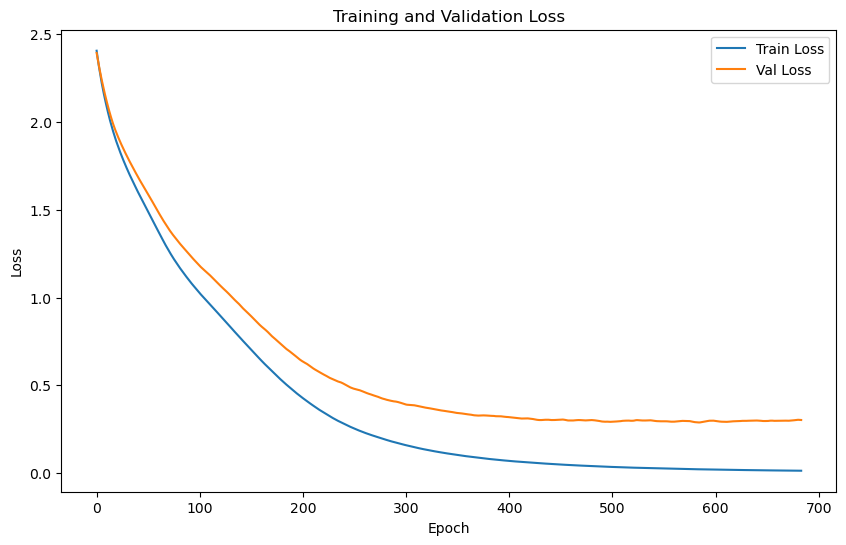

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.2302 | Test Accuracy: 93.96%


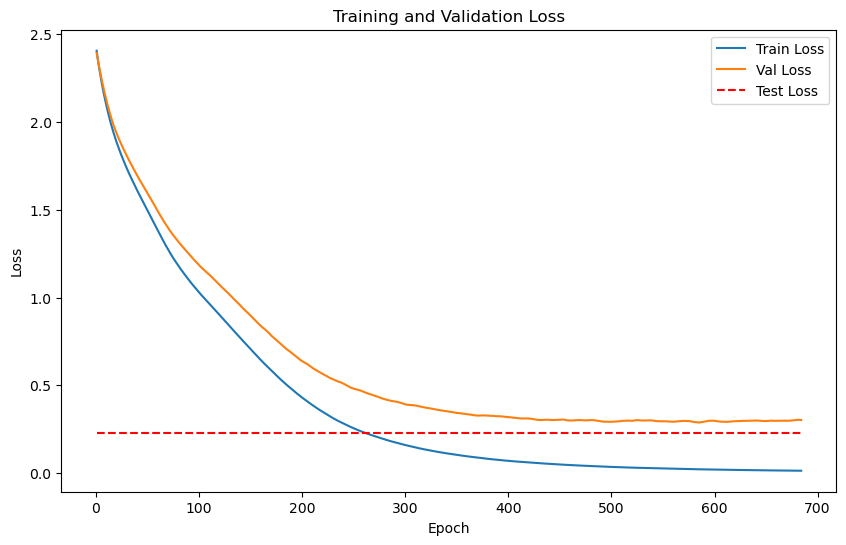

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [1/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.3594

Validation loss improved from inf to 0.3594. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [2/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [3/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [4/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3592

Validation loss improved from 0.3594 to 0.3592. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [5/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.3581

Validation loss improved from 0.3592 to 0.3581. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [6/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3570

Validation loss improved from 0.3581 to 0.3570. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [7/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3559

Validation loss improved from 0.3570 to 0.3559. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [8/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.3550

Validation loss improved from 0.3559 to 0.3550. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3539
Epoch [9/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3539

Validation loss improved from 0.3550 to 0.3539. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3530
Epoch [10/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3530

Validation loss improved from 0.3539 to 0.3530. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [11/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3521

Validation loss improved from 0.3530 to 0.3521. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.3512
Epoch [12/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3512

Validation loss improved from 0.3521 to 0.3512. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [13/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3508

Validation loss improved from 0.3512 to 0.3508. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.3506
Epoch [14/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3506

Validation loss improved from 0.3508 to 0.3506. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [15/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3506

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.3506
Epoch [16/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3506

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [17/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3506

Validation loss improved from 0.3506 to 0.3506. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [18/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3505

Validation loss improved from 0.3506 to 0.3505. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [19/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.3505

Validation loss improved from 0.3505 to 0.3505. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [20/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3504

Validation loss improved from 0.3505 to 0.3504. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [21/2000] - Validation


    Batch [1/1], Val Loss: 0.3504
Epoch [21/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3504

Validation loss improved from 0.3504 to 0.3504. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [22/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3503

Validation loss improved from 0.3504 to 0.3503. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3502


Epoch [23/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3502

Validation loss improved from 0.3503 to 0.3502. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [24/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3501

Validation loss improved from 0.3502 to 0.3501. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [25/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3500

Validation loss improved from 0.3501 to 0.3500. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [26/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.3500

Validation loss improved from 0.3500 to 0.3500. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [27/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3499

Validation loss improved from 0.3500 to 0.3499. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [28/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.3498

Validation loss improved from 0.3499 to 0.3498. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [29/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3496

Validation loss improved from 0.3498 to 0.3496. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [30/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3494

Validation loss improved from 0.3496 to 0.3494. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3493
Epoch [31/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.3493

Validation loss improved from 0.3494 to 0.3493. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3492
Epoch [32/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3492

Validation loss improved from 0.3493 to 0.3492. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [33/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3490

Validation loss improved from 0.3492 to 0.3490. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [34/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.3489

Validation loss improved from 0.3490 to 0.3489. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [35/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.3486

Validation loss improved from 0.3489 to 0.3486. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3484
Epoch [36/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.3484

Validation loss improved from 0.3486 to 0.3484. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.3482
Epoch [37/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3482

Validation loss improved from 0.3484 to 0.3482. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [38/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3479

Validation loss improved from 0.3482 to 0.3479. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.3476
Epoch [39/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3476

Validation loss improved from 0.3479 to 0.3476. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [40/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3473

Validation loss improved from 0.3476 to 0.3473. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [41/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3470

Validation loss improved from 0.3473 to 0.3470. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [42/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3466

Validation loss improved from 0.3470 to 0.3466. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [43/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3463

Validation loss improved from 0.3466 to 0.3463. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.3460
Epoch [44/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3460

Validation loss improved from 0.3463 to 0.3460. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [45/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3456

Validation loss improved from 0.3460 to 0.3456. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.3452
Epoch [46/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3452

Validation loss improved from 0.3456 to 0.3452. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [47/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.3449

Validation loss improved from 0.3452 to 0.3449. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [48/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3444

Validation loss improved from 0.3449 to 0.3444. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [49/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.3440

Validation loss improved from 0.3444 to 0.3440. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [50/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3436

Validation loss improved from 0.3440 to 0.3436. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [51/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3431

Validation loss improved from 0.3436 to 0.3431. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [52/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3427

Validation loss improved from 0.3431 to 0.3427. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3422
Epoch [53/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3422

Validation loss improved from 0.3427 to 0.3422. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3417
Epoch [54/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3417

Validation loss improved from 0.3422 to 0.3417. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [55/2000] - Validation


    Batch [1/1], Val Loss: 0.3412
Epoch [55/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3412

Validation loss improved from 0.3417 to 0.3412. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [56/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3406

Validation loss improved from 0.3412 to 0.3406. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [57/2000] - Validation


    Batch [1/1], Val Loss: 0.3401
Epoch [57/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3401

Validation loss improved from 0.3406 to 0.3401. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [58/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3395

Validation loss improved from 0.3401 to 0.3395. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [59/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3389

Validation loss improved from 0.3395 to 0.3389. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [60/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3383

Validation loss improved from 0.3389 to 0.3383. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [61/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3377

Validation loss improved from 0.3383 to 0.3377. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [62/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3371

Validation loss improved from 0.3377 to 0.3371. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [63/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3366

Validation loss improved from 0.3371 to 0.3366. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [64/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3360

Validation loss improved from 0.3366 to 0.3360. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [65/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3354

Validation loss improved from 0.3360 to 0.3354. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.3348
Epoch [66/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3348

Validation loss improved from 0.3354 to 0.3348. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [67/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3342

Validation loss improved from 0.3348 to 0.3342. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [68/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3336

Validation loss improved from 0.3342 to 0.3336. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [69/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3330

Validation loss improved from 0.3336 to 0.3330. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [70/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3324

Validation loss improved from 0.3330 to 0.3324. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [71/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3318

Validation loss improved from 0.3324 to 0.3318. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [72/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3313

Validation loss improved from 0.3318 to 0.3313. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.3307
Epoch [73/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.3307

Validation loss improved from 0.3313 to 0.3307. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [74/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3301

Validation loss improved from 0.3307 to 0.3301. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [75/2000] - Validation


    Batch [1/1], Val Loss: 0.3295
Epoch [75/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3295

Validation loss improved from 0.3301 to 0.3295. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [76/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3290

Validation loss improved from 0.3295 to 0.3290. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [77/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [77/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3284

Validation loss improved from 0.3290 to 0.3284. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3278
Epoch [78/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.3278

Validation loss improved from 0.3284 to 0.3278. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [79/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3272

Validation loss improved from 0.3278 to 0.3272. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [80/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3266

Validation loss improved from 0.3272 to 0.3266. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [81/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.3260

Validation loss improved from 0.3266 to 0.3260. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [82/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3254

Validation loss improved from 0.3260 to 0.3254. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3248
Epoch [83/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3248

Validation loss improved from 0.3254 to 0.3248. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3242
Epoch [84/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3242

Validation loss improved from 0.3248 to 0.3242. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [85/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.3236

Validation loss improved from 0.3242 to 0.3236. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.3230
Epoch [86/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3230

Validation loss improved from 0.3236 to 0.3230. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [87/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3224

Validation loss improved from 0.3230 to 0.3224. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3218
Epoch [88/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3218

Validation loss improved from 0.3224 to 0.3218. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [89/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3212

Validation loss improved from 0.3218 to 0.3212. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [90/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3207

Validation loss improved from 0.3212 to 0.3207. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [91/2000] - Validation


    Batch [1/1], Val Loss: 0.3201
Epoch [91/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.3201

Validation loss improved from 0.3207 to 0.3201. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3196
Epoch [92/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3196

Validation loss improved from 0.3201 to 0.3196. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [93/2000] - Validation


    Batch [1/1], Val Loss: 0.3190
Epoch [93/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3190

Validation loss improved from 0.3196 to 0.3190. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [94/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3184

Validation loss improved from 0.3190 to 0.3184. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [95/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.3179

Validation loss improved from 0.3184 to 0.3179. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [96/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3173

Validation loss improved from 0.3179 to 0.3173. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [97/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.3168

Validation loss improved from 0.3173 to 0.3168. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [98/2000] - Validation


    Batch [1/1], Val Loss: 0.3162
Epoch [98/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3162

Validation loss improved from 0.3168 to 0.3162. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3157
Epoch [99/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3157

Validation loss improved from 0.3162 to 0.3157. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.3152
Epoch [100/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3152

Validation loss improved from 0.3157 to 0.3152. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [101/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.3146

Validation loss improved from 0.3152 to 0.3146. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [102/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.3141

Validation loss improved from 0.3146 to 0.3141. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [103/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3136

Validation loss improved from 0.3141 to 0.3136. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.3131
Epoch [104/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3131

Validation loss improved from 0.3136 to 0.3131. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [105/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.3126

Validation loss improved from 0.3131 to 0.3126. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.3120
Epoch [106/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3120

Validation loss improved from 0.3126 to 0.3120. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [107/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3115

Validation loss improved from 0.3120 to 0.3115. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3110
Epoch [108/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3110

Validation loss improved from 0.3115 to 0.3110. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [109/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3104

Validation loss improved from 0.3110 to 0.3104. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [110/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3099

Validation loss improved from 0.3104 to 0.3099. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.3094
Epoch [111/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3094

Validation loss improved from 0.3099 to 0.3094. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [112/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3089

Validation loss improved from 0.3094 to 0.3089. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.3085
Epoch [113/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3085

Validation loss improved from 0.3089 to 0.3085. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [114/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3080

Validation loss improved from 0.3085 to 0.3080. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [115/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3075

Validation loss improved from 0.3080 to 0.3075. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [116/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3070

Validation loss improved from 0.3075 to 0.3070. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [117/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3066

Validation loss improved from 0.3070 to 0.3066. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [118/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.3061

Validation loss improved from 0.3066 to 0.3061. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [119/2000] - Validation


    Batch [1/1], Val Loss: 0.3057
Epoch [119/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3057

Validation loss improved from 0.3061 to 0.3057. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [120/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3053

Validation loss improved from 0.3057 to 0.3053. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.3048
Epoch [121/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3048

Validation loss improved from 0.3053 to 0.3048. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [122/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3044

Validation loss improved from 0.3048 to 0.3044. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.3040
Epoch [123/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3040

Validation loss improved from 0.3044 to 0.3040. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [124/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3036

Validation loss improved from 0.3040 to 0.3036. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3032
Epoch [125/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3032

Validation loss improved from 0.3036 to 0.3032. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3028
Epoch [126/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.3028

Validation loss improved from 0.3032 to 0.3028. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [127/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3024

Validation loss improved from 0.3028 to 0.3024. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [128/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3020

Validation loss improved from 0.3024 to 0.3020. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [129/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.3016

Validation loss improved from 0.3020 to 0.3016. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [130/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3013

Validation loss improved from 0.3016 to 0.3013. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [131/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.3009

Validation loss improved from 0.3013 to 0.3009. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.3005
Epoch [132/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3005

Validation loss improved from 0.3009 to 0.3005. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3002
Epoch [133/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3002

Validation loss improved from 0.3005 to 0.3002. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.2998
Epoch [134/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2998

Validation loss improved from 0.3002 to 0.2998. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2995
Epoch [135/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2995

Validation loss improved from 0.2998 to 0.2995. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2991
Epoch [136/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2991

Validation loss improved from 0.2995 to 0.2991. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2987
Epoch [137/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.2987

Validation loss improved from 0.2991 to 0.2987. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2984
Epoch [138/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.2984

Validation loss improved from 0.2987 to 0.2984. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.2980
Epoch [139/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2980

Validation loss improved from 0.2984 to 0.2980. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [140/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2976

Validation loss improved from 0.2980 to 0.2976. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [141/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2973

Validation loss improved from 0.2976 to 0.2973. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [142/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2969

Validation loss improved from 0.2973 to 0.2969. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [143/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2966

Validation loss improved from 0.2969 to 0.2966. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2963
Epoch [144/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.2963

Validation loss improved from 0.2966 to 0.2963. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2960
Epoch [145/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2960

Validation loss improved from 0.2963 to 0.2960. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [146/2000] - Validation


    Batch [1/1], Val Loss: 0.2957
Epoch [146/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.2957

Validation loss improved from 0.2960 to 0.2957. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [147/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.2953

Validation loss improved from 0.2957 to 0.2953. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [148/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.2950

Validation loss improved from 0.2953 to 0.2950. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2947
Epoch [149/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2947

Validation loss improved from 0.2950 to 0.2947. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [150/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2943

Validation loss improved from 0.2947 to 0.2943. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3265
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.2940
Epoch [151/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.2940

Validation loss improved from 0.2943 to 0.2940. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2937
Epoch [152/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2937

Validation loss improved from 0.2940 to 0.2937. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.2933
Epoch [153/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2933

Validation loss improved from 0.2937 to 0.2933. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2930
Epoch [154/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.2930

Validation loss improved from 0.2933 to 0.2930. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.2927
Epoch [155/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2927

Validation loss improved from 0.2930 to 0.2927. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [156/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.2923

Validation loss improved from 0.2927 to 0.2923. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2920
Epoch [157/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2920

Validation loss improved from 0.2923 to 0.2920. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [158/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2917

Validation loss improved from 0.2920 to 0.2917. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [159/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2914

Validation loss improved from 0.2917 to 0.2914. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2910
Epoch [160/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2910

Validation loss improved from 0.2914 to 0.2910. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [161/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2907

Validation loss improved from 0.2910 to 0.2907. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2903
Epoch [162/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.2903

Validation loss improved from 0.2907 to 0.2903. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [163/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2900

Validation loss improved from 0.2903 to 0.2900. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [164/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2896

Validation loss improved from 0.2900 to 0.2896. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [165/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2893

Validation loss improved from 0.2896 to 0.2893. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [166/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2889

Validation loss improved from 0.2893 to 0.2889. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [167/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2886

Validation loss improved from 0.2889 to 0.2886. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [168/2000] - Validation


    Batch [1/1], Val Loss: 0.2882
Epoch [168/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2882

Validation loss improved from 0.2886 to 0.2882. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [169/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2878

Validation loss improved from 0.2882 to 0.2878. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.2875
Epoch [170/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2875

Validation loss improved from 0.2878 to 0.2875. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2871
Epoch [171/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2871

Validation loss improved from 0.2875 to 0.2871. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.2868
Epoch [172/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2868

Validation loss improved from 0.2871 to 0.2868. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2864
Epoch [173/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2864

Validation loss improved from 0.2868 to 0.2864. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.2860
Epoch [174/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2860

Validation loss improved from 0.2864 to 0.2860. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2857
Epoch [175/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2857

Validation loss improved from 0.2860 to 0.2857. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.2853
Epoch [176/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2853

Validation loss improved from 0.2857 to 0.2853. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2850
Epoch [177/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2850

Validation loss improved from 0.2853 to 0.2850. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.2846
Epoch [178/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.2846

Validation loss improved from 0.2850 to 0.2846. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2843
Epoch [179/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.2843

Validation loss improved from 0.2846 to 0.2843. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2839
Epoch [180/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.2839

Validation loss improved from 0.2843 to 0.2839. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.2836
Epoch [181/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2836

Validation loss improved from 0.2839 to 0.2836. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2832
Epoch [182/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2832

Validation loss improved from 0.2836 to 0.2832. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2829
Epoch [183/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.2829

Validation loss improved from 0.2832 to 0.2829. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [184/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2826

Validation loss improved from 0.2829 to 0.2826. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.2823
Epoch [185/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2823

Validation loss improved from 0.2826 to 0.2823. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [186/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.2819

Validation loss improved from 0.2823 to 0.2819. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2816
Epoch [187/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.2816

Validation loss improved from 0.2819 to 0.2816. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2813
Epoch [188/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2813

Validation loss improved from 0.2816 to 0.2813. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2811
Epoch [189/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.2811

Validation loss improved from 0.2813 to 0.2811. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.2808
Epoch [190/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.2808

Validation loss improved from 0.2811 to 0.2808. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2805
Epoch [191/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2805

Validation loss improved from 0.2808 to 0.2805. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.2802
Epoch [192/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2802

Validation loss improved from 0.2805 to 0.2802. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2799
Epoch [193/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.2799

Validation loss improved from 0.2802 to 0.2799. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2796
Epoch [194/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2796

Validation loss improved from 0.2799 to 0.2796. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2793
Epoch [195/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2793

Validation loss improved from 0.2796 to 0.2793. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2790
Epoch [196/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.2790

Validation loss improved from 0.2793 to 0.2790. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.2788
Epoch [197/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.2788

Validation loss improved from 0.2790 to 0.2788. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2785
Epoch [198/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2785

Validation loss improved from 0.2788 to 0.2785. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.2783
Epoch [199/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2783

Validation loss improved from 0.2785 to 0.2783. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [200/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2781

Validation loss improved from 0.2783 to 0.2781. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2779
Epoch [201/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2777
Epoch [202/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2777

Validation loss improved from 0.2779 to 0.2777. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2775
Epoch [203/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2775

Validation loss improved from 0.2777 to 0.2775. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2773
Epoch [204/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.2773

Validation loss improved from 0.2775 to 0.2773. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2770
Epoch [205/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.2770

Validation loss improved from 0.2773 to 0.2770. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2768
Epoch [206/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2765
Epoch [207/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.2765

Validation loss improved from 0.2768 to 0.2765. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.2762
Epoch [208/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2762

Validation loss improved from 0.2765 to 0.2762. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2760
Epoch [209/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.2760

Validation loss improved from 0.2762 to 0.2760. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.2757
Epoch [210/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2757

Validation loss improved from 0.2760 to 0.2757. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2754
Epoch [211/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2754

Validation loss improved from 0.2757 to 0.2754. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2752
Epoch [212/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2749
Epoch [213/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2749

Validation loss improved from 0.2752 to 0.2749. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2746
Epoch [214/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2746

Validation loss improved from 0.2749 to 0.2746. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.2743
Epoch [215/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2743

Validation loss improved from 0.2746 to 0.2743. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [216/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.2740

Validation loss improved from 0.2743 to 0.2740. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [217/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [218/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2735

Validation loss improved from 0.2738 to 0.2735. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.2732
Epoch [219/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2732

Validation loss improved from 0.2735 to 0.2732. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [220/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.2729

Validation loss improved from 0.2732 to 0.2729. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [221/2000] - Validation


    Batch [1/1], Val Loss: 0.2727
Epoch [221/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [222/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.2724

Validation loss improved from 0.2727 to 0.2724. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.2722
Epoch [223/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2722

Validation loss improved from 0.2724 to 0.2722. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2719
Epoch [224/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2719

Validation loss improved from 0.2722 to 0.2719. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [225/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2715
Epoch [226/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2715

Validation loss improved from 0.2717 to 0.2715. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2712
Epoch [227/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.2712

Validation loss improved from 0.2715 to 0.2712. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2710
Epoch [228/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2710

Validation loss improved from 0.2712 to 0.2710. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [229/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2708

Validation loss improved from 0.2710 to 0.2708. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2705
Epoch [230/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2705

Validation loss improved from 0.2708 to 0.2705. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [231/2000] - Validation


    Batch [1/1], Val Loss: 0.2703
Epoch [231/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2703

Validation loss improved from 0.2705 to 0.2703. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2701
Epoch [232/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2701

Validation loss improved from 0.2703 to 0.2701. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2699
Epoch [233/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2699

Validation loss improved from 0.2701 to 0.2699. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2696
Epoch [234/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.2696

Validation loss improved from 0.2699 to 0.2696. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2694
Epoch [235/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2694

Validation loss improved from 0.2696 to 0.2694. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2692
Epoch [236/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2692

Validation loss improved from 0.2694 to 0.2692. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2690
Epoch [237/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2690

Validation loss improved from 0.2692 to 0.2690. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.2688
Epoch [238/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2688

Validation loss improved from 0.2690 to 0.2688. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2686
Epoch [239/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.2686

Validation loss improved from 0.2688 to 0.2686. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [240/2000] - Validation


    Batch [1/1], Val Loss: 0.2685
Epoch [240/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2685

Validation loss improved from 0.2686 to 0.2685. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2683
Epoch [241/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2683

Validation loss improved from 0.2685 to 0.2683. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2682
Epoch [242/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2682

Validation loss improved from 0.2683 to 0.2682. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2680
Epoch [243/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2680

Validation loss improved from 0.2682 to 0.2680. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2678
Epoch [244/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2678

Validation loss improved from 0.2680 to 0.2678. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2676
Epoch [245/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2676

Validation loss improved from 0.2678 to 0.2676. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [246/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [247/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2671
Epoch [248/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2671

Validation loss improved from 0.2673 to 0.2671. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2669
Epoch [249/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.2669

Validation loss improved from 0.2671 to 0.2669. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [250/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2667

Validation loss improved from 0.2669 to 0.2667. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2666
Epoch [251/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2664
Epoch [252/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2664

Validation loss improved from 0.2666 to 0.2664. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2662
Epoch [253/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2662

Validation loss improved from 0.2664 to 0.2662. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [254/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [255/2000] - Validation


    Batch [1/1], Val Loss: 0.2659
Epoch [255/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2659

Validation loss improved from 0.2661 to 0.2659. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.2658
Epoch [256/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [257/2000] - Validation


    Batch [1/1], Val Loss: 0.2656
Epoch [257/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2656

Validation loss improved from 0.2658 to 0.2656. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2655
Epoch [258/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [259/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2653

Validation loss improved from 0.2655 to 0.2653. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2651
Epoch [260/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2651

Validation loss improved from 0.2653 to 0.2651. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2649
Epoch [261/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2649

Validation loss improved from 0.2651 to 0.2649. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.2648
Epoch [262/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [263/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2646

Validation loss improved from 0.2648 to 0.2646. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.2645
Epoch [264/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2645

Validation loss improved from 0.2646 to 0.2645. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [265/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2643

Validation loss improved from 0.2645 to 0.2643. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [266/2000] - Validation


    Batch [1/1], Val Loss: 0.2641
Epoch [266/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2641

Validation loss improved from 0.2643 to 0.2641. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [267/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2639

Validation loss improved from 0.2641 to 0.2639. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [268/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [269/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [270/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.2633

Validation loss improved from 0.2635 to 0.2633. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2631
Epoch [271/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2631

Validation loss improved from 0.2633 to 0.2631. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.2629
Epoch [272/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2629

Validation loss improved from 0.2631 to 0.2629. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [273/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2627

Validation loss improved from 0.2629 to 0.2627. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2626
Epoch [274/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2624
Epoch [275/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2624

Validation loss improved from 0.2626 to 0.2624. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2623
Epoch [276/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2621
Epoch [277/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2621

Validation loss improved from 0.2623 to 0.2621. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [278/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.2619
Epoch [279/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2619

Validation loss improved from 0.2620 to 0.2619. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2617
Epoch [280/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2617

Validation loss improved from 0.2619 to 0.2617. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [281/2000] - Validation


    Batch [1/1], Val Loss: 0.2615
Epoch [281/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2615

Validation loss improved from 0.2617 to 0.2615. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2614
Epoch [282/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2612
Epoch [283/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2612

Validation loss improved from 0.2614 to 0.2612. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2610
Epoch [284/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2610

Validation loss improved from 0.2612 to 0.2610. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2609
Epoch [285/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2561
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2607
Epoch [286/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.2607

Validation loss improved from 0.2609 to 0.2607. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [287/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.2605
Epoch [288/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2604
Epoch [289/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2534
LOG: Epoch [290/2000] - Validation


    Batch [1/1], Val Loss: 0.2603
Epoch [290/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2602
Epoch [291/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2600
Epoch [292/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.2600

Validation loss improved from 0.2602 to 0.2600. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2599
Epoch [293/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2598
Epoch [294/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2597
Epoch [295/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2596
Epoch [296/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.2595
Epoch [297/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2593
Epoch [298/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2593

Validation loss improved from 0.2595 to 0.2593. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2591
Epoch [299/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.2591

Validation loss improved from 0.2593 to 0.2591. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2590
Epoch [300/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2588
Epoch [301/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2588

Validation loss improved from 0.2590 to 0.2588. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.2587
Epoch [302/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [303/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2585
Epoch [304/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [305/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [306/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [307/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [308/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [309/2000] - Validation


    Batch [1/1], Val Loss: 0.2581
Epoch [309/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [310/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [311/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [312/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2402
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [313/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [314/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [315/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.2574
Epoch [316/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2436
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2573
Epoch [317/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.2572
Epoch [318/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2571
Epoch [319/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2380
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [320/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [321/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [322/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.2567
Epoch [323/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [324/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2567

Validation loss improved from 0.2567 to 0.2567. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [325/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [326/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [327/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [328/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [329/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2562
Epoch [330/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [331/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [332/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2413
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.2559
Epoch [333/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [334/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.2557

Validation loss improved from 0.2559 to 0.2557. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.2556
Epoch [335/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2555
Epoch [336/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [337/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [338/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2552
Epoch [339/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2551
Epoch [340/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2550
Epoch [341/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2377
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2550
Epoch [342/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.2549
Epoch [343/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [344/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2377
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [345/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [346/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [347/2000] - Validation


    Batch [1/1], Val Loss: 0.2546
Epoch [347/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [348/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2544
Epoch [349/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [350/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [351/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [352/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2540
Epoch [353/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.2539
Epoch [354/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2538
Epoch [355/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.2538
Epoch [356/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2538

Validation loss improved from 0.2538 to 0.2538. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2537
Epoch [357/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2537
Epoch [358/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2537

Validation loss improved from 0.2537 to 0.2537. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2536
Epoch [359/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2535
Epoch [360/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2210
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2534
Epoch [361/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [362/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [363/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2531

Validation loss improved from 0.2533 to 0.2531. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2530
Epoch [364/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [365/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.2528

Validation loss improved from 0.2530 to 0.2528. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2527
Epoch [366/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2526
Epoch [367/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [368/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.2524

Validation loss improved from 0.2526 to 0.2524. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [369/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.2522
Epoch [370/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [371/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2521

Validation loss improved from 0.2522 to 0.2521. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.2520
Epoch [372/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2520

Validation loss improved from 0.2521 to 0.2520. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [373/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.2519

Validation loss improved from 0.2520 to 0.2519. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.2517
Epoch [374/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2517

Validation loss improved from 0.2519 to 0.2517. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [375/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.2515
Epoch [376/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2515

Validation loss improved from 0.2516 to 0.2515. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [377/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [378/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2203
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [379/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.2511

Validation loss improved from 0.2513 to 0.2511. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2509
Epoch [380/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2509

Validation loss improved from 0.2511 to 0.2509. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [381/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2185
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2506
Epoch [382/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.2506

Validation loss improved from 0.2508 to 0.2506. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [383/2000] - Validation


    Batch [1/1], Val Loss: 0.2504
Epoch [383/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.2504

Validation loss improved from 0.2506 to 0.2504. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [384/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2502

Validation loss improved from 0.2504 to 0.2502. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [385/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [385/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [386/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.2499

Validation loss improved from 0.2501 to 0.2499. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.2497
Epoch [387/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.2497

Validation loss improved from 0.2499 to 0.2497. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2496
Epoch [388/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [389/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.2494

Validation loss improved from 0.2496 to 0.2494. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [390/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.2492

Validation loss improved from 0.2494 to 0.2492. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [391/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.2489
Epoch [392/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2489

Validation loss improved from 0.2491 to 0.2489. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [393/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.2487

Validation loss improved from 0.2489 to 0.2487. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [394/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.2486

Validation loss improved from 0.2487 to 0.2486. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [395/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2486

Validation loss improved from 0.2486 to 0.2486. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [396/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.2485

Validation loss improved from 0.2486 to 0.2485. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [397/2000] - Validation


    Batch [1/1], Val Loss: 0.2485
Epoch [397/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.2485

Validation loss improved from 0.2485 to 0.2485. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [398/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.2485
Epoch [399/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [400/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [401/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [402/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [403/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.2487
Epoch [404/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [405/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.2487
Epoch [406/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [407/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.2487
Epoch [408/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.2487

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [409/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [410/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [411/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [412/2000] - Validation


    Batch [1/1], Val Loss: 0.2486
Epoch [412/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2486

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [413/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [414/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2485

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2484
Epoch [415/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2484

Validation loss improved from 0.2485 to 0.2484. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2483
Epoch [416/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.2483

Validation loss improved from 0.2484 to 0.2483. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [417/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.2482

Validation loss improved from 0.2483 to 0.2482. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [418/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2482

Validation loss improved from 0.2482 to 0.2482. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [419/2000] - Validation


    Batch [1/1], Val Loss: 0.2480
Epoch [419/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2480

Validation loss improved from 0.2482 to 0.2480. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2479
Epoch [420/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.2479

Validation loss improved from 0.2480 to 0.2479. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [421/2000] - Validation


    Batch [1/1], Val Loss: 0.2478
Epoch [421/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2477
Epoch [422/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2476
Epoch [423/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2476

Validation loss improved from 0.2477 to 0.2476. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2475
Epoch [424/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [425/2000] - Validation


    Batch [1/1], Val Loss: 0.2474
Epoch [425/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.2474

Validation loss improved from 0.2475 to 0.2474. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [426/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.2474

Validation loss improved from 0.2474 to 0.2474. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [427/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [428/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.2473

Validation loss improved from 0.2473 to 0.2473. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [429/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [430/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.2472

Validation loss improved from 0.2472 to 0.2472. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [431/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [432/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.2471

Validation loss improved from 0.2471 to 0.2471. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [433/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2471

Validation loss improved from 0.2471 to 0.2471. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [434/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [435/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2470

Validation loss improved from 0.2470 to 0.2470. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.2469
Epoch [436/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2469

Validation loss improved from 0.2470 to 0.2469. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [437/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2469

Validation loss improved from 0.2469 to 0.2469. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.2469
Epoch [438/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2469

Validation loss improved from 0.2469 to 0.2469. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [439/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [440/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [440/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [441/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2467

Validation loss improved from 0.2467 to 0.2467. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [442/2000] - Validation


    Batch [1/1], Val Loss: 0.2466
Epoch [442/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [443/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [444/2000] - Validation


    Batch [1/1], Val Loss: 0.2466
Epoch [444/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [445/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [446/2000] - Validation


    Batch [1/1], Val Loss: 0.2466
Epoch [446/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [447/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [448/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [449/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [450/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2462
Epoch [451/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2462

Validation loss improved from 0.2464 to 0.2462. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2462
Epoch [452/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.2462

Validation loss improved from 0.2462 to 0.2462. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [453/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [454/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [455/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [456/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [457/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2458

Validation loss improved from 0.2459 to 0.2458. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [458/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2458

Validation loss improved from 0.2458 to 0.2458. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [459/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2457

Validation loss improved from 0.2458 to 0.2457. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [460/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2455

Validation loss improved from 0.2457 to 0.2455. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [461/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2454

Validation loss improved from 0.2455 to 0.2454. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [462/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [463/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2450

Validation loss improved from 0.2453 to 0.2450. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [464/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2448

Validation loss improved from 0.2450 to 0.2448. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [465/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.2446

Validation loss improved from 0.2448 to 0.2446. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [466/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [467/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.2443

Validation loss improved from 0.2445 to 0.2443. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [468/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2441

Validation loss improved from 0.2443 to 0.2441. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2440
Epoch [469/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2439
Epoch [470/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2439

Validation loss improved from 0.2440 to 0.2439. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2437
Epoch [471/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2437

Validation loss improved from 0.2439 to 0.2437. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.2436
Epoch [472/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2436

Validation loss improved from 0.2437 to 0.2436. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2436
Epoch [473/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2436

Validation loss improved from 0.2436 to 0.2436. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [474/2000] - Validation


    Batch [1/1], Val Loss: 0.2435
Epoch [474/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.2435

Validation loss improved from 0.2436 to 0.2435. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2435
Epoch [475/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2435

Validation loss improved from 0.2435 to 0.2435. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2435
Epoch [476/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2435

Validation loss improved from 0.2435 to 0.2435. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2434
Epoch [477/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2434

Validation loss improved from 0.2435 to 0.2434. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2433
Epoch [478/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2433

Validation loss improved from 0.2434 to 0.2433. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.2433
Epoch [479/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2432
Epoch [480/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2432
Epoch [481/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2432

Validation loss improved from 0.2432 to 0.2432. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [482/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [483/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [484/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [485/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [486/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [487/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2430
Epoch [488/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.2430
Epoch [489/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2430

Validation loss improved from 0.2430 to 0.2430. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2429
Epoch [490/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2429
Epoch [491/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.2429

Validation loss improved from 0.2429 to 0.2429. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [492/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2428

Validation loss improved from 0.2429 to 0.2428. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2427
Epoch [493/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2426
Epoch [494/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [495/2000] - Validation


    Batch [1/1], Val Loss: 0.2424
Epoch [495/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2424

Validation loss improved from 0.2426 to 0.2424. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2423
Epoch [496/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2422
Epoch [497/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2420
Epoch [498/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2420

Validation loss improved from 0.2422 to 0.2420. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2419
Epoch [499/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1833
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.2417
Epoch [500/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.2417

Validation loss improved from 0.2419 to 0.2417. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [501/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.2416

Validation loss improved from 0.2417 to 0.2416. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [502/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [503/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [504/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [505/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [506/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.2417
Epoch [507/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2417

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2417
Epoch [508/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.2417

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1831
LOG: Epoch [509/2000] - Validation


    Batch [1/1], Val Loss: 0.2417
Epoch [509/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.2417

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [510/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.2415
Epoch [511/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2414
Epoch [512/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2413
Epoch [513/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2412
Epoch [514/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [515/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2411

Validation loss improved from 0.2412 to 0.2411. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.2409
Epoch [516/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.2409

Validation loss improved from 0.2411 to 0.2409. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [517/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [518/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [519/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1787
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [520/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.2405

Validation loss improved from 0.2406 to 0.2405. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [521/2000] - Validation


    Batch [1/1], Val Loss: 0.2404
Epoch [521/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [522/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.2404

Validation loss improved from 0.2404 to 0.2404. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [523/2000] - Validation


    Batch [1/1], Val Loss: 0.2403
Epoch [523/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [524/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [525/2000] - Validation


    Batch [1/1], Val Loss: 0.2401
Epoch [525/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.2401

Validation loss improved from 0.2402 to 0.2401. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [526/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2401

Validation loss improved from 0.2401 to 0.2401. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2400
Epoch [527/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.2400

Validation loss improved from 0.2401 to 0.2400. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2399
Epoch [528/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2398
Epoch [529/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [530/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [531/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [532/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [533/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2396

Validation loss improved from 0.2396 to 0.2396. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [534/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [535/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.2396

Validation loss improved from 0.2396 to 0.2396. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [536/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2396

Validation loss improved from 0.2396 to 0.2396. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [537/2000] - Validation


    Batch [1/1], Val Loss: 0.2395
Epoch [537/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [538/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1703
LOG: Epoch [539/2000] - Validation


    Batch [1/1], Val Loss: 0.2394
Epoch [539/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.2394

Validation loss improved from 0.2394 to 0.2394. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1718
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [540/2000], Avg Train Loss: 0.1718, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.2395
Epoch [541/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [542/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [543/2000] - Validation


    Batch [1/1], Val Loss: 0.2395
Epoch [543/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [544/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.2396
Epoch [545/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [546/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.2397
Epoch [547/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1690
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [548/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.2397
Epoch [549/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [550/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [551/2000] - Validation


    Batch [1/1], Val Loss: 0.2397
Epoch [551/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [552/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [553/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [554/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [555/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [556/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.1641
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [557/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [558/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [559/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [560/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [561/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2394

Validation loss improved from 0.2394 to 0.2394. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [562/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2394

Validation loss improved from 0.2394 to 0.2394. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [563/2000] - Validation


    Batch [1/1], Val Loss: 0.2393
Epoch [563/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1666
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [564/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.2393

Validation loss improved from 0.2393 to 0.2393. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [565/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1680
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [566/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [567/2000] - Validation


    Batch [1/1], Val Loss: 0.2391
Epoch [567/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [568/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [569/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [570/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.2389

Validation loss improved from 0.2389 to 0.2389. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [571/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [572/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [573/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [574/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [575/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [576/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [577/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [578/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.1658
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [579/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [580/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [581/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [582/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [583/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [584/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [585/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [586/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [587/2000] - Validation


    Batch [1/1], Val Loss: 0.2397
Epoch [587/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [588/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [589/2000] - Validation


    Batch [1/1], Val Loss: 0.2396
Epoch [589/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [590/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.2396
Epoch [591/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [592/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1590
LOG: Epoch [593/2000] - Validation


    Batch [1/1], Val Loss: 0.2396
Epoch [593/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [594/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [595/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.1550
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [596/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [597/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [598/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1498
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [599/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [600/2000] - Validation


    Batch [1/1], Val Loss: 0.2393
Epoch [600/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [601/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1592
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [602/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [603/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [604/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [605/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [606/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [607/2000] - Validation


    Batch [1/1], Val Loss: 0.2391
Epoch [607/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [608/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [609/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [610/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [611/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [612/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [613/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.1596
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [614/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [615/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [616/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [617/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [618/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [619/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [620/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1588
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [621/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [622/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [623/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [624/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [625/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [626/2000] - Validation


    Batch [1/1], Val Loss: 0.2390
Epoch [626/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [627/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1554
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [628/2000], Avg Train Loss: 0.1554, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [629/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1528
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [630/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [631/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [632/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [633/2000] - Validation


    Batch [1/1], Val Loss: 0.2390
Epoch [633/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [634/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [635/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1499
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [636/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [637/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [638/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [639/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [640/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.2390
Epoch [641/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [642/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [643/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [644/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [645/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [646/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [647/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [648/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [649/2000] - Validation


    Batch [1/1], Val Loss: 0.2390
Epoch [649/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [650/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [651/2000] - Validation


    Batch [1/1], Val Loss: 0.2390
Epoch [651/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [652/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [653/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [654/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [655/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [656/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [657/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [658/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [659/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [660/2000] - Validation


    Batch [1/1], Val Loss: 0.2390
Epoch [660/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [661/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [662/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [663/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [664/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [665/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [666/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [667/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [668/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [669/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1677
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [670/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 670!!
No improvement for 100 epochs


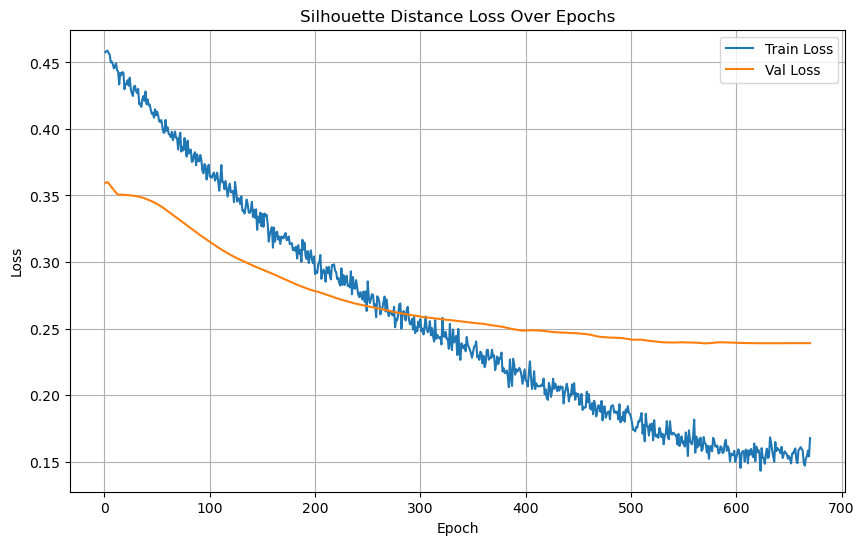

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2313], Loss: 0.0869
Test Batch [20/2313], Loss: 0.1486
Test Batch [30/2313], Loss: 0.5000
Test Batch [40/2313], Loss: 0.1153
Test Batch [50/2313], Loss: 0.5000
Test Batch [60/2313], Loss: 0.5000


Test Batch [70/2313], Loss: 0.5000
Test Batch [80/2313], Loss: 0.1705
Test Batch [90/2313], Loss: 0.5000
Test Batch [100/2313], Loss: 0.0547
Test Batch [110/2313], Loss: 0.5000
Test Batch [120/2313], Loss: 0.1832
Test Batch [130/2313], Loss: 0.5000


Test Batch [140/2313], Loss: 0.5000
Test Batch [150/2313], Loss: 0.5000
Test Batch [160/2313], Loss: 0.1268
Test Batch [170/2313], Loss: 0.5000
Test Batch [180/2313], Loss: 0.5000
Test Batch [190/2313], Loss: 0.5000


Test Batch [200/2313], Loss: 0.1644
Test Batch [210/2313], Loss: 0.5000
Test Batch [220/2313], Loss: 0.5000
Test Batch [230/2313], Loss: 0.1093
Test Batch [240/2313], Loss: 0.0345
Test Batch [250/2313], Loss: 0.1494
Test Batch [260/2313], Loss: 0.5000


Test Batch [270/2313], Loss: 0.5000
Test Batch [280/2313], Loss: 0.5000
Test Batch [290/2313], Loss: 0.0862
Test Batch [300/2313], Loss: 0.1174
Test Batch [310/2313], Loss: 0.5000
Test Batch [320/2313], Loss: 0.0882
Test Batch [330/2313], Loss: 0.5000


Test Batch [340/2313], Loss: 0.5000
Test Batch [350/2313], Loss: 0.1831
Test Batch [360/2313], Loss: 0.1492
Test Batch [370/2313], Loss: 0.1626
Test Batch [380/2313], Loss: 0.0883
Test Batch [390/2313], Loss: 0.5000
Test Batch [400/2313], Loss: 0.5000
Test Batch [410/2313], Loss: 0.0452


Test Batch [420/2313], Loss: 0.0603
Test Batch [430/2313], Loss: 0.1401
Test Batch [440/2313], Loss: 0.5000
Test Batch [450/2313], Loss: 0.0726
Test Batch [460/2313], Loss: 0.5000


Test Batch [470/2313], Loss: 0.1812
Test Batch [480/2313], Loss: 0.5000
Test Batch [490/2313], Loss: 0.0966
Test Batch [500/2313], Loss: 0.0580
Test Batch [510/2313], Loss: 0.1274
Test Batch [520/2313], Loss: 0.0903
Test Batch [530/2313], Loss: 0.5000


Test Batch [540/2313], Loss: 0.0539
Test Batch [550/2313], Loss: 0.0821
Test Batch [560/2313], Loss: 0.5000
Test Batch [570/2313], Loss: 0.5000
Test Batch [580/2313], Loss: 0.1078
Test Batch [590/2313], Loss: 0.0563


Test Batch [600/2313], Loss: 0.5000
Test Batch [610/2313], Loss: 0.5000
Test Batch [620/2313], Loss: 0.1314
Test Batch [630/2313], Loss: 0.0264
Test Batch [640/2313], Loss: 0.1074


Test Batch [650/2313], Loss: 0.5000
Test Batch [660/2313], Loss: 0.0359
Test Batch [670/2313], Loss: 0.1350
Test Batch [680/2313], Loss: 0.5000
Test Batch [690/2313], Loss: 0.1009
Test Batch [700/2313], Loss: 0.2132


Test Batch [710/2313], Loss: 0.5000
Test Batch [720/2313], Loss: 0.5000
Test Batch [730/2313], Loss: 0.5000
Test Batch [740/2313], Loss: 0.5000
Test Batch [750/2313], Loss: 0.1431
Test Batch [760/2313], Loss: 0.0733


Test Batch [770/2313], Loss: 0.5000
Test Batch [780/2313], Loss: 0.5000
Test Batch [790/2313], Loss: 0.1040
Test Batch [800/2313], Loss: 0.1258
Test Batch [810/2313], Loss: 0.5000


Test Batch [820/2313], Loss: 0.1201
Test Batch [830/2313], Loss: 0.0462
Test Batch [840/2313], Loss: 0.0297
Test Batch [850/2313], Loss: 0.1855
Test Batch [860/2313], Loss: 0.5000
Test Batch [870/2313], Loss: 0.1588
Test Batch [880/2313], Loss: 0.0442


Test Batch [890/2313], Loss: 0.5000
Test Batch [900/2313], Loss: 0.5000
Test Batch [910/2313], Loss: 0.0306
Test Batch [920/2313], Loss: 0.5000
Test Batch [930/2313], Loss: 0.1538
Test Batch [940/2313], Loss: 0.2001
Test Batch [950/2313], Loss: 0.0166


Test Batch [960/2313], Loss: 0.5000
Test Batch [970/2313], Loss: 0.5000
Test Batch [980/2313], Loss: 0.0248
Test Batch [990/2313], Loss: 0.1614
Test Batch [1000/2313], Loss: 0.5000
Test Batch [1010/2313], Loss: 0.0818


Test Batch [1020/2313], Loss: 0.1061
Test Batch [1030/2313], Loss: 0.5000
Test Batch [1040/2313], Loss: 0.1531
Test Batch [1050/2313], Loss: 0.0728
Test Batch [1060/2313], Loss: 0.5000


Test Batch [1070/2313], Loss: 0.0309
Test Batch [1080/2313], Loss: 0.5000
Test Batch [1090/2313], Loss: 0.0674
Test Batch [1100/2313], Loss: 0.1755
Test Batch [1110/2313], Loss: 0.1911


Test Batch [1120/2313], Loss: 0.0417
Test Batch [1130/2313], Loss: 0.1193
Test Batch [1140/2313], Loss: 0.0927
Test Batch [1150/2313], Loss: 0.5000
Test Batch [1160/2313], Loss: 0.0823


Test Batch [1170/2313], Loss: 0.0647
Test Batch [1180/2313], Loss: 0.1569
Test Batch [1190/2313], Loss: 0.1612
Test Batch [1200/2313], Loss: 0.0944
Test Batch [1210/2313], Loss: 0.1197


Test Batch [1220/2313], Loss: 0.1086
Test Batch [1230/2313], Loss: 0.1039
Test Batch [1240/2313], Loss: 0.5000
Test Batch [1250/2313], Loss: 0.5000
Test Batch [1260/2313], Loss: 0.0620


Test Batch [1270/2313], Loss: 0.1217
Test Batch [1280/2313], Loss: 0.1075
Test Batch [1290/2313], Loss: 0.0869
Test Batch [1300/2313], Loss: 0.1550


Test Batch [1310/2313], Loss: 0.1423
Test Batch [1320/2313], Loss: 0.1852
Test Batch [1330/2313], Loss: 0.1379
Test Batch [1340/2313], Loss: 0.0376


Test Batch [1350/2313], Loss: 0.2182
Test Batch [1360/2313], Loss: 0.2093
Test Batch [1370/2313], Loss: 0.5000


Test Batch [1380/2313], Loss: 0.1759
Test Batch [1390/2313], Loss: 0.1806
Test Batch [1400/2313], Loss: 0.1480


Test Batch [1410/2313], Loss: 0.1736
Test Batch [1420/2313], Loss: 0.1909
Test Batch [1430/2313], Loss: 0.5000


Test Batch [1440/2313], Loss: 0.1510
Test Batch [1450/2313], Loss: 0.2091
Test Batch [1460/2313], Loss: 0.1363
Test Batch [1470/2313], Loss: 0.1115


Test Batch [1480/2313], Loss: 0.1166
Test Batch [1490/2313], Loss: 0.2176
Test Batch [1500/2313], Loss: 0.1509
Test Batch [1510/2313], Loss: 0.1098


Test Batch [1520/2313], Loss: 0.5000
Test Batch [1530/2313], Loss: 0.1358
Test Batch [1540/2313], Loss: 0.1534
Test Batch [1550/2313], Loss: 0.1510


Test Batch [1560/2313], Loss: 0.1509
Test Batch [1570/2313], Loss: 0.1193
Test Batch [1580/2313], Loss: 0.1373
Test Batch [1590/2313], Loss: 0.1565


Test Batch [1600/2313], Loss: 0.2018
Test Batch [1610/2313], Loss: 0.1572
Test Batch [1620/2313], Loss: 0.1563
Test Batch [1630/2313], Loss: 0.1603


Test Batch [1640/2313], Loss: 0.2042
Test Batch [1650/2313], Loss: 0.0610
Test Batch [1660/2313], Loss: 0.1758
Test Batch [1670/2313], Loss: 0.1230


Test Batch [1680/2313], Loss: 0.1709
Test Batch [1690/2313], Loss: 0.2105
Test Batch [1700/2313], Loss: 0.1104
Test Batch [1710/2313], Loss: 0.0935
Test Batch [1720/2313], Loss: 0.1063


Test Batch [1730/2313], Loss: 0.0512
Test Batch [1740/2313], Loss: 0.5000
Test Batch [1750/2313], Loss: 0.0662
Test Batch [1760/2313], Loss: 0.0693
Test Batch [1770/2313], Loss: 0.0629
Test Batch [1780/2313], Loss: 0.0916
Test Batch [1790/2313], Loss: 0.0929


Test Batch [1800/2313], Loss: 0.1132
Test Batch [1810/2313], Loss: 0.1122
Test Batch [1820/2313], Loss: 0.1967
Test Batch [1830/2313], Loss: 0.0430
Test Batch [1840/2313], Loss: 0.2002
Test Batch [1850/2313], Loss: 0.1273


Test Batch [1860/2313], Loss: 0.1703
Test Batch [1870/2313], Loss: 0.1594
Test Batch [1880/2313], Loss: 0.1497
Test Batch [1890/2313], Loss: 0.1397


Test Batch [1900/2313], Loss: 0.1566
Test Batch [1910/2313], Loss: 0.1567
Test Batch [1920/2313], Loss: 0.1922
Test Batch [1930/2313], Loss: 0.1363


Test Batch [1940/2313], Loss: 0.1301
Test Batch [1950/2313], Loss: 0.1363
Test Batch [1960/2313], Loss: 0.1579
Test Batch [1970/2313], Loss: 0.1441
Test Batch [1980/2313], Loss: 0.1462
Test Batch [1990/2313], Loss: 0.1072
Test Batch [2000/2313], Loss: 0.1698


Test Batch [2010/2313], Loss: 0.1282
Test Batch [2020/2313], Loss: 0.1756
Test Batch [2030/2313], Loss: 0.0997
Test Batch [2040/2313], Loss: 0.1435
Test Batch [2050/2313], Loss: 0.2085


Test Batch [2060/2313], Loss: 0.1660
Test Batch [2070/2313], Loss: 0.1168
Test Batch [2080/2313], Loss: 0.5000
Test Batch [2090/2313], Loss: 0.5000
Test Batch [2100/2313], Loss: 0.5000
Test Batch [2110/2313], Loss: 0.1234
Test Batch [2120/2313], Loss: 0.1615
Test Batch [2130/2313], Loss: 0.5000


Test Batch [2140/2313], Loss: 0.0681
Test Batch [2150/2313], Loss: 0.5000
Test Batch [2160/2313], Loss: 0.5000
Test Batch [2170/2313], Loss: 0.5000
Test Batch [2180/2313], Loss: 0.5000


Test Batch [2190/2313], Loss: 0.5000
Test Batch [2200/2313], Loss: 0.0580
Test Batch [2210/2313], Loss: 0.1584
Test Batch [2220/2313], Loss: 0.5000
Test Batch [2230/2313], Loss: 0.0370
Test Batch [2240/2313], Loss: 0.5000
Test Batch [2250/2313], Loss: 0.5000


Test Batch [2260/2313], Loss: 0.5000
Test Batch [2270/2313], Loss: 0.1531
Test Batch [2280/2313], Loss: 0.5000
Test Batch [2290/2313], Loss: 0.0528
Test Batch [2300/2313], Loss: 0.5000
Test Batch [2310/2313], Loss: 0.5000

Test Loss: 0.2335


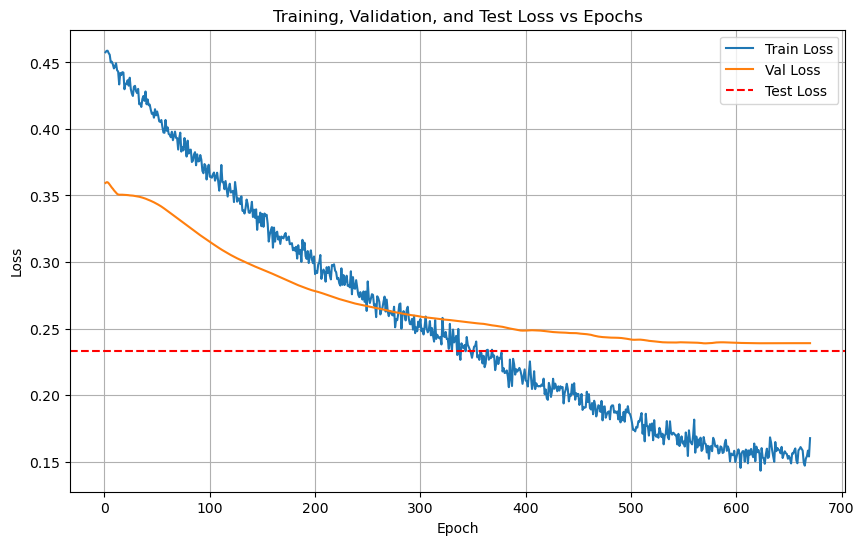

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2313 for test dataset.
  Processed batch 20/2313 for test dataset.


  Processed batch 30/2313 for test dataset.
  Processed batch 40/2313 for test dataset.
  Processed batch 50/2313 for test dataset.
  Processed batch 60/2313 for test dataset.


  Processed batch 70/2313 for test dataset.
  Processed batch 80/2313 for test dataset.
  Processed batch 90/2313 for test dataset.
  Processed batch 100/2313 for test dataset.


  Processed batch 110/2313 for test dataset.
  Processed batch 120/2313 for test dataset.
  Processed batch 130/2313 for test dataset.
  Processed batch 140/2313 for test dataset.


  Processed batch 150/2313 for test dataset.
  Processed batch 160/2313 for test dataset.
  Processed batch 170/2313 for test dataset.
  Processed batch 180/2313 for test dataset.


  Processed batch 190/2313 for test dataset.
  Processed batch 200/2313 for test dataset.
  Processed batch 210/2313 for test dataset.
  Processed batch 220/2313 for test dataset.


  Processed batch 230/2313 for test dataset.
  Processed batch 240/2313 for test dataset.
  Processed batch 250/2313 for test dataset.
  Processed batch 260/2313 for test dataset.


  Processed batch 270/2313 for test dataset.
  Processed batch 280/2313 for test dataset.
  Processed batch 290/2313 for test dataset.
  Processed batch 300/2313 for test dataset.


  Processed batch 310/2313 for test dataset.
  Processed batch 320/2313 for test dataset.
  Processed batch 330/2313 for test dataset.
  Processed batch 340/2313 for test dataset.


  Processed batch 350/2313 for test dataset.
  Processed batch 360/2313 for test dataset.
  Processed batch 370/2313 for test dataset.
  Processed batch 380/2313 for test dataset.


  Processed batch 390/2313 for test dataset.
  Processed batch 400/2313 for test dataset.
  Processed batch 410/2313 for test dataset.
  Processed batch 420/2313 for test dataset.


  Processed batch 430/2313 for test dataset.
  Processed batch 440/2313 for test dataset.
  Processed batch 450/2313 for test dataset.
  Processed batch 460/2313 for test dataset.


  Processed batch 470/2313 for test dataset.
  Processed batch 480/2313 for test dataset.
  Processed batch 490/2313 for test dataset.


  Processed batch 500/2313 for test dataset.
  Processed batch 510/2313 for test dataset.
  Processed batch 520/2313 for test dataset.
  Processed batch 530/2313 for test dataset.


  Processed batch 540/2313 for test dataset.
  Processed batch 550/2313 for test dataset.
  Processed batch 560/2313 for test dataset.


  Processed batch 570/2313 for test dataset.
  Processed batch 580/2313 for test dataset.
  Processed batch 590/2313 for test dataset.
  Processed batch 600/2313 for test dataset.


  Processed batch 610/2313 for test dataset.
  Processed batch 620/2313 for test dataset.
  Processed batch 630/2313 for test dataset.
  Processed batch 640/2313 for test dataset.


  Processed batch 650/2313 for test dataset.
  Processed batch 660/2313 for test dataset.
  Processed batch 670/2313 for test dataset.
  Processed batch 680/2313 for test dataset.


  Processed batch 690/2313 for test dataset.
  Processed batch 700/2313 for test dataset.
  Processed batch 710/2313 for test dataset.
  Processed batch 720/2313 for test dataset.


  Processed batch 730/2313 for test dataset.
  Processed batch 740/2313 for test dataset.
  Processed batch 750/2313 for test dataset.


  Processed batch 760/2313 for test dataset.
  Processed batch 770/2313 for test dataset.
  Processed batch 780/2313 for test dataset.
  Processed batch 790/2313 for test dataset.


  Processed batch 800/2313 for test dataset.
  Processed batch 810/2313 for test dataset.
  Processed batch 820/2313 for test dataset.
  Processed batch 830/2313 for test dataset.


  Processed batch 840/2313 for test dataset.
  Processed batch 850/2313 for test dataset.
  Processed batch 860/2313 for test dataset.
  Processed batch 870/2313 for test dataset.


  Processed batch 880/2313 for test dataset.
  Processed batch 890/2313 for test dataset.
  Processed batch 900/2313 for test dataset.
  Processed batch 910/2313 for test dataset.


  Processed batch 920/2313 for test dataset.
  Processed batch 930/2313 for test dataset.
  Processed batch 940/2313 for test dataset.
  Processed batch 950/2313 for test dataset.


  Processed batch 960/2313 for test dataset.
  Processed batch 970/2313 for test dataset.
  Processed batch 980/2313 for test dataset.
  Processed batch 990/2313 for test dataset.


  Processed batch 1000/2313 for test dataset.
  Processed batch 1010/2313 for test dataset.
  Processed batch 1020/2313 for test dataset.


  Processed batch 1030/2313 for test dataset.
  Processed batch 1040/2313 for test dataset.
  Processed batch 1050/2313 for test dataset.
  Processed batch 1060/2313 for test dataset.


  Processed batch 1070/2313 for test dataset.
  Processed batch 1080/2313 for test dataset.
  Processed batch 1090/2313 for test dataset.
  Processed batch 1100/2313 for test dataset.


  Processed batch 1110/2313 for test dataset.
  Processed batch 1120/2313 for test dataset.
  Processed batch 1130/2313 for test dataset.
  Processed batch 1140/2313 for test dataset.


  Processed batch 1150/2313 for test dataset.
  Processed batch 1160/2313 for test dataset.
  Processed batch 1170/2313 for test dataset.
  Processed batch 1180/2313 for test dataset.


  Processed batch 1190/2313 for test dataset.
  Processed batch 1200/2313 for test dataset.
  Processed batch 1210/2313 for test dataset.
  Processed batch 1220/2313 for test dataset.


  Processed batch 1230/2313 for test dataset.
  Processed batch 1240/2313 for test dataset.
  Processed batch 1250/2313 for test dataset.
  Processed batch 1260/2313 for test dataset.


  Processed batch 1270/2313 for test dataset.
  Processed batch 1280/2313 for test dataset.
  Processed batch 1290/2313 for test dataset.
  Processed batch 1300/2313 for test dataset.


  Processed batch 1310/2313 for test dataset.
  Processed batch 1320/2313 for test dataset.
  Processed batch 1330/2313 for test dataset.


  Processed batch 1340/2313 for test dataset.
  Processed batch 1350/2313 for test dataset.
  Processed batch 1360/2313 for test dataset.
  Processed batch 1370/2313 for test dataset.


  Processed batch 1380/2313 for test dataset.
  Processed batch 1390/2313 for test dataset.
  Processed batch 1400/2313 for test dataset.


  Processed batch 1410/2313 for test dataset.
  Processed batch 1420/2313 for test dataset.
  Processed batch 1430/2313 for test dataset.
  Processed batch 1440/2313 for test dataset.


  Processed batch 1450/2313 for test dataset.
  Processed batch 1460/2313 for test dataset.
  Processed batch 1470/2313 for test dataset.
  Processed batch 1480/2313 for test dataset.


  Processed batch 1490/2313 for test dataset.
  Processed batch 1500/2313 for test dataset.
  Processed batch 1510/2313 for test dataset.
  Processed batch 1520/2313 for test dataset.


  Processed batch 1530/2313 for test dataset.
  Processed batch 1540/2313 for test dataset.
  Processed batch 1550/2313 for test dataset.
  Processed batch 1560/2313 for test dataset.


  Processed batch 1570/2313 for test dataset.
  Processed batch 1580/2313 for test dataset.
  Processed batch 1590/2313 for test dataset.
  Processed batch 1600/2313 for test dataset.


  Processed batch 1610/2313 for test dataset.
  Processed batch 1620/2313 for test dataset.
  Processed batch 1630/2313 for test dataset.
  Processed batch 1640/2313 for test dataset.


  Processed batch 1650/2313 for test dataset.
  Processed batch 1660/2313 for test dataset.
  Processed batch 1670/2313 for test dataset.


  Processed batch 1680/2313 for test dataset.
  Processed batch 1690/2313 for test dataset.
  Processed batch 1700/2313 for test dataset.
  Processed batch 1710/2313 for test dataset.


  Processed batch 1720/2313 for test dataset.
  Processed batch 1730/2313 for test dataset.
  Processed batch 1740/2313 for test dataset.
  Processed batch 1750/2313 for test dataset.


  Processed batch 1760/2313 for test dataset.
  Processed batch 1770/2313 for test dataset.
  Processed batch 1780/2313 for test dataset.
  Processed batch 1790/2313 for test dataset.


  Processed batch 1800/2313 for test dataset.
  Processed batch 1810/2313 for test dataset.
  Processed batch 1820/2313 for test dataset.
  Processed batch 1830/2313 for test dataset.


  Processed batch 1840/2313 for test dataset.
  Processed batch 1850/2313 for test dataset.
  Processed batch 1860/2313 for test dataset.
  Processed batch 1870/2313 for test dataset.


  Processed batch 1880/2313 for test dataset.
  Processed batch 1890/2313 for test dataset.
  Processed batch 1900/2313 for test dataset.
  Processed batch 1910/2313 for test dataset.


  Processed batch 1920/2313 for test dataset.
  Processed batch 1930/2313 for test dataset.
  Processed batch 1940/2313 for test dataset.
  Processed batch 1950/2313 for test dataset.


  Processed batch 1960/2313 for test dataset.
  Processed batch 1970/2313 for test dataset.
  Processed batch 1980/2313 for test dataset.
  Processed batch 1990/2313 for test dataset.


  Processed batch 2000/2313 for test dataset.
  Processed batch 2010/2313 for test dataset.
  Processed batch 2020/2313 for test dataset.
  Processed batch 2030/2313 for test dataset.


  Processed batch 2040/2313 for test dataset.
  Processed batch 2050/2313 for test dataset.
  Processed batch 2060/2313 for test dataset.
  Processed batch 2070/2313 for test dataset.


  Processed batch 2080/2313 for test dataset.
  Processed batch 2090/2313 for test dataset.
  Processed batch 2100/2313 for test dataset.
  Processed batch 2110/2313 for test dataset.


  Processed batch 2120/2313 for test dataset.
  Processed batch 2130/2313 for test dataset.
  Processed batch 2140/2313 for test dataset.


  Processed batch 2150/2313 for test dataset.
  Processed batch 2160/2313 for test dataset.
  Processed batch 2170/2313 for test dataset.
  Processed batch 2180/2313 for test dataset.


  Processed batch 2190/2313 for test dataset.
  Processed batch 2200/2313 for test dataset.
  Processed batch 2210/2313 for test dataset.


  Processed batch 2220/2313 for test dataset.
  Processed batch 2230/2313 for test dataset.
  Processed batch 2240/2313 for test dataset.
  Processed batch 2250/2313 for test dataset.


  Processed batch 2260/2313 for test dataset.
  Processed batch 2270/2313 for test dataset.
  Processed batch 2280/2313 for test dataset.
  Processed batch 2290/2313 for test dataset.


  Processed batch 2300/2313 for test dataset.
  Processed batch 2310/2313 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.75      0.60      0.67         5
           3       1.00      0.80      0.89         5
           4       0.62      1.00      0.77         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45


LOG: Evaluating on the test set...
Test Accuracy: 94.96%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65956
           1       0.93      0.76      0.84      7583
           2       0.57      0.75      0.65      3075
           3       0.67      0.89      0.77      2670
           4       0.81      0.89      0.85      6569
           5       0.80      0.94      0.86      9233
           6       0.92      0.87      0.90      7272
           7       1.00      0.95      0.98     42811
           8       0.99      1.00      0.99      2848

    accuracy                           0.95    148017
   macro avg       0.86      0.89      0.87    148017
weighted avg       0.96      0.95      0.95    148017

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1242  |  Val Loss: 2.1247
Validation loss improved from inf to 2.1247.
[Epoch 2/1000] Train Loss: 2.0889  |  Val Loss: 2.0950
Validation loss improved from 2.1247 to 2.0950.
[Epoch 3/1000] Train Loss: 2.0539  |  Val Loss: 2.0662
Validation loss improved from 2.0950 to 2.0662.
[Epoch 4/1000] Train Loss: 2.0205  |  Val Loss: 2.0381
Validation loss improved from 2.0662 to 2.0381.
[Epoch 5/1000] Train Loss: 1.9868  |  Val Loss: 2.0107
Validation loss improved from 2.0381 to 2.0107.
[Epoch 6/1000] Train Loss: 1.9550  |  Val Loss: 1.9841
Validation loss improved from 2.0107 to 1.9841.
[Epoch 7/1000] Train Loss: 1.9232  |  Val Loss: 1.9579
Validation loss improved from 1.9841 to 1.9579.
[Epoch 8/1000] Train Loss: 1.8926  |  Val Loss: 1.9322
Validation loss improved from 1.9579 to 1.9322.
[Epoch 9/1000] Train Loss: 1.8624  |  Val Loss: 1.9072
Validation loss improved from 1.9322 to 1.9072.
[Epoch 10/1000] Train Loss: 1.8333  |  Val Loss: 1.8827
Validation loss impr

[Epoch 34/1000] Train Loss: 1.3085  |  Val Loss: 1.4415
Validation loss improved from 1.4563 to 1.4415.
[Epoch 35/1000] Train Loss: 1.2908  |  Val Loss: 1.4267
Validation loss improved from 1.4415 to 1.4267.
[Epoch 36/1000] Train Loss: 1.2734  |  Val Loss: 1.4124
Validation loss improved from 1.4267 to 1.4124.
[Epoch 37/1000] Train Loss: 1.2563  |  Val Loss: 1.3984
Validation loss improved from 1.4124 to 1.3984.
[Epoch 38/1000] Train Loss: 1.2396  |  Val Loss: 1.3848
Validation loss improved from 1.3984 to 1.3848.
[Epoch 39/1000] Train Loss: 1.2237  |  Val Loss: 1.3714
Validation loss improved from 1.3848 to 1.3714.
[Epoch 40/1000] Train Loss: 1.2078  |  Val Loss: 1.3582
Validation loss improved from 1.3714 to 1.3582.
[Epoch 41/1000] Train Loss: 1.1915  |  Val Loss: 1.3451
Validation loss improved from 1.3582 to 1.3451.
[Epoch 42/1000] Train Loss: 1.1763  |  Val Loss: 1.3323
Validation loss improved from 1.3451 to 1.3323.
[Epoch 43/1000] Train Loss: 1.1615  |  Val Loss: 1.3198
Validati

[Epoch 46/1000] Train Loss: 1.1177  |  Val Loss: 1.2835
Validation loss improved from 1.2955 to 1.2835.
[Epoch 47/1000] Train Loss: 1.1039  |  Val Loss: 1.2717
Validation loss improved from 1.2835 to 1.2717.
[Epoch 48/1000] Train Loss: 1.0901  |  Val Loss: 1.2601
Validation loss improved from 1.2717 to 1.2601.
[Epoch 49/1000] Train Loss: 1.0770  |  Val Loss: 1.2486
Validation loss improved from 1.2601 to 1.2486.
[Epoch 50/1000] Train Loss: 1.0635  |  Val Loss: 1.2374
Validation loss improved from 1.2486 to 1.2374.
[Epoch 51/1000] Train Loss: 1.0505  |  Val Loss: 1.2261
Validation loss improved from 1.2374 to 1.2261.
[Epoch 52/1000] Train Loss: 1.0373  |  Val Loss: 1.2149
Validation loss improved from 1.2261 to 1.2149.
[Epoch 53/1000] Train Loss: 1.0247  |  Val Loss: 1.2038
Validation loss improved from 1.2149 to 1.2038.
[Epoch 54/1000] Train Loss: 1.0120  |  Val Loss: 1.1927
Validation loss improved from 1.2038 to 1.1927.
[Epoch 55/1000] Train Loss: 0.9997  |  Val Loss: 1.1819
Validati

[Epoch 80/1000] Train Loss: 0.7390  |  Val Loss: 0.9530
Validation loss improved from 0.9608 to 0.9530.
[Epoch 81/1000] Train Loss: 0.7300  |  Val Loss: 0.9453
Validation loss improved from 0.9530 to 0.9453.
[Epoch 82/1000] Train Loss: 0.7213  |  Val Loss: 0.9377
Validation loss improved from 0.9453 to 0.9377.
[Epoch 83/1000] Train Loss: 0.7127  |  Val Loss: 0.9302
Validation loss improved from 0.9377 to 0.9302.
[Epoch 84/1000] Train Loss: 0.7038  |  Val Loss: 0.9228
Validation loss improved from 0.9302 to 0.9228.
[Epoch 85/1000] Train Loss: 0.6955  |  Val Loss: 0.9155
Validation loss improved from 0.9228 to 0.9155.
[Epoch 86/1000] Train Loss: 0.6869  |  Val Loss: 0.9083
Validation loss improved from 0.9155 to 0.9083.
[Epoch 87/1000] Train Loss: 0.6781  |  Val Loss: 0.9012
Validation loss improved from 0.9083 to 0.9012.
[Epoch 88/1000] Train Loss: 0.6701  |  Val Loss: 0.8940
Validation loss improved from 0.9012 to 0.8940.
[Epoch 89/1000] Train Loss: 0.6619  |  Val Loss: 0.8868
Validati

[Epoch 93/1000] Train Loss: 0.6294  |  Val Loss: 0.8583
Validation loss improved from 0.8654 to 0.8583.
[Epoch 94/1000] Train Loss: 0.6214  |  Val Loss: 0.8513
Validation loss improved from 0.8583 to 0.8513.
[Epoch 95/1000] Train Loss: 0.6138  |  Val Loss: 0.8442
Validation loss improved from 0.8513 to 0.8442.
[Epoch 96/1000] Train Loss: 0.6059  |  Val Loss: 0.8371
Validation loss improved from 0.8442 to 0.8371.
[Epoch 97/1000] Train Loss: 0.5980  |  Val Loss: 0.8301
Validation loss improved from 0.8371 to 0.8301.
[Epoch 98/1000] Train Loss: 0.5903  |  Val Loss: 0.8231
Validation loss improved from 0.8301 to 0.8231.
[Epoch 99/1000] Train Loss: 0.5826  |  Val Loss: 0.8160
Validation loss improved from 0.8231 to 0.8160.
[Epoch 100/1000] Train Loss: 0.5750  |  Val Loss: 0.8088
Validation loss improved from 0.8160 to 0.8088.
[Epoch 101/1000] Train Loss: 0.5674  |  Val Loss: 0.8018
Validation loss improved from 0.8088 to 0.8018.
[Epoch 102/1000] Train Loss: 0.5600  |  Val Loss: 0.7948
Valid

[Epoch 123/1000] Train Loss: 0.4151  |  Val Loss: 0.6631
Validation loss improved from 0.6690 to 0.6631.
[Epoch 124/1000] Train Loss: 0.4088  |  Val Loss: 0.6573
Validation loss improved from 0.6631 to 0.6573.
[Epoch 125/1000] Train Loss: 0.4024  |  Val Loss: 0.6515
Validation loss improved from 0.6573 to 0.6515.
[Epoch 126/1000] Train Loss: 0.3963  |  Val Loss: 0.6458
Validation loss improved from 0.6515 to 0.6458.
[Epoch 127/1000] Train Loss: 0.3900  |  Val Loss: 0.6402
Validation loss improved from 0.6458 to 0.6402.
[Epoch 128/1000] Train Loss: 0.3841  |  Val Loss: 0.6347
Validation loss improved from 0.6402 to 0.6347.
[Epoch 129/1000] Train Loss: 0.3780  |  Val Loss: 0.6293
Validation loss improved from 0.6347 to 0.6293.
[Epoch 130/1000] Train Loss: 0.3723  |  Val Loss: 0.6240
Validation loss improved from 0.6293 to 0.6240.
[Epoch 131/1000] Train Loss: 0.3664  |  Val Loss: 0.6188
Validation loss improved from 0.6240 to 0.6188.
[Epoch 132/1000] Train Loss: 0.3607  |  Val Loss: 0.613

[Epoch 139/1000] Train Loss: 0.3226  |  Val Loss: 0.5795
Validation loss improved from 0.5840 to 0.5795.
[Epoch 140/1000] Train Loss: 0.3177  |  Val Loss: 0.5750
Validation loss improved from 0.5795 to 0.5750.
[Epoch 141/1000] Train Loss: 0.3123  |  Val Loss: 0.5705
Validation loss improved from 0.5750 to 0.5705.
[Epoch 142/1000] Train Loss: 0.3078  |  Val Loss: 0.5661
Validation loss improved from 0.5705 to 0.5661.
[Epoch 143/1000] Train Loss: 0.3026  |  Val Loss: 0.5618
Validation loss improved from 0.5661 to 0.5618.
[Epoch 144/1000] Train Loss: 0.2976  |  Val Loss: 0.5575
Validation loss improved from 0.5618 to 0.5575.
[Epoch 145/1000] Train Loss: 0.2931  |  Val Loss: 0.5533
Validation loss improved from 0.5575 to 0.5533.
[Epoch 146/1000] Train Loss: 0.2882  |  Val Loss: 0.5492
Validation loss improved from 0.5533 to 0.5492.
[Epoch 147/1000] Train Loss: 0.2835  |  Val Loss: 0.5451
Validation loss improved from 0.5492 to 0.5451.
[Epoch 148/1000] Train Loss: 0.2790  |  Val Loss: 0.541

[Epoch 169/1000] Train Loss: 0.1956  |  Val Loss: 0.4643
Validation loss improved from 0.4673 to 0.4643.
[Epoch 170/1000] Train Loss: 0.1922  |  Val Loss: 0.4614
Validation loss improved from 0.4643 to 0.4614.
[Epoch 171/1000] Train Loss: 0.1889  |  Val Loss: 0.4584
Validation loss improved from 0.4614 to 0.4584.
[Epoch 172/1000] Train Loss: 0.1857  |  Val Loss: 0.4555
Validation loss improved from 0.4584 to 0.4555.
[Epoch 173/1000] Train Loss: 0.1825  |  Val Loss: 0.4528
Validation loss improved from 0.4555 to 0.4528.
[Epoch 174/1000] Train Loss: 0.1795  |  Val Loss: 0.4500
Validation loss improved from 0.4528 to 0.4500.
[Epoch 175/1000] Train Loss: 0.1762  |  Val Loss: 0.4475
Validation loss improved from 0.4500 to 0.4475.
[Epoch 176/1000] Train Loss: 0.1731  |  Val Loss: 0.4450
Validation loss improved from 0.4475 to 0.4450.
[Epoch 177/1000] Train Loss: 0.1701  |  Val Loss: 0.4424
Validation loss improved from 0.4450 to 0.4424.
[Epoch 178/1000] Train Loss: 0.1672  |  Val Loss: 0.439

[Epoch 186/1000] Train Loss: 0.1456  |  Val Loss: 0.4211
Validation loss improved from 0.4234 to 0.4211.
[Epoch 187/1000] Train Loss: 0.1432  |  Val Loss: 0.4190
Validation loss improved from 0.4211 to 0.4190.
[Epoch 188/1000] Train Loss: 0.1409  |  Val Loss: 0.4170
Validation loss improved from 0.4190 to 0.4170.
[Epoch 189/1000] Train Loss: 0.1385  |  Val Loss: 0.4152
Validation loss improved from 0.4170 to 0.4152.
[Epoch 190/1000] Train Loss: 0.1362  |  Val Loss: 0.4134
Validation loss improved from 0.4152 to 0.4134.
[Epoch 191/1000] Train Loss: 0.1339  |  Val Loss: 0.4116
Validation loss improved from 0.4134 to 0.4116.
[Epoch 192/1000] Train Loss: 0.1318  |  Val Loss: 0.4099
Validation loss improved from 0.4116 to 0.4099.
[Epoch 193/1000] Train Loss: 0.1297  |  Val Loss: 0.4082
Validation loss improved from 0.4099 to 0.4082.
[Epoch 194/1000] Train Loss: 0.1276  |  Val Loss: 0.4067
Validation loss improved from 0.4082 to 0.4067.
[Epoch 195/1000] Train Loss: 0.1255  |  Val Loss: 0.405

[Epoch 214/1000] Train Loss: 0.0935  |  Val Loss: 0.3818
Validation loss improved from 0.3826 to 0.3818.
[Epoch 215/1000] Train Loss: 0.0922  |  Val Loss: 0.3811
Validation loss improved from 0.3818 to 0.3811.
[Epoch 216/1000] Train Loss: 0.0908  |  Val Loss: 0.3803
Validation loss improved from 0.3811 to 0.3803.
[Epoch 217/1000] Train Loss: 0.0896  |  Val Loss: 0.3797
Validation loss improved from 0.3803 to 0.3797.
[Epoch 218/1000] Train Loss: 0.0883  |  Val Loss: 0.3791
Validation loss improved from 0.3797 to 0.3791.
[Epoch 219/1000] Train Loss: 0.0871  |  Val Loss: 0.3785
Validation loss improved from 0.3791 to 0.3785.
[Epoch 220/1000] Train Loss: 0.0859  |  Val Loss: 0.3778
Validation loss improved from 0.3785 to 0.3778.
[Epoch 221/1000] Train Loss: 0.0847  |  Val Loss: 0.3771
Validation loss improved from 0.3778 to 0.3771.
[Epoch 222/1000] Train Loss: 0.0836  |  Val Loss: 0.3766
Validation loss improved from 0.3771 to 0.3766.
[Epoch 223/1000] Train Loss: 0.0824  |  Val Loss: 0.376

[Epoch 231/1000] Train Loss: 0.0738  |  Val Loss: 0.3711
Validation loss improved from 0.3718 to 0.3711.
[Epoch 232/1000] Train Loss: 0.0728  |  Val Loss: 0.3704
Validation loss improved from 0.3711 to 0.3704.
[Epoch 233/1000] Train Loss: 0.0718  |  Val Loss: 0.3696
Validation loss improved from 0.3704 to 0.3696.
[Epoch 234/1000] Train Loss: 0.0709  |  Val Loss: 0.3689
Validation loss improved from 0.3696 to 0.3689.
[Epoch 235/1000] Train Loss: 0.0699  |  Val Loss: 0.3683
Validation loss improved from 0.3689 to 0.3683.
[Epoch 236/1000] Train Loss: 0.0691  |  Val Loss: 0.3677
Validation loss improved from 0.3683 to 0.3677.
[Epoch 237/1000] Train Loss: 0.0681  |  Val Loss: 0.3672
Validation loss improved from 0.3677 to 0.3672.
[Epoch 238/1000] Train Loss: 0.0672  |  Val Loss: 0.3666
Validation loss improved from 0.3672 to 0.3666.
[Epoch 239/1000] Train Loss: 0.0663  |  Val Loss: 0.3660
Validation loss improved from 0.3666 to 0.3660.
[Epoch 240/1000] Train Loss: 0.0655  |  Val Loss: 0.365

[Epoch 260/1000] Train Loss: 0.0511  |  Val Loss: 0.3571
Validation loss improved from 0.3574 to 0.3571.
[Epoch 261/1000] Train Loss: 0.0505  |  Val Loss: 0.3568
Validation loss improved from 0.3571 to 0.3568.
[Epoch 262/1000] Train Loss: 0.0500  |  Val Loss: 0.3565
Validation loss improved from 0.3568 to 0.3565.
[Epoch 263/1000] Train Loss: 0.0494  |  Val Loss: 0.3563
Validation loss improved from 0.3565 to 0.3563.
[Epoch 264/1000] Train Loss: 0.0489  |  Val Loss: 0.3561
Validation loss improved from 0.3563 to 0.3561.
[Epoch 265/1000] Train Loss: 0.0483  |  Val Loss: 0.3560
Validation loss improved from 0.3561 to 0.3560.
[Epoch 266/1000] Train Loss: 0.0477  |  Val Loss: 0.3558
Validation loss improved from 0.3560 to 0.3558.
[Epoch 267/1000] Train Loss: 0.0472  |  Val Loss: 0.3556
Validation loss improved from 0.3558 to 0.3556.
[Epoch 268/1000] Train Loss: 0.0467  |  Val Loss: 0.3555
Validation loss improved from 0.3556 to 0.3555.
[Epoch 269/1000] Train Loss: 0.0462  |  Val Loss: 0.355

[Epoch 277/1000] Train Loss: 0.0423  |  Val Loss: 0.3556
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 278/1000] Train Loss: 0.0419  |  Val Loss: 0.3556
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 279/1000] Train Loss: 0.0414  |  Val Loss: 0.3556
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 280/1000] Train Loss: 0.0410  |  Val Loss: 0.3555
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 281/1000] Train Loss: 0.0406  |  Val Loss: 0.3554
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 282/1000] Train Loss: 0.0401  |  Val Loss: 0.3553
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 283/1000] Train Loss: 0.0397  |  Val Loss: 0.3553
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 284/1000] Train Loss: 0.0393  |  Val Loss: 0.3552
Validation loss improved from 0.3552 to 0.3552.
[Epoch 285/1000] Train Loss: 0.0389  |  Val Loss: 0.3552
Validation loss improved from 0.3552 to 0.3552.
[Epoch 286/

[Epoch 303/1000] Train Loss: 0.0326  |  Val Loss: 0.3542
Validation loss improved from 0.3542 to 0.3542.
[Epoch 304/1000] Train Loss: 0.0322  |  Val Loss: 0.3542
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 305/1000] Train Loss: 0.0319  |  Val Loss: 0.3544
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 306/1000] Train Loss: 0.0316  |  Val Loss: 0.3545
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 307/1000] Train Loss: 0.0313  |  Val Loss: 0.3546
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 308/1000] Train Loss: 0.0311  |  Val Loss: 0.3548
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 309/1000] Train Loss: 0.0308  |  Val Loss: 0.3549
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 310/1000] Train Loss: 0.0305  |  Val Loss: 0.3552
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 311/1000] Train Loss: 0.0302  |  Val Loss: 0.3554
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 324/1000] Train Loss: 0.0269  |  Val Loss: 0.3563
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 325/1000] Train Loss: 0.0267  |  Val Loss: 0.3564
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 326/1000] Train Loss: 0.0264  |  Val Loss: 0.3564
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 327/1000] Train Loss: 0.0262  |  Val Loss: 0.3564
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 328/1000] Train Loss: 0.0260  |  Val Loss: 0.3566
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 329/1000] Train Loss: 0.0258  |  Val Loss: 0.3567
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 330/1000] Train Loss: 0.0255  |  Val Loss: 0.3569
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 331/1000] Train Loss: 0.0253  |  Val Loss: 0.3570
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 332/1000] Train Loss: 0.0251  |  Val Loss: 0.3571
!! Validation loss did NOT improve !! Patience:

[Epoch 349/1000] Train Loss: 0.0219  |  Val Loss: 0.3583
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 350/1000] Train Loss: 0.0218  |  Val Loss: 0.3586
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 351/1000] Train Loss: 0.0216  |  Val Loss: 0.3588
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 352/1000] Train Loss: 0.0214  |  Val Loss: 0.3591
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 353/1000] Train Loss: 0.0213  |  Val Loss: 0.3593
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 354/1000] Train Loss: 0.0211  |  Val Loss: 0.3594
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 355/1000] Train Loss: 0.0209  |  Val Loss: 0.3595
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 356/1000] Train Loss: 0.0208  |  Val Loss: 0.3597
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 357/1000] Train Loss: 0.0206  |  Val Loss: 0.3599
!! Validation loss did NOT improve !! Patience:

[Epoch 368/1000] Train Loss: 0.0190  |  Val Loss: 0.3608
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 369/1000] Train Loss: 0.0188  |  Val Loss: 0.3609
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 370/1000] Train Loss: 0.0187  |  Val Loss: 0.3611
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 371/1000] Train Loss: 0.0185  |  Val Loss: 0.3612
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 372/1000] Train Loss: 0.0184  |  Val Loss: 0.3614
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 373/1000] Train Loss: 0.0183  |  Val Loss: 0.3615
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 374/1000] Train Loss: 0.0181  |  Val Loss: 0.3617
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 375/1000] Train Loss: 0.0180  |  Val Loss: 0.3618
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 376/1000] Train Loss: 0.0179  |  Val Loss: 0.3620
!! Validation loss did NOT improve !! Patience:

[Epoch 395/1000] Train Loss: 0.0156  |  Val Loss: 0.3656
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 396/1000] Train Loss: 0.0155  |  Val Loss: 0.3658
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 397/1000] Train Loss: 0.0154  |  Val Loss: 0.3659
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 398/1000] Train Loss: 0.0153  |  Val Loss: 0.3660
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 399/1000] Train Loss: 0.0152  |  Val Loss: 0.3661
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 400/1000] Train Loss: 0.0151  |  Val Loss: 0.3664
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 401/1000] Train Loss: 0.0150  |  Val Loss: 0.3667
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 402/1000] Train Loss: 0.0149  |  Val Loss: 0.3669
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 403/1000] Train Loss: 0.0148  |  Val Loss: 0.3671
!! Validation loss did NOT improve !! Patience:

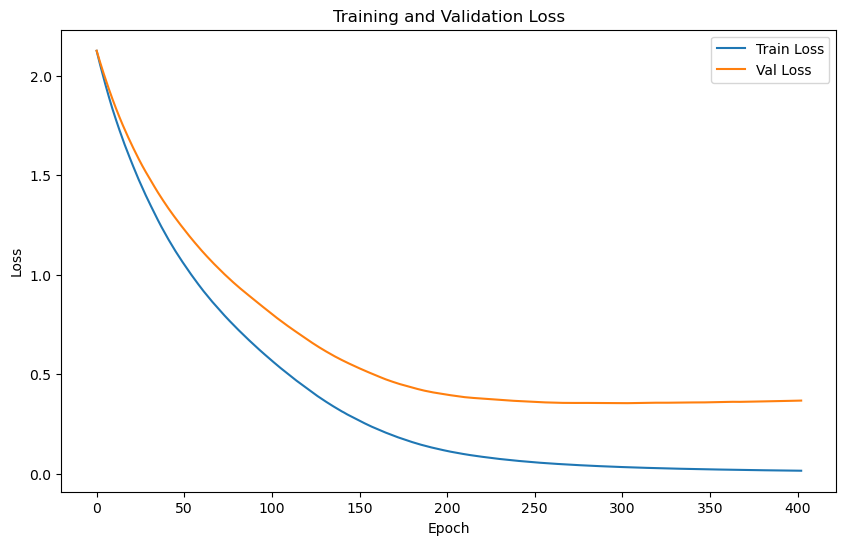

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2200 | Test Accuracy: 94.93%


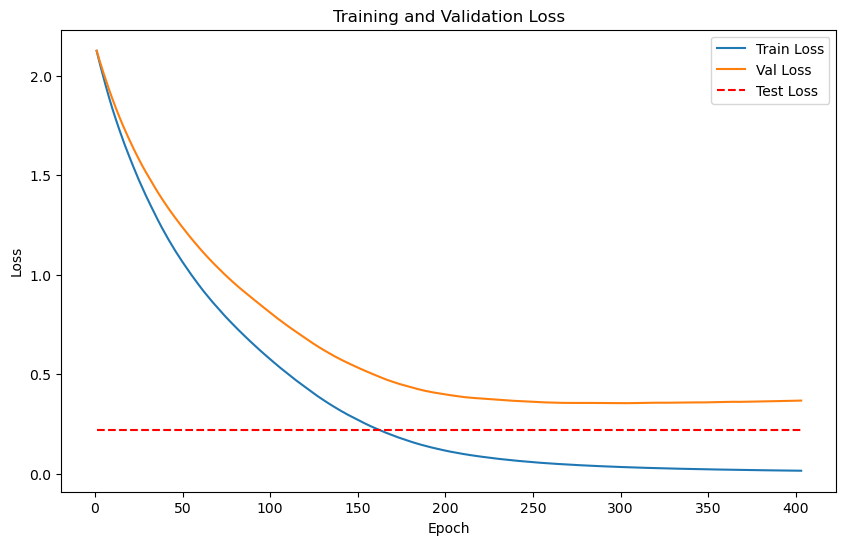

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


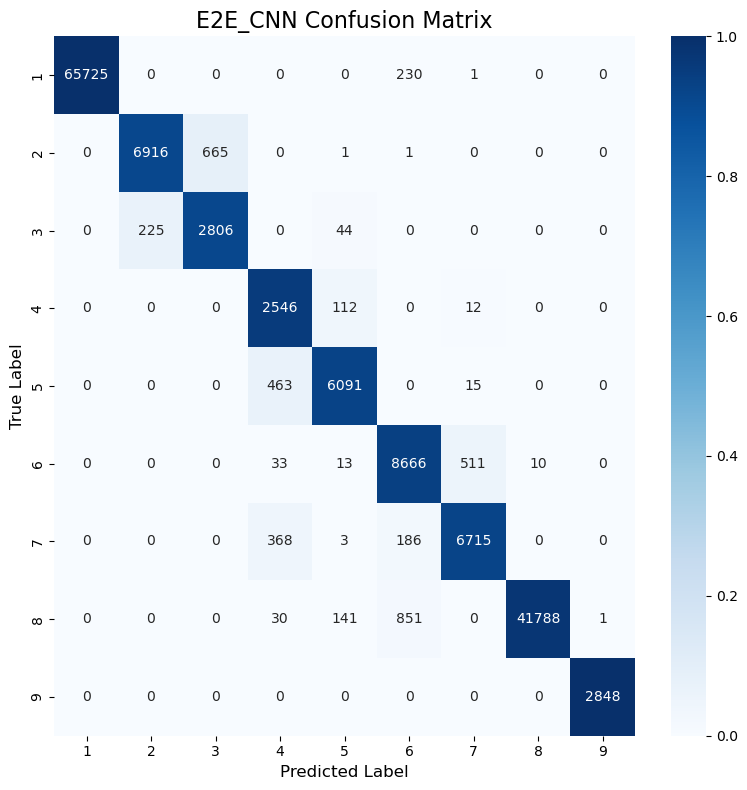

Classification Accuracy: 97.35%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


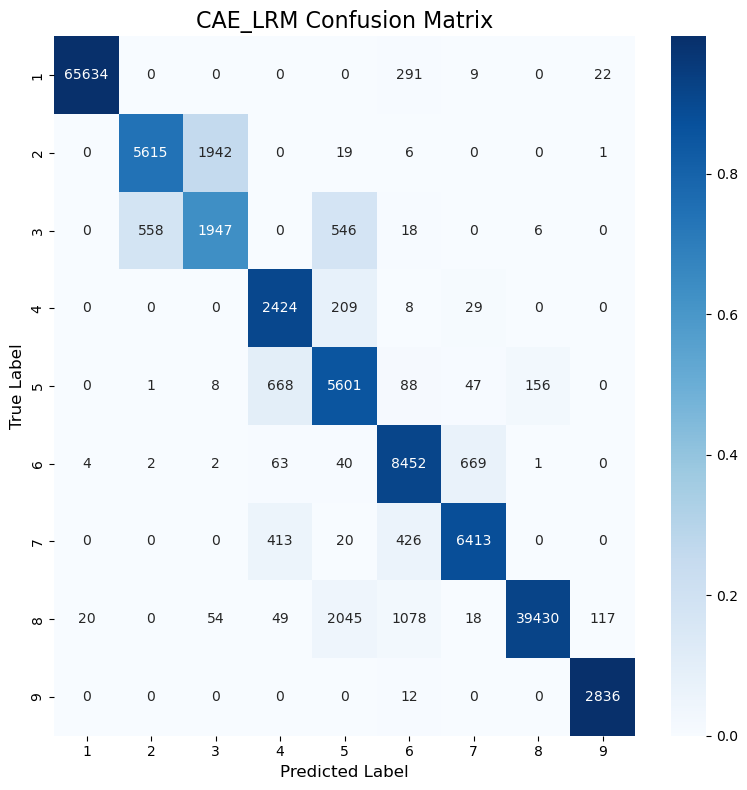

Classification Accuracy: 93.47%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


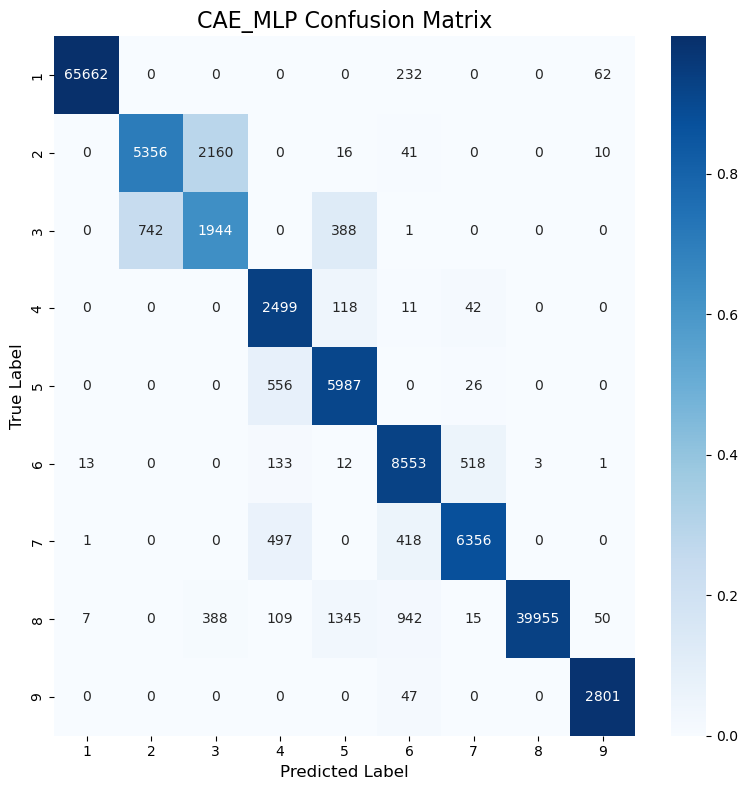

Classification Accuracy: 93.98%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


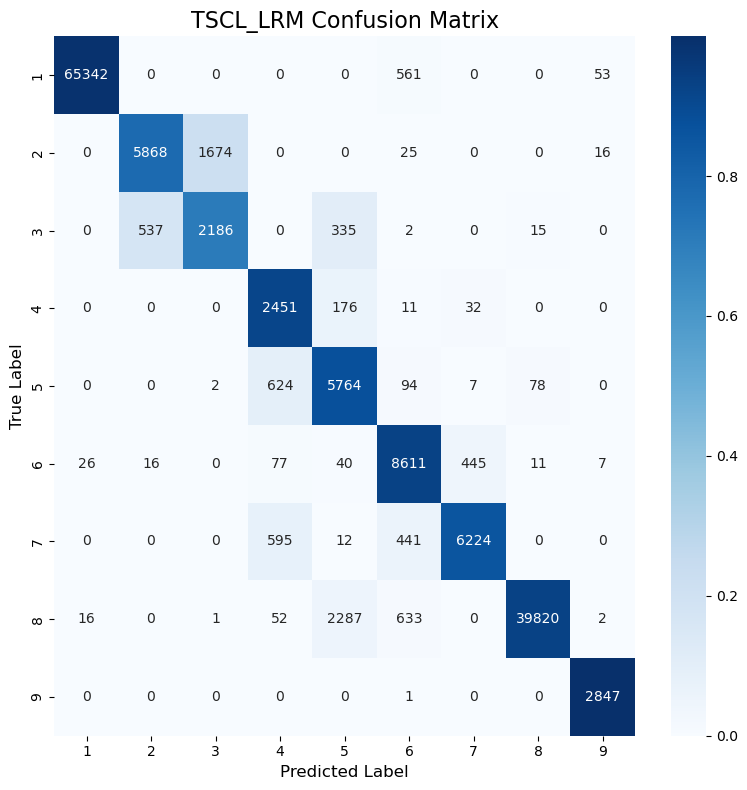

Classification Accuracy: 93.98%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


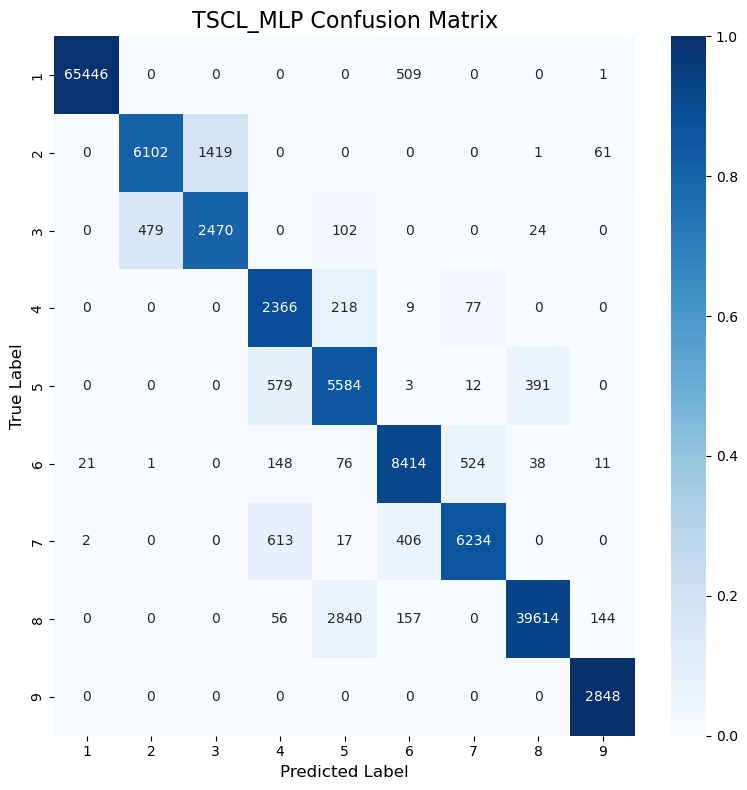

Classification Accuracy: 93.96%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


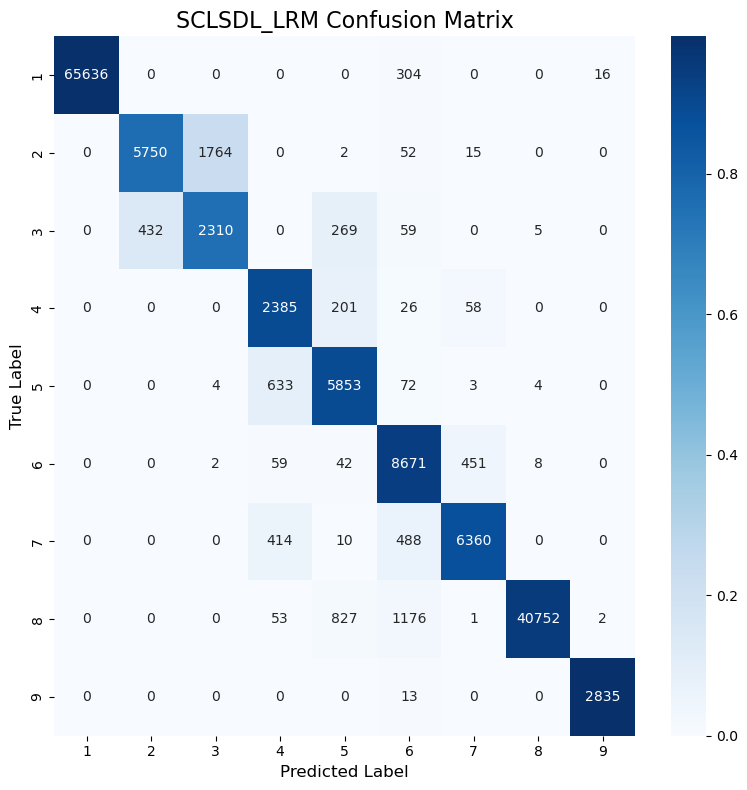

Classification Accuracy: 94.96%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


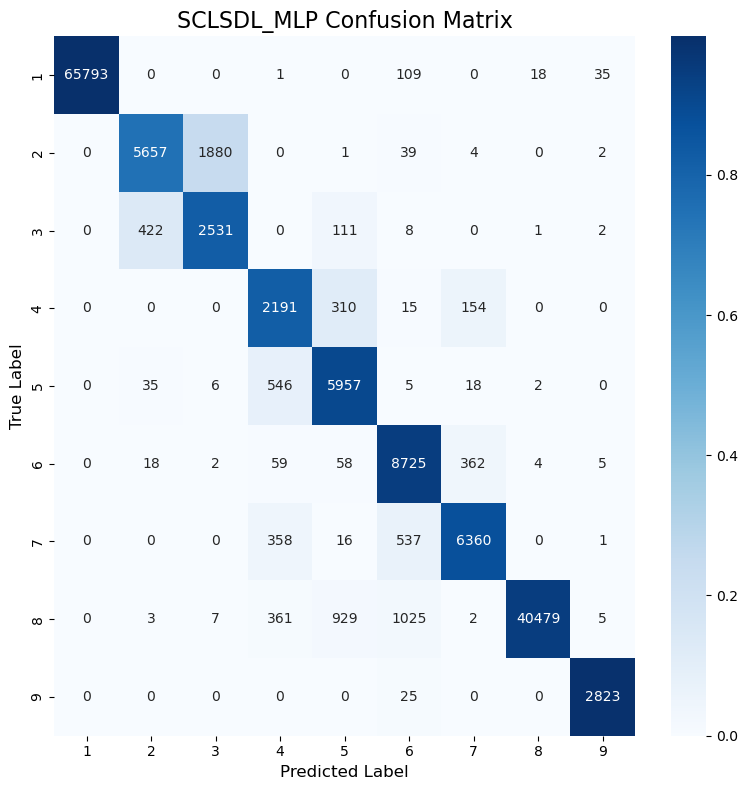

Classification Accuracy: 94.93%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.35
1    LRM (CAE)          93.47
2    MLP (CAE)          93.98
3     TSCL LRM          93.98
4     TSCL MLP          93.96
5  SCL_SDL LRM          94.96
6  SCL_SDL MLP          94.93

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.35
5  SCL_SDL LRM          94.96
6  SCL_SDL MLP          94.93
2    MLP (CAE)          93.98
3     TSCL LRM          93.98
4     TSCL MLP          93.96
1    LRM (CAE)          93.47
